# Import

In [498]:
import pandas as pd
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
# from google.colab import drive
import os
import numpy as np
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

# Imports
import tensorflow as tf 
# from google.colab import drive
import os

import traceback
import sys
import copy
import numpy as np
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# lib for LSTM of Meta model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import seaborn as sns


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from ftfy import fix_text
import warnings
warnings.simplefilter("ignore", UserWarning)

plt.rcParams['figure.figsize'] = [7, 3]
import math

# example of making a prediction with the direct multioutput regression model
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR

from pandas.api.types import CategoricalDtype

# Input path

In [2]:
prj_path = 'H:\\Store\\Research\\UIT\\PhD Research\\Dev Environment\\Tropical Diseases\\running'

result_path = 'H:\\Store\\Research\\UIT\\PhD Research\\Dev Environment\\Tropical Diseases\\running\\eval_result\\MLJ 2023\\'
result_path_3algo = result_path + "cnn-lstm-lstm_att- MAE\\"
result_path_tf = result_path + "tf\\"


result_path_sarima = result_path + "sarima_v3\\"
result_path_sarimax = result_path + "sarimax_v2\\"
result_path_poisson = result_path + "poisson_10_01_2023\\"
result_path_xgboost = result_path + "xgboost_10_01_2023\\"
result_path_svmrbf = result_path + "svmrbf_08_12_2022\\"

result_path_dart = result_path + "dart_optimized\\"
# result_path_ensemble = result_path + "ensemble_14_12_2022\\result\weighted_combination\\"
# result_path_weighted_ensemble = result_path + "weighted_combination_14_12\\"


# List cities 





In [3]:
cities = ['An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh', 'Hòa Bình',
        'Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn', 'Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
         'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp']

# cities = ['Điện Biên', 'Thái Bình', 'Lào Cai', 'Kon Tum', 'Cao Bằng','Lâm Đồng']
z=55

# Đọc kết quả predict và R2 từng base model

In [130]:
def get_df_with_r2(eval_metrix='MAE_1-month', result_algo_path='', file_head='', file_tail='_0'):    
    l_all_algo_cities = pd.DataFrame()
    for city in cities:
        city_result = pd.read_excel(
            result_algo_path + file_head + city + file_tail + '.xlsx')
        city_result = city_result[['City', 'Run Seq','Alg_name','Observed','1-month', 'RMSE_1-month','MAE_1-month']]
        # group by Alg_name, sort RMSE_1-month, select first row for each group
        selected_result = city_result.sort_values(
            by=[eval_metrix], ascending=True).groupby('Alg_name').head(36)
        selected_result = selected_result.sort_index(axis=0, ascending=True)

        # lấy kết quả theo giải thuật
        if len(l_all_algo_cities) == 0:
            l_all_algo_cities = selected_result
        else: 
            l_all_algo_cities = pd.concat([l_all_algo_cities, selected_result])
    return l_all_algo_cities

# Lọc ra theo từng giải thuật ứng với từng city
def extract_by_algo(algo='cnn', city_data=''):
    result = city_data.loc[city_data['Alg_name'] == algo]
    # result['Steps']= range(0,36)
    result.insert(0, 'Months', range(0, len(result)))
    # result = result.drop(['Steps'], axis=1)
    result = result.set_index('Months')
    return result


result_3algo_r2 = get_df_with_r2(eval_metrix = 'MAE_1-month', result_algo_path=result_path_3algo, file_head='diarrhoea_')
result_tf_r2 = get_df_with_r2(eval_metrix = 'MAE_1-month', result_algo_path=result_path_tf, file_head="diarrhoea_transformer_")
result_tf_r2 = result_tf_r2.reset_index(drop=True)

In [131]:
result_cnn_r2= extract_by_algo(algo='cnn', city_data =result_3algo_r2)
result_lstm_r2= extract_by_algo(algo='lstm', city_data =result_3algo_r2)
result_lstm_attention_r2= extract_by_algo(algo='lstm_attention', city_data =result_3algo_r2)

In [159]:
result_lstm_attention_r2

City  Run Seq        Alg_name   Observed    1-month  \
Months                                                             
0        An Giang        0  lstm_attention  42.255479  27.102992   
1        An Giang        0  lstm_attention  34.795904  31.179989   
2        An Giang        0  lstm_attention  30.579623  31.662899   
3        An Giang        0  lstm_attention  31.784275  30.831925   
4        An Giang        0  lstm_attention  20.201084  28.628874   
...           ...      ...             ...        ...        ...   
1975    Đồng Tháp        1  lstm_attention  59.348837  64.164126   
1976    Đồng Tháp        1  lstm_attention  63.379845  60.413267   
1977    Đồng Tháp        1  lstm_attention  56.248062  59.866877   
1978    Đồng Tháp        1  lstm_attention  65.302326  60.655635   
1979    Đồng Tháp        1  lstm_attention  46.511628  59.175424   

        RMSE_1-month  MAE_1-month        r2  
Months                                       
0           9.187015     6.302508  0.003625  
1           9.187015     6.302508  0.003625  
2           9.187015     6.302508  0.003625  
3           9.187015     6.302508  0.003625  
4           9.187015     6.302508  0.003625  
...              ...          ...       ...  
1975       13.899795     9.526524  0.253485  
1976       13.899795     9.526524  0.253485  
1977       13.899795     9.526524  0.253485  
1978       13.899795     9.526524  0.253485  
1979       13.899795     9.526524  0.253485  

[1980 rows x 8 columns]

In [135]:
# Calculate r2
import numpy
def cal_r2_each_city(city):    
    corr_matrix = numpy.corrcoef(city['Observed'], city['1-month'])
    corr = corr_matrix[0,1]
    R_sq = corr**2
    city['r2'] = R_sq
    return city

In [136]:
result_cnn_r2 = result_cnn_r2.groupby('City').apply(cal_r2_each_city)
result_lstm_r2 = result_lstm_r2.groupby('City').apply(cal_r2_each_city)
result_lstm_attention_r2 = result_lstm_attention_r2.groupby('City').apply(cal_r2_each_city)
result_tf_r2 = result_tf_r2.groupby('City').apply(cal_r2_each_city)


# lưu r2 của base model

In [ ]:
result_lstm_attention_r2.to_excel('lstm_att_r2.xlsx')
result_cnn_r2.to_excel('cnn_r2.xlsx')
result_lstm_r2.to_excel('lstm_r2.xlsx')
result_tf_r2.to_excel('tf_r2.xlsx')

In [162]:
result_tf_r2

City  Run Seq      Alg_name   Observed    1-month  RMSE_1-month  \
0      An Giang        0  transformers  42.255479  58.124733     35.600526   
1      An Giang        0  transformers  34.795904  60.106339     35.600526   
2      An Giang        0  transformers  30.579623  59.730822     35.600526   
3      An Giang        0  transformers  31.784275  58.857040     35.600526   
4      An Giang        0  transformers  20.201084  58.931618     35.600526   
...         ...      ...           ...        ...        ...           ...   
1975  Đồng Tháp        4  transformers  59.348837  79.019120     28.032084   
1976  Đồng Tháp        4  transformers  63.379845  81.982966     28.032084   
1977  Đồng Tháp        4  transformers  56.248062  79.083674     28.032084   
1978  Đồng Tháp        4  transformers  65.302326  79.370349     28.032084   
1979  Đồng Tháp        4  transformers  46.511628  80.405751     28.032084   

      MAE_1-month        r2  
0       34.513059  0.006400  
1       34.513059  0.006400  
2       34.513059  0.006400  
3       34.513059  0.006400  
4       34.513059  0.006400  
...           ...       ...  
1975    22.039111  0.007953  
1976    22.039111  0.007953  
1977    22.039111  0.007953  
1978    22.039111  0.007953  
1979    22.039111  0.007953  

[1980 rows x 8 columns]

In [148]:
com_path_climate_weighted_result_linearSVR = 'H:\\Store\\Research\\UIT\\PhD Research\\Dev Environment\\Tropical Diseases\\running\\'+ 'results\\ensemble\\'+ 'result\\weighted_combination\\predicted_result\\linearSVR\\'
dict_DWE_all = {}
df_DWE_all = pd.DataFrame()
for city in cities:
    weighted_final_result = pd.read_excel(com_path_climate_weighted_result_linearSVR+city+'_weighted_predict_4_com.xlsx')
    weighted_final_result.drop(columns='Unnamed: 0', inplace=True)    
    weighted_final_result.rename(columns = {'Weighted_Predict':'DWE','MAE_Weighted_Predict':'MAE_DWE','RMSE_Weighted_Predict':'RMSE_DWE'}, inplace = True)
    df_DWE_all = pd.concat([df_DWE_all,weighted_final_result])
    dict_DWE_all[city] = weighted_final_result
    

In [149]:
def cal_r2_dwe_each_city(city):    
    corr_matrix = numpy.corrcoef(city['Observed'], city['DWE'])
    corr = corr_matrix[0,1]
    R_sq = corr**2
    city['r2'] = R_sq
    return city

In [ ]:
df_DWE_all = df_DWE_all.groupby('City').apply(cal_r2_dwe_each_city)


In [166]:
df_DWE_all[['City','DWE','Observed','RMSE_DWE','MAE_DWE','r2']].to_excel('dwe_r2.xlsx')

In [ ]:
dwe_r2_city = df_DWE_all[['City','DWE','Observed','RMSE_DWE','MAE_DWE','r2']].groupby('City').head(1)
dwe_r2_city = dwe_r2_city.reset_index(drop=True)
dwe_r2_city

In [ ]:
dwe_r2_city['Alg_name'] = 'DWE'
dwe_r2_city

In [ ]:
result_lstm_attention_r2_city = result_lstm_attention_r2.groupby('City').head(1)
result_cnn_r2_city =  result_cnn_r2.groupby('City').head(1)
result_lstm_r2_city = result_lstm_r2.groupby('City').head(1)
result_tf_r2_city = result_tf_r2.groupby('City').head(1)
result_tf_r2_city

In [ ]:
result_tf_r2_city

In [185]:
df_r2_all_algo = pd.concat([    dwe_r2_city[['City','Alg_name','r2']], 
                                result_cnn_r2_city[['City','Alg_name','r2']],
                                result_lstm_r2_city[['City','Alg_name','r2']],
                                result_lstm_attention_r2_city[['City','Alg_name','r2']],
                                result_tf_r2_city[['City','Alg_name','r2']]
                            ], axis=0)


df_r2_all_algo = rename_alg_name (df_r2_all_algo)
df_r2_all_algo = df_r2_all_algo.reset_index(drop=True)
df_r2_all_algo

City Alg_name        r2
0       An Giang      DWE  0.131111
1    BR Vũng Tàu      DWE  0.595159
2     Bình Phước      DWE  0.338585
3     Bình Thuận      DWE  0.049250
4      Bình Định      DWE  0.005744
..           ...      ...       ...
270    Điện Biên       TF  0.015578
271      Đà Nẵng       TF  0.006583
272     Đắk Nông       TF  0.001209
273      Đắk Lắk       TF  0.003195
274    Đồng Tháp       TF  0.007953

[275 rows x 3 columns]

In [194]:
mean_r2 = df_r2_all_algo.groupby('Alg_name')['r2'].mean()
mean_r2

Alg_name
CNN         0.264472
DWE         0.298813
LSTM        0.259548
LSTM ATT    0.269069
TF          0.042646
Name: r2, dtype: float64

In [193]:
df_r2_all_algo.to_excel('r2_all_algo.xlsx')

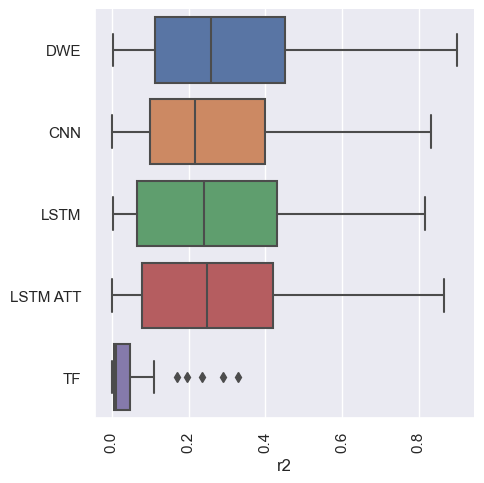

In [192]:
g = sns.catplot(data=df_r2_all_algo, x="r2",
                y="Alg_name", kind='box')
g.set(ylabel=None, xlabel="r2")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
df_r2_all_algo

# Ranking r2 của các base và dwe

In [262]:
pivot_df_r2_all_algo = df_r2_all_algo.pivot(index='City', columns='Alg_name', values='r2').reset_index(drop=True)
ranked_pivot_df_r2_all_algo = pivot_df_r2_all_algo.rank(axis=1,ascending=False)
ranked_pivot_df_r2_all_algo.mean(axis=0)

Alg_name
CNN         2.672727
DWE         2.290909
LSTM        2.727273
LSTM ATT    2.690909
TF          4.618182
dtype: float64

In [266]:
df_dwe = ranked_pivot_df_r2_all_algo['DWE'].value_counts()
df_lstm_attention = ranked_pivot_df_r2_all_algo['LSTM ATT'].value_counts()
df_lstm = ranked_pivot_df_r2_all_algo['LSTM'].value_counts()
df_cnn = ranked_pivot_df_r2_all_algo['CNN'].value_counts()
df_tf = ranked_pivot_df_r2_all_algo['TF'].value_counts()

arr_rank = []
for i in range(1,6):   
    try:
        a = df_lstm[i]
    except KeyError:
        a = 0    
    try:
        b = df_lstm_attention[i]
    except KeyError:
        b = 0
    try:
        c = df_cnn[i]
    except KeyError:
        c = 0
    try:
        d = df_tf[i]
    except KeyError:
        d = 0
    try:
        e = df_dwe[i]
    except KeyError:
        e = 0    
    arr_rank.append([e,a,b,c,d])
df_rank_table = pd.DataFrame(data=arr_rank, columns=['DWE','LSTM','ATT','CNN', 'TF'])
df_rank_table

DWE  LSTM  ATT  CNN  TF
0   16     9   16   14   0
1   16    16    9   11   3
2   15    12   12   13   3
3    7    17   12   13   6
4    1     1    6    4  43

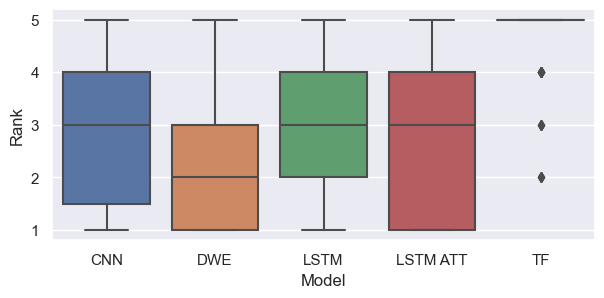

In [272]:
melted_ranked_pivot_df_r2_all_algo = pd.melt(ranked_pivot_df_r2_all_algo)
ax = sns.boxplot(x='Alg_name', y='value', data=melted_ranked_pivot_df_r2_all_algo)
# plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel('Model')
plt.ylabel('Rank')
plt.show()

# Đọc kết quả Single Models & Dart

In [200]:
# Lấy dạng Dataframe 3 kết quả metrix của tất cả thành phố theo eval_metrix
def get_df_best_metrix_results_by(eval_metrix='MAE_1-month', result_algo_path='', file_head='', file_tail='_0'):
    # Lọc ra theo min RMSE - của cả 3 giải thuật
    l_all_algo_cities = pd.DataFrame()
    for city in cities:
        city_result = pd.read_excel(
            result_algo_path + file_head + city + file_tail + '.xlsx')
        city_result = city_result[['City', 'Alg_name', 'RMSE_1-month','MAE_1-month']]
        # group by Alg_name, sort RMSE_1-month, select first row for each group
        selected_result = city_result.sort_values(
            by=[eval_metrix], ascending=True).groupby('Alg_name').head(1)
        selected_result = selected_result.sort_index(axis=0, ascending=True)

        # lấy kết quả theo giải thuật
        if len(l_all_algo_cities) == 0:
            l_all_algo_cities = selected_result
        else: 
            l_all_algo_cities = pd.concat([l_all_algo_cities, selected_result])
    return l_all_algo_cities
# Lọc ra theo từng giải thuật ứng với từng city
def extract_by_algo(algo='cnn', city_data=''):
    result = city_data.loc[city_data['Alg_name'] == algo]
    # result['Steps']= range(0,36)
    result.insert(0, 'Months', range(0, len(result)))
    # result = result.drop(['Steps'], axis=1)
    result = result.set_index('Months')
    return result



def get_dict_result(dict):
    lstm_att_result = {}
    cnn_result = {}
    lstm_result = {}
    tf_result = {}
    sarima_result = {}
    ensemble_result = {}
    sarimax_result = {}
    svm_result = {}
    xgboost_result = {}
    ps_result = {}
    for city in cities:
        one_city = dict[city]

        ps_one_city = extract_by_algo(algo='poisson', city_data=one_city)
        ps_result[city] = ps_one_city

        xgboost_one_city = extract_by_algo(algo='xgboost', city_data=one_city)
        xgboost_result[city] = xgboost_one_city

        svm_one_city = extract_by_algo(algo='SVM-BRF', city_data=one_city)
        svm_result[city] = svm_one_city

        sarima_one_city = extract_by_algo(algo='SARIMA', city_data=one_city)
        sarima_result[city] = sarima_one_city

        ensemble_one_city = extract_by_algo(
            algo='ensemble', city_data=one_city)
        ensemble_result[city] = ensemble_one_city

        sarimax_one_city = extract_by_algo(algo='SARIMAX', city_data=one_city)
        sarimax_result[city] = sarimax_one_city

        cnn_one_city = extract_by_algo(algo='cnn', city_data=one_city)
        cnn_result[city] = cnn_one_city

        lstm_one_city = extract_by_algo(algo='lstm', city_data=one_city)
        lstm_result[city] = lstm_one_city

        lstm_att_one_city = extract_by_algo(
            algo='lstm_attention', city_data=one_city)
        lstm_att_result[city] = lstm_att_one_city

        tf_one_city = extract_by_algo(algo='transformers', city_data=one_city)
        tf_result[city] = tf_one_city
    # return   svm_result , xgboost_result, ps_result , sarima_result, sarimax_result
    return lstm_att_result, cnn_result, lstm_result, tf_result, sarima_result, ensemble_result, svm_result, xgboost_result, ps_result, sarimax_result

# Lấy 
result_3algo = get_df_best_metrix_results_by(eval_metrix = 'MAE_1-month', result_algo_path=result_path_3algo, file_head='diarrhoea_')
result_cnn= extract_by_algo(algo='cnn', city_data =result_3algo)
result_lstm = extract_by_algo(algo='lstm', city_data =result_3algo)
result_lstm_att = extract_by_algo(algo='lstm_attention', city_data =result_3algo)

# tf
result_tf = get_df_best_metrix_results_by(eval_metrix = 'MAE_1-month', result_algo_path=result_path_tf, file_head="diarrhoea_transformer_")

# sarima
result_sarima = get_df_best_metrix_results_by(result_algo_path=result_path_sarima, file_head="diarrhoea_sarima_")

# sarimax
result_sarimax = get_df_best_metrix_results_by(result_algo_path=result_path_sarimax, file_head="diarrhoea_sarimax_")

# Poisoon
result_poisson = get_df_best_metrix_results_by(result_algo_path=result_path_poisson, file_head="out_", file_tail="_poisson")

# Xgboost
result_xgboost = get_df_best_metrix_results_by(result_algo_path=result_path_xgboost, file_head="out_", file_tail="_xgboost")

# svmrbf
result_svmrbf = get_df_best_metrix_results_by(result_algo_path=result_path_svmrbf, file_head="diarrhoea_svmrbf_", file_tail="_0")


In [ ]:
result_cnn

In [201]:
def process_dart():
    dart_model_dict = {

    }
    model_list = ['BlockRNNModel', 'CatBoostModel', 'LightGBMModel', 'LinearRegressionModel',
                   'RandomForest', 'TCNModel', 'TFTModel','NBEATSModel','NHiTSModel']
    # model_list = ['NHiTSModel']

    for model in model_list:
        cities_result = pd.DataFrame()
        for city in cities:
            # print(city)
            city_result = pd.read_excel(
                result_path_dart + model + "\\" + city + ".xlsx")
            city_result = city_result.head(1)
            city_result['Alg_name'] = model
            city_result = city_result[['City', 'Alg_name', 'RMSE_1-month','MAE_1-month']]
            if len(cities_result) == 0:
                cities_result = city_result
            else:
                cities_result = pd.concat([cities_result, city_result])
        dart_model_dict[model] = cities_result
    return dart_model_dict
# dart models
dart_model_dict = process_dart()

# Mix all Single Models & Dart

In [339]:
def rename_alg_name(df =''):
    df.replace(['cnn','lstm','lstm_attention','transformers','sarima','poisson','xgboost','BlockRNNModel','CatBoostModel','LightGBMModel','LinearRegressionModel','NHiTSModel','TCNModel','TFTModel','NBEATSModel'],
               ['CNN', 'LSTM','LSTM ATT','TF','SARIMA','Poisson','XGBoost','BlockRNN','CatBoost','LightGBM','Linear Regression','N-HiTS','TCN','TFT','N-BEATS'], inplace = True)
 
    return df

In [340]:
total_result = pd.concat([
    result_lstm_att,
    result_lstm, 
    result_cnn,    
    result_tf,
    result_sarima,
    result_sarimax,
    dart_model_dict['LightGBMModel'],
    dart_model_dict['CatBoostModel'],
    dart_model_dict['RandomForest'],  
    result_poisson,
    result_xgboost,
    result_svmrbf,  
    dart_model_dict['LinearRegressionModel'],
    dart_model_dict['BlockRNNModel'],
    dart_model_dict['NHiTSModel'],   
    dart_model_dict['NBEATSModel'], 
    dart_model_dict['TCNModel'],  
    dart_model_dict['TFTModel']      
])
rename_alg_name(total_result)


City  Alg_name  RMSE_1-month  MAE_1-month
0      An Giang  LSTM ATT      9.187015     6.302508
1   BR Vũng Tàu  LSTM ATT     53.296997    51.661176
2    Bình Phước  LSTM ATT     12.420859    10.545003
3    Bình Thuận  LSTM ATT     15.959430    10.214883
4     Bình Định  LSTM ATT      4.180263     2.945025
..          ...       ...           ...          ...
0     Điện Biên       TFT    143.472954   122.950229
0       Đà Nẵng       TFT     33.926923    28.876000
0      Đắk Nông       TFT     16.918187    15.633449
0       Đắk Lắk       TFT     35.770424    28.141927
0     Đồng Tháp       TFT     28.649097    25.076694

[990 rows x 4 columns]

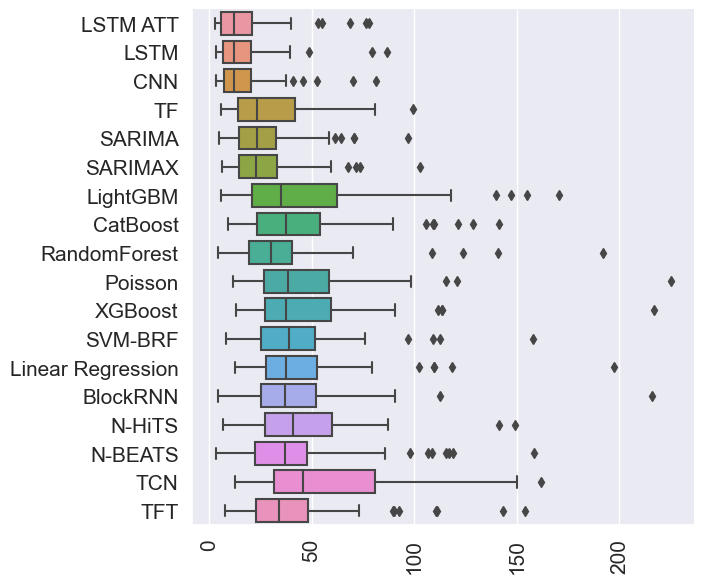

In [341]:
g = sns.catplot(data=total_result, x="RMSE_1-month",
                y="Alg_name", kind='box', height=6, aspect=1.2)
g.set(ylabel=None, xlabel="")
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
# plt.savefig(prj_path + '\\Figures\\avg_rmse_all_single_algo.png', dpi=600)
plt.show()

In [342]:

data_single = total_result.groupby('Alg_name')['MAE_1-month'].agg(['mean'])
data_single

mean
Alg_name                    
BlockRNN           37.677737
CNN                12.573898
CatBoost           40.026536
LSTM               12.460072
LSTM ATT           13.161273
LightGBM           42.011722
Linear Regression  40.437104
N-BEATS            39.378103
N-HiTS             38.351846
Poisson            43.575302
RandomForest       32.341340
SARIMA             23.554649
SARIMAX            23.376503
SVM-BRF            37.892413
TCN                49.984546
TF                 26.467210
TFT                35.035208
XGBoost            38.434936

In [343]:

data_single = total_result.groupby('Alg_name')['RMSE_1-month'].agg(['mean'])
data_single

mean
Alg_name                    
BlockRNN           43.042359
CNN                17.269185
CatBoost           46.205485
LSTM               17.027811
LSTM ATT           17.513797
LightGBM           48.865450
Linear Regression  46.128981
N-BEATS            44.812975
N-HiTS             46.007677
Poisson            48.543327
RandomForest       38.300490
SARIMA             27.706283
SARIMAX            28.092878
SVM-BRF            43.950952
TCN                59.897057
TF                 31.221760
TFT                42.469922
XGBoost            47.679748

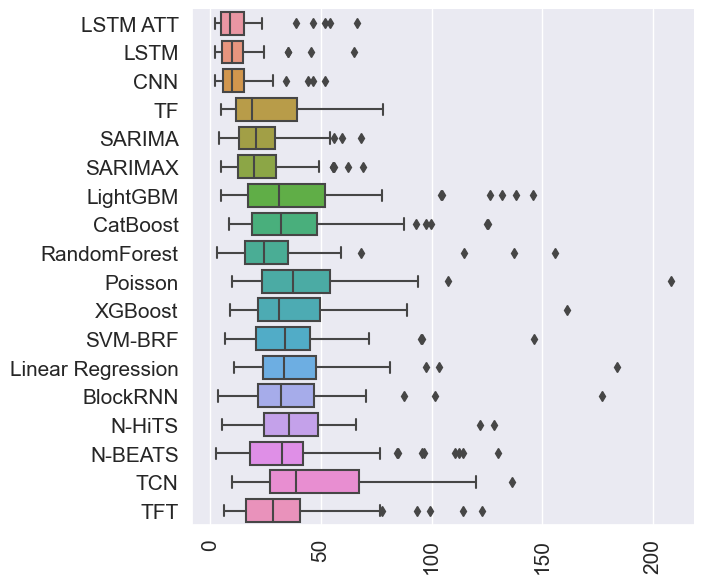

In [344]:
ax = sns.catplot(data=total_result, x="MAE_1-month",
                y="Alg_name", kind='box', height=6, aspect=1.2)
ax.set(ylabel=None, xlabel="")
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
# plt.savefig(prj_path + '\\Figures\\avg_mae_all_single_algo.png', dpi=600)

plt.show()

# Mix Deep Learning & Sarmia

In [345]:
best_base_models = pd.concat([
    # result_sarima,    
    result_cnn,
    result_lstm,
    result_tf,
    result_lstm_att
])
# best_base_models
rename_alg_name(best_base_models)

City  Alg_name  RMSE_1-month  MAE_1-month
0      An Giang       CNN     11.487143     8.723466
1   BR Vũng Tàu       CNN     30.577739    28.494376
2    Bình Phước       CNN     10.689800     8.419473
3    Bình Thuận       CNN     14.379248    10.010952
4     Bình Định       CNN      3.932358     3.173477
..          ...       ...           ...          ...
50    Điện Biên  LSTM ATT     68.645033    54.124853
51      Đà Nẵng  LSTM ATT     19.162011    13.336673
52     Đắk Nông  LSTM ATT      9.043391     6.934960
53      Đắk Lắk  LSTM ATT     21.364264    17.580318
54    Đồng Tháp  LSTM ATT     13.899795     9.526524

[220 rows x 4 columns]

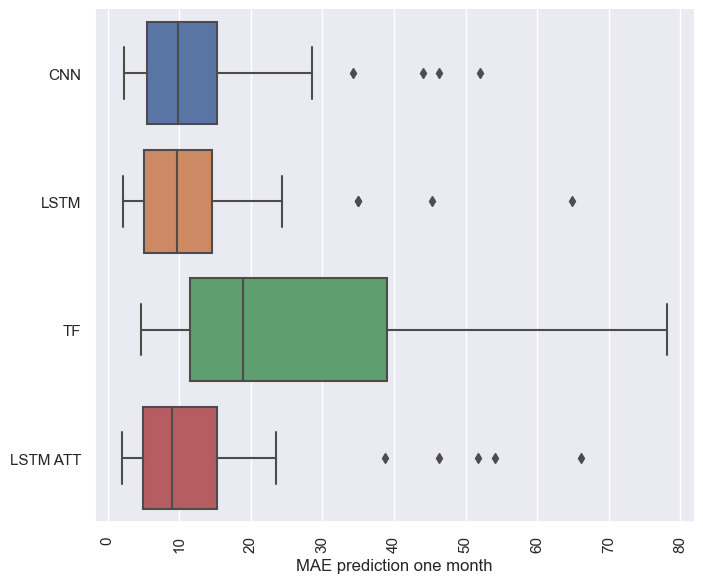

In [346]:
g = sns.catplot(data=best_base_models, x="MAE_1-month",
                y="Alg_name", kind='box', height=6, aspect=1.2)
g.set(ylabel=None, xlabel="MAE prediction one month")
plt.xticks(rotation=90)
plt.tight_layout()

# plt.savefig(prj_path + '\\Figures\\avg_mae_all_single_algo.png', dpi=600)
plt.show()

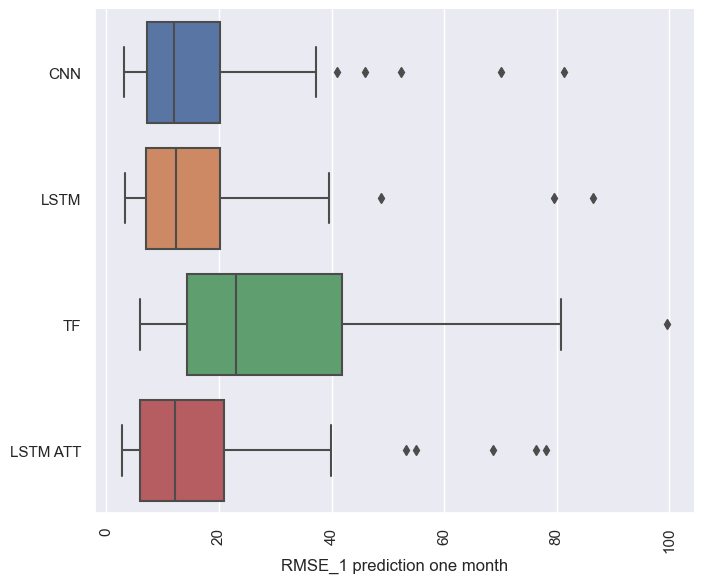

In [347]:
g = sns.catplot(data=best_base_models, x="RMSE_1-month",
                y="Alg_name", kind='box', height=6, aspect=1.2)
g.set(ylabel=None, xlabel="RMSE_1 prediction one month")
plt.xticks(rotation=90)
plt.tight_layout()

# plt.savefig(prj_path + '\\Figures\\avg_mae_all_single_algo.png', dpi=600)
plt.show()

# Plot rank of best Single Models

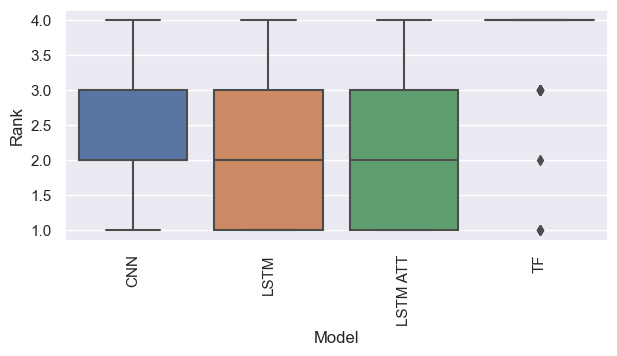

In [348]:
#@ Theo RMSE
best_base_models_rmse = best_base_models.pivot(index='City', columns='Alg_name', values='RMSE_1-month')
ranked_best_base_models_rmse = best_base_models_rmse.rank(axis=1)

melted_ranked_best_base_models_rmse = pd.melt(ranked_best_base_models_rmse)
ax = sns.boxplot(x='Alg_name', y='value', data=melted_ranked_best_base_models_rmse)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel('Model')
plt.ylabel('Rank')
plt.show()


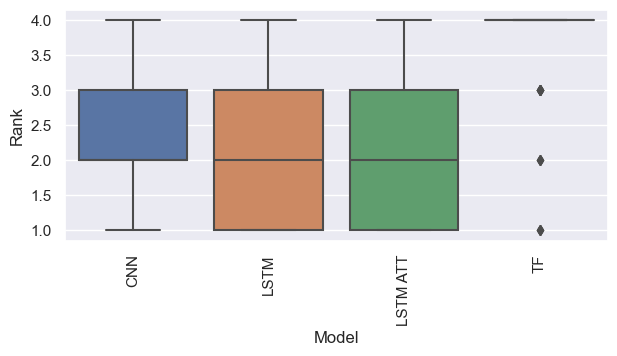

In [349]:
# Theo MAE
best_base_models_mae = best_base_models.pivot(index='City', columns='Alg_name', values='MAE_1-month')
ranked_best_base_models_mae = best_base_models_mae.rank(axis=1)
melted_best_base_models_mae = pd.melt(ranked_best_base_models_mae)
ax = sns.boxplot(x='Alg_name', y='value', data=melted_best_base_models_mae)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel('Model')
plt.ylabel('Rank')
plt.show()

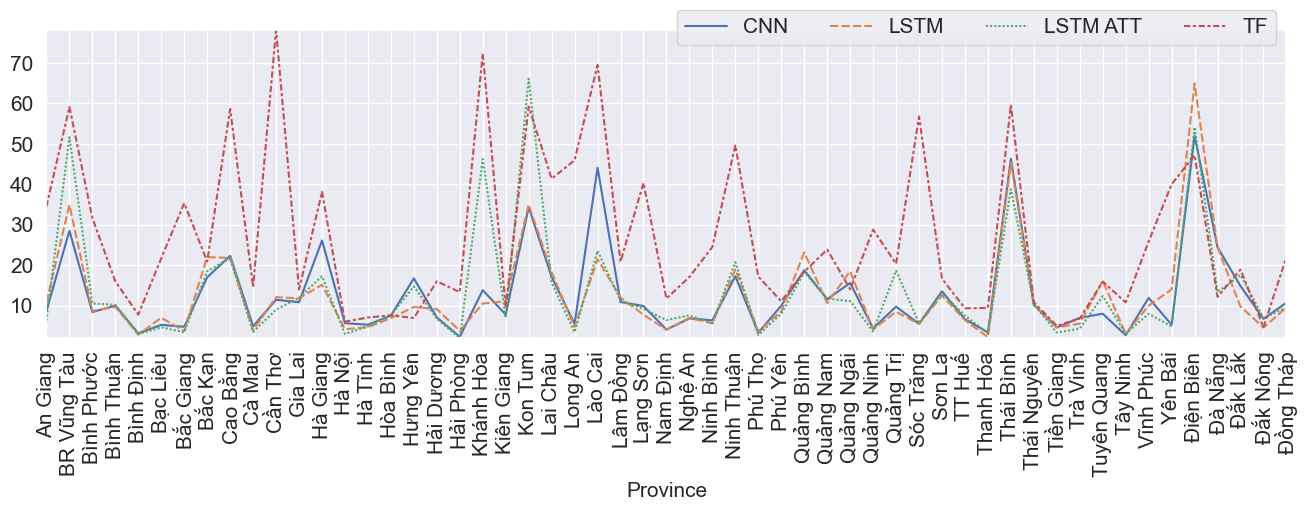

In [528]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.lineplot(data=best_base_models_mae.iloc[:,:6])
plt.legend(loc='best', bbox_to_anchor=(1, 1.1), shadow=False,ncol=5, fontsize=15)
plt.xlabel('Province', fontsize= 15)
plt.ylabel('') #MAE
plt.xticks(rotation= 90, fontsize= 15)
plt.yticks(fontsize= 15)
plt.margins(0,0)
# plt.savefig(prj_path + '\\Figures\\top_based_model_rmse.png', dpi=600)
plt.show()

# So sánh MCE vs Deep Learning

In [351]:
mce_ensemble = pd.read_excel(result_path+'simple_ensemble_all_mae_new.xlsx').drop(columns='Unnamed: 0')
mce_ensemble.rename(columns = {'RMSE_Simple_Avg':'RMSE_1-month','MAE_Simple_Avg':'MAE_1-month'}, inplace = True)
mce_ensemble.head()

City  RMSE_1-month  MAE_1-month Alg_name
0     An Giang     13.980455    12.234686      MCE
1  BR Vũng Tàu     43.899254    42.858768      MCE
2   Bình Phước     10.632935     8.170849      MCE
3   Bình Thuận     16.624161    10.385778      MCE
4    Bình Định      4.944682     3.298095      MCE

In [352]:
# mce_ensemble.rename(columns={"MCE_MAE": 'RMSE_1-month',"MCE_RMSE": 'MAE_1-month'}, inplace=True)
deep_and_simple = pd.concat([     
    result_cnn,
    result_lstm,
    result_tf,
    result_lstm_att,
    mce_ensemble
])
rename_alg_name(deep_and_simple)
deep_and_simple.head()

City Alg_name  RMSE_1-month  MAE_1-month
0     An Giang      CNN     11.487143     8.723466
1  BR Vũng Tàu      CNN     30.577739    28.494376
2   Bình Phước      CNN     10.689800     8.419473
3   Bình Thuận      CNN     14.379248    10.010952
4    Bình Định      CNN      3.932358     3.173477

In [353]:
pivot_deep_and_simple = deep_and_simple.pivot(index='City', columns='Alg_name', values='MAE_1-month').reset_index(drop=True)
ranked_deep_and_simple = pivot_deep_and_simple.rank(axis=1)
ranked_deep_and_simple.mean(axis=0)

Alg_name
CNN         2.890909
LSTM        2.618182
LSTM ATT    2.472727
MCE         2.490909
TF          4.527273
dtype: float64

In [354]:
ranked_deep_and_simple.median(axis=0)

Alg_name
CNN         3.0
LSTM        3.0
LSTM ATT    2.0
MCE         2.0
TF          5.0
dtype: float64

In [355]:
pivot_deep_and_simple = deep_and_simple.pivot(index='City', columns='Alg_name', values='MAE_1-month').reset_index(drop=True)
ranked_deep_and_simple = pivot_deep_and_simple.rank(axis=1)
ranked_deep_and_simple.mean(axis=0)

Alg_name
CNN         2.890909
LSTM        2.618182
LSTM ATT    2.472727
MCE         2.490909
TF          4.527273
dtype: float64

In [356]:
deep_and_simple

City Alg_name  RMSE_1-month  MAE_1-month
0      An Giang      CNN     11.487143     8.723466
1   BR Vũng Tàu      CNN     30.577739    28.494376
2    Bình Phước      CNN     10.689800     8.419473
3    Bình Thuận      CNN     14.379248    10.010952
4     Bình Định      CNN      3.932358     3.173477
..          ...      ...           ...          ...
50    Điện Biên      MCE     66.853446    49.150713
51      Đà Nẵng      MCE     34.520736    32.385214
52     Đắk Nông      MCE      5.592140     4.209832
53      Đắk Lắk      MCE     14.685783    11.447366
54    Đồng Tháp      MCE     12.781332     8.694381

[275 rows x 4 columns]

In [357]:
mean_deep_mce_rmse = deep_and_simple.groupby('Alg_name')['RMSE_1-month'].agg(['mean'])
# carefull
mean_deep_mce_rmse['mean'].MCE = 12.43583
mean_deep_mce_rmse

mean
Alg_name           
CNN       17.269185
LSTM      17.027811
LSTM ATT  17.513797
MCE       12.435830
TF        31.221760

In [358]:
mean_deep_mce_mae = deep_and_simple.groupby('Alg_name')['MAE_1-month'].agg(['mean'])
# carefull
mean_deep_mce_mae['mean'].MCE = 12.43583
mean_deep_mce_mae['mean'] 

Alg_name
CNN         12.573898
LSTM        12.460072
LSTM ATT    13.161273
MCE         12.435830
TF          26.467210
Name: mean, dtype: float64

In [359]:
mean_deep_mce_mae['mean'].MCE = 12.43583
mean_deep_mce_mae['mean']

Alg_name
CNN         12.573898
LSTM        12.460072
LSTM ATT    13.161273
MCE         12.435830
TF          26.467210
Name: mean, dtype: float64

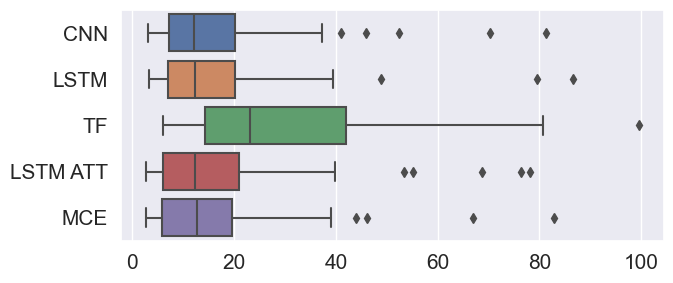

In [381]:
ax = sns.boxplot(y='Alg_name', x='RMSE_1-month', data=deep_and_simple)
plt.ylabel('')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('') # Plot RMSE
plt.show()

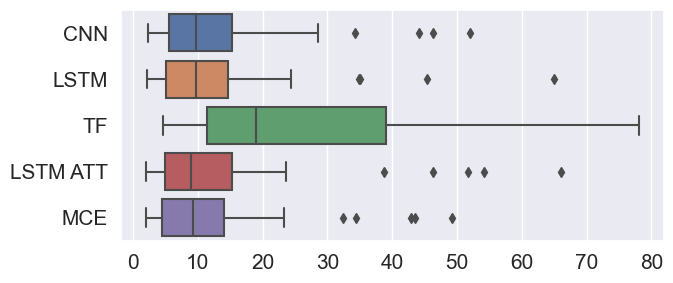

In [382]:
ax = sns.boxplot(y='Alg_name', x='MAE_1-month', data=deep_and_simple)
plt.ylabel('')
plt.xlabel('')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()# Plot MAE

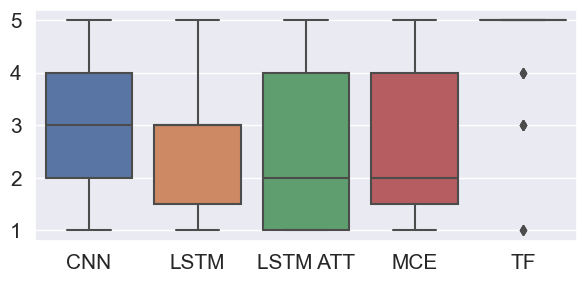

In [383]:
# Theo MAE
deep_and_simple_mae = deep_and_simple.pivot(index='City', columns='Alg_name', values='MAE_1-month')
ranked_deep_and_simple_mae = deep_and_simple_mae.rank(axis=1)
melted_ranked_deep_and_simple_mae = pd.melt(ranked_deep_and_simple_mae)
ax = sns.boxplot(x='Alg_name', y='value', data=melted_ranked_deep_and_simple_mae)
# plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show() #Plot rank

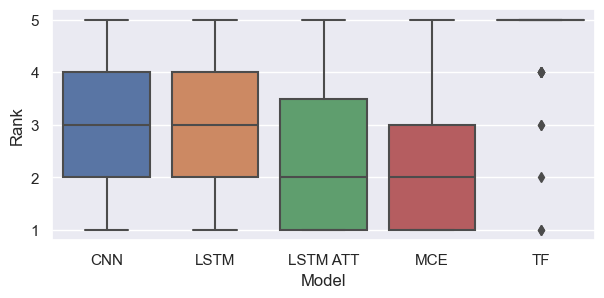

In [363]:
# Theo RMSE
deep_and_simple_rmse = deep_and_simple.pivot(index='City', columns='Alg_name', values='RMSE_1-month')
ranked_deep_and_simple_rmse = deep_and_simple_rmse.rank(axis=1)
melted_ranked_deep_and_simple_rmse = pd.melt(ranked_deep_and_simple_rmse)
ax = sns.boxplot(x='Alg_name', y='value', data=melted_ranked_deep_and_simple_rmse)
# plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel('Model')
plt.ylabel('Rank')
plt.show()

In [364]:
pivot_deep_and_simple = deep_and_simple.pivot(index='City', columns='Alg_name', values='RMSE_1-month').reset_index(drop=True)
ranked_deep_and_simple = pivot_deep_and_simple.rank(axis=1)
ranked_deep_and_simple.mean(axis=0)

Alg_name
CNN         2.854545
LSTM        2.745455
LSTM ATT    2.436364
MCE         2.363636
TF          4.600000
dtype: float64

In [365]:
ranked_deep_and_simple.median(axis=0)

Alg_name
CNN         3.0
LSTM        3.0
LSTM ATT    2.0
MCE         2.0
TF          5.0
dtype: float64

# Bảng xếp hạng MCE vs Deep learning by MAE

In [366]:
simple_ensemble = pd.read_excel(result_path+'simple_ensemble_all_mae_new.xlsx').drop(columns='Unnamed: 0')
simple_ensemble.rename(columns = {'RMSE_Simple_Avg':'RMSE_1-month','MAE_Simple_Avg':'MAE_1-month'}, inplace = True)
simple_ensemble['Alg_name'] = 'MCE'

deep_and_simple = pd.concat([    
    result_cnn,
    result_lstm,
    result_tf,
    result_lstm_att,
    simple_ensemble
])
# best_base_models
rename_alg_name(deep_and_simple)

pivot_deep_and_simple = deep_and_simple.pivot(index='City', columns='Alg_name', values='MAE_1-month').reset_index(drop=True)
ranked_deep_and_simple = pivot_deep_and_simple.rank(axis=1)
ranked_deep_and_simple.mean(axis=0)


df_simple = ranked_deep_and_simple['MCE'].value_counts()
df_lstm_attention = ranked_deep_and_simple['LSTM ATT'].value_counts()
df_lstm = ranked_deep_and_simple['LSTM'].value_counts()
df_cnn = ranked_deep_and_simple['CNN'].value_counts()
df_tf = ranked_deep_and_simple['TF'].value_counts()
# df_sarima = ranked_deep_and_simple['SARIMA'].value_counts()

arr_rank = []
for i in range(1,6):   
    try:
        a = df_lstm[i]
    except KeyError:
        a = 0    
    try:
        b = df_lstm_attention[i]
    except KeyError:
        b = 0
    try:
        c = df_cnn[i]
    except KeyError:
        c = 0
    try:
        d = df_tf[i]
    except KeyError:
        d = 0
    try:
        e = df_simple[i]
    except KeyError:
        e = 0    
    arr_rank.append([a,b,c,d,e])
df_rank_table = pd.DataFrame(data=arr_rank, columns=['LSTM','ATT','CNN', 'TF','MCE'])
df_rank_table

LSTM  ATT  CNN  TF  MCE
0    14   15    9   3   14
1     9   17   10   0   19
2    21    7   15   5    7
3     6   14   20   4   11
4     5    2    1  43    4

In [367]:
deep_and_simple

City Alg_name  RMSE_1-month  MAE_1-month
0      An Giang      CNN     11.487143     8.723466
1   BR Vũng Tàu      CNN     30.577739    28.494376
2    Bình Phước      CNN     10.689800     8.419473
3    Bình Thuận      CNN     14.379248    10.010952
4     Bình Định      CNN      3.932358     3.173477
..          ...      ...           ...          ...
50    Điện Biên      MCE     66.853446    49.150713
51      Đà Nẵng      MCE     34.520736    32.385214
52     Đắk Nông      MCE      5.592140     4.209832
53      Đắk Lắk      MCE     14.685783    11.447366
54    Đồng Tháp      MCE     12.781332     8.694381

[275 rows x 4 columns]

In [368]:
data_single = deep_and_simple.groupby('Alg_name')['RMSE_1-month'].agg(['mean'])
data_single

mean
Alg_name           
CNN       17.269185
LSTM      17.027811
LSTM ATT  17.513797
MCE       16.631195
TF        31.221760

In [369]:
data_single = deep_and_simple.groupby('Alg_name')['MAE_1-month'].agg(['mean'])
data_single

mean
Alg_name           
CNN       12.573898
LSTM      12.460072
LSTM ATT  13.161273
MCE       12.235830
TF        26.467210

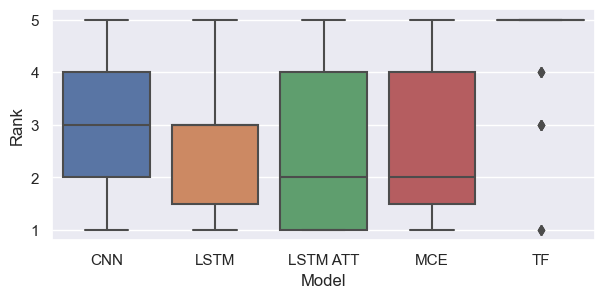

In [370]:
melted_ranked_deep_and_simple_mae = pd.melt(ranked_deep_and_simple)
ax = sns.boxplot(x='Alg_name', y='value', data=melted_ranked_deep_and_simple_mae)
# plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel('Model')
plt.ylabel('Rank')
plt.show()

# Bảng xếp hạng MCE vs Deep learning by RMSE

In [371]:
simple_ensemble = pd.read_excel(result_path+'simple_ensemble_all_mae_new.xlsx').drop(columns='Unnamed: 0')
simple_ensemble.rename(columns = {'RMSE_Simple_Avg':'RMSE_1-month','MAE_Simple_Avg':'MAE_1-month'}, inplace = True)
simple_ensemble['Alg_name'] = 'MCE'

deep_and_simple = pd.concat([    
    result_cnn,
    result_lstm,
    result_tf,
    result_lstm_att,
    simple_ensemble
])
# best_base_models
rename_alg_name(deep_and_simple)

pivot_deep_and_simple = deep_and_simple.pivot(index='City', columns='Alg_name', values='RMSE_1-month').reset_index(drop=True)
ranked_deep_and_simple = pivot_deep_and_simple.rank(axis=1)
ranked_deep_and_simple.mean(axis=0)


df_simple = ranked_deep_and_simple['MCE'].value_counts()
df_lstm_attention = ranked_deep_and_simple['LSTM ATT'].value_counts()
df_lstm = ranked_deep_and_simple['LSTM'].value_counts()
df_cnn = ranked_deep_and_simple['CNN'].value_counts()
df_tf = ranked_deep_and_simple['TF'].value_counts()
# df_sarima = ranked_deep_and_simple['SARIMA'].value_counts()

arr_rank = []
for i in range(1,6):   
    try:
        a = df_lstm[i]
    except KeyError:
        a = 0    
    try:
        b = df_lstm_attention[i]
    except KeyError:
        b = 0
    try:
        c = df_cnn[i]
    except KeyError:
        c = 0
    try:
        d = df_tf[i]
    except KeyError:
        d = 0
    try:
        e = df_simple[i]
    except KeyError:
        e = 0    
    arr_rank.append([a,b,c,d,e])
df_rank_table = pd.DataFrame(data=arr_rank, columns=['LSTM','ATT','CNN', 'TF','MCE'])
df_rank_table

LSTM  ATT  CNN  TF  MCE
0    12   15   10   2   16
1    10   17   10   1   17
2    18    9   15   2   11
3    10   12   18   7    8
4     5    2    2  43    3

# Vẽ range theo MAE của Best Based Model (Sarmia + Deep Learning) vs Simple Ensemble

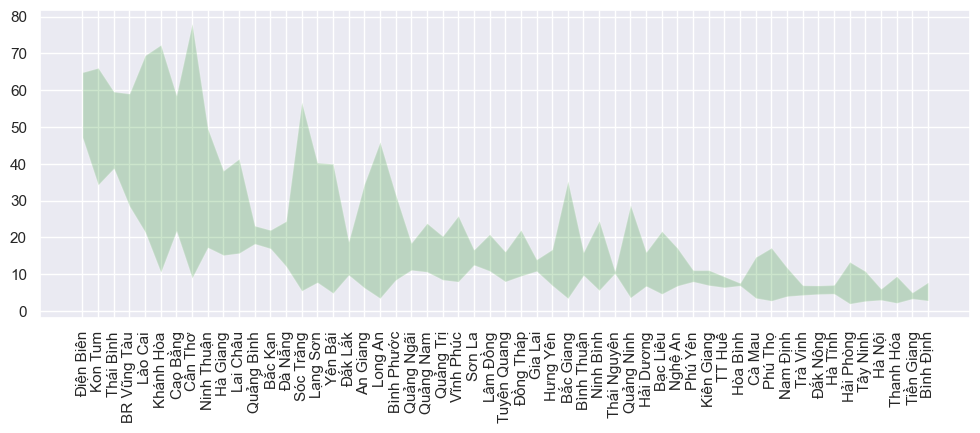

In [372]:
range_best_base_models = best_base_models.groupby('City')['MAE_1-month'].agg(['min', 'max','mean'])
range_best_base_models.reset_index(inplace=True)

# Sort để cho chart đi từ cao đến thấp, từ trái qua phải
range_best_base_models_sorted = range_best_base_models.sort_values(by='mean', ascending=False)
range_best_base_models_sorted.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(12, 4))
plt.fill_between(x='City',y1='min',y2='max', facecolor='green', alpha=0.2, interpolate=True, data=range_best_base_models_sorted),
plt.xticks(rotation=90)
plt.show()

In [373]:
simple_ensemble = pd.read_excel(result_path+'simple_ensemble_all_mae_new.xlsx').drop(columns='Unnamed: 0')
simple_ensemble.rename(columns = {'RMSE_Simple_Avg':'MCE_RMSE','MAE_Simple_Avg':'MCE_MAE'}, inplace = True)
simple_ensemble.drop(columns='Alg_name', inplace=True)
simple_ensemble.head()

City  RMSE_1-month  MAE_1-month
0     An Giang     13.980455    12.234686
1  BR Vũng Tàu     43.899254    42.858768
2   Bình Phước     10.632935     8.170849
3   Bình Thuận     16.624161    10.385778
4    Bình Định      4.944682     3.298095

In [374]:
# Merge Simple with range of single
merge_simple_with_range_single = range_best_base_models_sorted.merge(simple_ensemble,on ='City')
merge_simple_with_range_single.head()

City        min        max       mean  RMSE_1-month  MAE_1-month
0    Điện Biên  47.176334  64.894150  54.541053     66.853446    49.150713
1      Kon Tum  34.307752  66.076359  48.642980     46.196719    34.383445
2    Thái Bình  38.782252  59.626038  47.521081     82.879371    43.545715
3  BR Vũng Tàu  28.494376  59.097306  43.539413     43.899254    42.858768
4      Lào Cai  21.469415  69.489370  39.649676     30.363560    23.300853

In [375]:
merge_simple_with_range_single.loc[merge_simple_with_range_single['MCE_MAE'] < merge_simple_with_range_single['min'], 'smallest'] = merge_simple_with_range_single['MCE_MAE']

ax  = merge_simple_with_range_single.plot.line( y='MCE_MAE', c='red',figsize=(12, 4))
plt.scatter(x= merge_simple_with_range_single['City'], y =merge_simple_with_range_single['smallest'],  marker='*',c='black')
# merge_dwe_with_range_single.plot.scatter( x='City', y='smallest', c='red')
plt.fill_between(x='City',y1='min',y2='max', facecolor='green', hatch='\\\\\\\\', alpha=0.2, interpolate=True, data=merge_simple_with_range_single),
plt.xticks(rotation=90)
plt.show()

KeyError: 'MCE_MAE'

In [ ]:
def rename_error_province_index(df):
    df['province'] = df['province'].replace(['Bà Rịa - Vũng Tàu', 'Bình Ðịnh','Hoà Bình','Khánh Hoà','Lâm Ðồng','Nam Ðịnh','Thừa Thiên Huế','Thanh Hoá','Ðiện Biên','Ðà Nẵng','Ðắk Lắk','Ðắk Nông','Ðồng Tháp'], 
                                            ['BR Vũng Tàu', 'Bình Định','Hòa Bình','Khánh Hòa','Lâm Đồng','Nam Định','TT Huế','Thanh Hóa','Điện Biên','Đà Nẵng','Đắk Lắk','Đắk Nông','Đồng Tháp'])
    
    return df
#Đọc phân nhóm tỉnh theo 5 khu vực
city_by_group= pd.read_excel('H:\\Store\\Research\\UIT\\PhD Research\\Dev Environment\\Tropical Diseases\\running\\data\\data_gov_statistics\\province_region.xlsx')
city_by_group = rename_error_province_index(df = city_by_group)
city_by_group.set_index('province',inplace=True)
# không có thành phố 'Bình Dương', 'Bắc Ninh', 'Bến Tre', 'Hà Nam', 'Hậu Giang','TP Hồ Chí Minh', 'Vĩnh Long', 'Đồng Nai'
sub_region_list = city_by_group['subregion'].unique()

# Alternatively, add subregion column to full dataset
def label_subregion(row):
    return city_by_group.loc[row['province'],'subregion']

def label_region(row):
    return city_by_group.loc[row['province'],'region']

merge_simple_with_range_single.rename(columns = {'City':'province'}, inplace = True)
vietnam = merge_simple_with_range_single.copy()

vietnam["subregion"] = vietnam.apply(label_subregion, axis = 1)
vietnam["region"] = vietnam.apply(label_region, axis = 1)

cat_sub_region_order = CategoricalDtype(
    [ 'Northeast', 'Northwest', 'Red River Delta','North Central Coast','South Central Coast', 'Central Highlands', 'Mekong River Delta','Southeast'], 
    ordered=True
)
vietnam['subregion'] = vietnam['subregion'].astype(cat_sub_region_order)
vietnam_sort = vietnam.sort_values('subregion').copy().reset_index(drop=True)

NameError: name 'merge_simple_with_range_single' is not defined

# Vẽ MCE so sánh range của Best Base Models, phân loại theo vùng

In [ ]:
ax  = vietnam_sort.plot.line( y='MCE_MAE', c='red',figsize=(16, 4),legend=False)
plt.scatter(x= vietnam_sort['province'], y =vietnam_sort['smallest'],  marker='*',c='black')
plt.fill_between(x='province',y1='min',y2='max', facecolor='green', hatch='\\\\\\\\', alpha=0.2, interpolate=True, data=vietnam_sort),
ax.vlines([9.5, 14.5, 22.5, 28.5,36.5,41.5,51.5], -5, 100, color ="blue", linestyles ='dotted') 
plt.text(3,100,'Northeast')
plt.text(10,100,'Northwest')
plt.text(16,100,'Red River Delta')
plt.text(23,100,'North Central')
plt.text(30,100,'South Central')
plt.text(37.5,95,'Central'+ '\n' +'Highlands')
plt.text(43,100,'Mekong River Delta')
plt.text(52,100,'Southeast')
plt.xticks(rotation=90)
plt.show()

NameError: name 'vietnam_sort' is not defined

# Bảng xếp hạng MCE vs Deep Learning

In [ ]:
simple_ensemble = pd.read_excel(result_path+'simple_ensemble_all_mae_new.xlsx').drop(columns='Unnamed: 0')
simple_ensemble.rename(columns = {'RMSE_Simple_Avg':'RMSE_1-month','MAE_Simple_Avg':'MAE_1-month'}, inplace = True)
simple_ensemble['Alg_name'] = 'MCE'

deep_and_simple = pd.concat([
    # result_sarima,    
    result_cnn,
    result_lstm,
    result_tf,
    result_lstm_att,
    simple_ensemble
])
# best_base_models
rename_alg_name(deep_and_simple)

pivot_deep_and_simple = deep_and_simple.pivot(index='City', columns='Alg_name', values='MAE_1-month').reset_index(drop=True)
ranked_deep_and_simple = pivot_deep_and_simple.rank(axis=1)
ranked_deep_and_simple.mean(axis=0)


df_simple = ranked_deep_and_simple['MCE'].value_counts()
df_lstm_attention = ranked_deep_and_simple['LSTM ATT'].value_counts()
df_lstm = ranked_deep_and_simple['LSTM'].value_counts()
df_cnn = ranked_deep_and_simple['CNN'].value_counts()
df_tf = ranked_deep_and_simple['TF'].value_counts()
# df_sarima = ranked_deep_and_simple['SARIMA'].value_counts()

arr_rank = []
for i in range(1,6):   
    try:
        a = df_lstm[i]
    except KeyError:
        a = 0    
    try:
        b = df_lstm_attention[i]
    except KeyError:
        b = 0
    try:
        c = df_cnn[i]
    except KeyError:
        c = 0
    try:
        d = df_tf[i]
    except KeyError:
        d = 0
    try:
        e = df_simple[i]
    except KeyError:
        e = 0    
    arr_rank.append([a,b,c,d,e])
df_rank_table = pd.DataFrame(data=arr_rank, columns=['LSTM','ATT','CNN', 'TF','MCE'])
df_rank_table

LSTM  ATT  CNN  TF  MCE
0    14   15    9   3   14
1     9   17   10   0   19
2    21    7   15   5    7
3     6   14   20   4   11
4     5    2    1  43    4

In [ ]:
ranked_deep_and_simple.mean(axis=0)

Alg_name
CNN         2.890909
LSTM        2.618182
LSTM ATT    2.472727
MCE         2.490909
TF          4.527273
dtype: float64

# Bảng xếp hạng MCE vs Deep learning theo RMSE

In [ ]:
simple_ensemble = pd.read_excel(result_path+'simple_ensemble_all_mae_new.xlsx').drop(columns='Unnamed: 0')
simple_ensemble.rename(columns = {'RMSE_Simple_Avg':'RMSE_1-month','MAE_Simple_Avg':'MAE_1-month'}, inplace = True)
simple_ensemble['Alg_name'] = 'MCE'

deep_and_simple = pd.concat([
    # result_sarima,    
    result_cnn,
    result_lstm,
    result_tf,
    result_lstm_att,
    simple_ensemble
])
# best_base_models
rename_alg_name(deep_and_simple)

pivot_deep_and_simple = deep_and_simple.pivot(index='City', columns='Alg_name', values='RMSE_1-month').reset_index(drop=True)
ranked_deep_and_simple = pivot_deep_and_simple.rank(axis=1)
ranked_deep_and_simple.mean(axis=0)


df_simple = ranked_deep_and_simple['MCE'].value_counts()
df_lstm_attention = ranked_deep_and_simple['LSTM ATT'].value_counts()
df_lstm = ranked_deep_and_simple['LSTM'].value_counts()
df_cnn = ranked_deep_and_simple['CNN'].value_counts()
df_tf = ranked_deep_and_simple['TF'].value_counts()
# df_sarima = ranked_deep_and_simple['SARIMA'].value_counts()

arr_rank = []
for i in range(1,6):   
    try:
        a = df_lstm[i]
    except KeyError:
        a = 0    
    try:
        b = df_lstm_attention[i]
    except KeyError:
        b = 0
    try:
        c = df_cnn[i]
    except KeyError:
        c = 0
    try:
        d = df_tf[i]
    except KeyError:
        d = 0
    try:
        e = df_simple[i]
    except KeyError:
        e = 0    
    arr_rank.append([a,b,c,d,e])
df_rank_table = pd.DataFrame(data=arr_rank, columns=['LSTM','ATT','CNN', 'TF','MCE'])
df_rank_table

LSTM  ATT  CNN  TF  MCE
0    12   15   10   2   16
1    10   17   10   1   17
2    18    9   15   2   11
3    10   12   18   7    8
4     5    2    2  43    3

# Đọc DWE và so sánh với Best Based Models

In [ ]:
dwe = pd.read_excel(result_path+'DWE_SVM.xlsx').drop(columns='Unnamed: 0')
dwe.rename(columns = {'Model Name':'Alg_name'}, inplace = True)
best_base_models = pd.concat([   
    result_cnn,
    result_lstm,
    result_tf,
    result_lstm_att    
])
# best_base_models
rename_alg_name(best_base_models)
simple_ensemble_copy = simple_ensemble.rename(columns = {'RMSE_1-month':'MCE_RMSE','MAE_1-month':'MCE_MAE'})
best_base_models.head()

City Alg_name  RMSE_1-month  MAE_1-month
0     An Giang      CNN     11.487143     8.723466
1  BR Vũng Tàu      CNN     30.577739    28.494376
2   Bình Phước      CNN     10.689800     8.419473
3   Bình Thuận      CNN     14.379248    10.010952
4    Bình Định      CNN      3.932358     3.173477

In [ ]:
data = best_base_models.groupby('City')['MAE_1-month'].agg(['min', 'max','mean'])
data.reset_index(inplace=True)
data_sorted = data.reset_index(drop=True)


merge_dwe_with_range_single = data_sorted.merge(dwe,on ='City')
merge_dwe_with_range_single = merge_dwe_with_range_single.merge(simple_ensemble_copy,on ='City')
merge_dwe_with_range_single.rename(columns = {'RMSE_1-month':'DWE_RMSE','MAE_1-month':'DWE_MAE'}, inplace = True)
# merge_dwe_with_range_single.drop(columns=['Model Name'], inplace=True)
merge_dwe_with_range_single.head()

City        min        max       mean   DWE_RMSE    DWE_MAE  \
0     An Giang   6.302508  34.513059  15.077932  14.186441  12.614244   
1  BR Vũng Tàu  28.494376  59.097306  43.539413  38.856552  37.823752   
2   Bình Phước   8.419473  31.672148  14.831030  10.997809   8.445490   
3   Bình Thuận   9.689825  16.010681  11.481585  16.474459  10.145264   
4    Bình Định   2.839944   7.787460   4.186476   5.582184   3.531021   

  Alg_name   MCE_RMSE    MCE_MAE  
0      DWE  13.980455  12.234686  
1      DWE  43.899254  42.858768  
2      DWE  10.632935   8.170849  
3      DWE  16.624161  10.385778  
4      DWE   4.944682   3.298095

In [477]:
merge_dwe_with_range_single.loc[(merge_dwe_with_range_single['DWE_MAE'] < merge_dwe_with_range_single['min']) & (merge_dwe_with_range_single['DWE_MAE'] <merge_dwe_with_range_single['MCE_MAE']) , 'smallest'] = merge_dwe_with_range_single['DWE_MAE']
merge_dwe_with_range_single.loc[(merge_dwe_with_range_single['DWE_MAE'] < merge_dwe_with_range_single['min']) , 'smallest_vs_base'] = merge_dwe_with_range_single['DWE_MAE']

In [ ]:
# # ax  = merge_dwe_with_range_single.plot.line( y='DWE_1_MAE', c='red',figsize=(12, 4))
# ax = merge_dwe_with_range_single.loc[:,['MCE_MAE','DWE_MAE']].plot(figsize=(12, 4))
# plt.scatter(x= merge_dwe_with_range_single['City'], y =merge_dwe_with_range_single['smallest'],  marker='*',c='black')
# # merge_dwe_with_range_single.plot.scatter( x='City', y='smallest', c='red')
# plt.fill_between(x='City',y1='min',y2='max', facecolor='green', hatch='\\\\\\\\', alpha=0.2, interpolate=True, data=merge_dwe_with_range_single),
# plt.xticks(rotation=90)
# plt.show()

In [478]:
def rename_error_province_index(df):
    df['province'] = df['province'].replace(['Bà Rịa - Vũng Tàu', 'Bình Ðịnh','Hoà Bình','Khánh Hoà','Lâm Ðồng','Nam Ðịnh','Thừa Thiên Huế','Thanh Hoá','Ðiện Biên','Ðà Nẵng','Ðắk Lắk','Ðắk Nông','Ðồng Tháp'], 
                                            ['BR Vũng Tàu', 'Bình Định','Hòa Bình','Khánh Hòa','Lâm Đồng','Nam Định','TT Huế','Thanh Hóa','Điện Biên','Đà Nẵng','Đắk Lắk','Đắk Nông','Đồng Tháp'])
    
    return df
#Đọc phân nhóm tỉnh theo 5 khu vực
city_by_group= pd.read_excel('H:\\Store\\Research\\UIT\\PhD Research\\Dev Environment\\Tropical Diseases\\running\\data\\data_gov_statistics\\province_region.xlsx')
city_by_group = rename_error_province_index(df = city_by_group)
city_by_group.set_index('province',inplace=True)
# không có thành phố 'Bình Dương', 'Bắc Ninh', 'Bến Tre', 'Hà Nam', 'Hậu Giang','TP Hồ Chí Minh', 'Vĩnh Long', 'Đồng Nai'
sub_region_list = city_by_group['subregion'].unique()

# Alternatively, add subregion column to full dataset
def label_subregion(row):
    return city_by_group.loc[row['province'],'subregion']

def label_region(row):
    return city_by_group.loc[row['province'],'region']

merge_dwe_with_range_single.rename(columns = {'City':'province'}, inplace = True)
vietnam = merge_dwe_with_range_single.copy()

vietnam["subregion"] = vietnam.apply(label_subregion, axis = 1)
vietnam["region"] = vietnam.apply(label_region, axis = 1)

cat_sub_region_order = CategoricalDtype(
    [ 'Northeast', 'Northwest', 'Red River Delta','North Central Coast','South Central Coast', 'Central Highlands', 'Mekong River Delta','Southeast'], 
    ordered=True
)
vietnam['subregion'] = vietnam['subregion'].astype(cat_sub_region_order)
vietnam_sort = vietnam.sort_values('subregion').copy().reset_index(drop=True)
vietnam_sort.head()

province        min        max       mean   DWE_RMSE    DWE_MAE  \
0  Thái Nguyên  11.719281  12.257110  11.947988  11.946372  10.424885   
1     Hà Giang  19.043249  45.295769  30.754074  27.569082  21.751055   
2     Lạng Sơn  11.022939  43.222711  20.182432  17.168503  13.794636   
3  Tuyên Quang  11.115799  22.017025  17.251266  14.987638  12.158707   
4      Bắc Kạn  20.675316  25.230585  22.971207  19.941923  16.338526   

  Alg_name   MCE_RMSE    MCE_MAE   smallest  smallest_vs_base  subregion  \
0      DWE  11.800845  10.324387        NaN         10.424885  Northeast   
1      DWE  27.543148  21.738243        NaN               NaN  Northeast   
2      DWE  17.118279  13.899857        NaN               NaN  Northeast   
3      DWE  14.464171  11.479042        NaN               NaN  Northeast   
4      DWE  19.934361  16.427084  16.338526         16.338526  Northeast   

  region  
0  North  
1  North  
2  North  
3  North  
4  North

# Vẽ DWE, MCE, base models theo MAE 

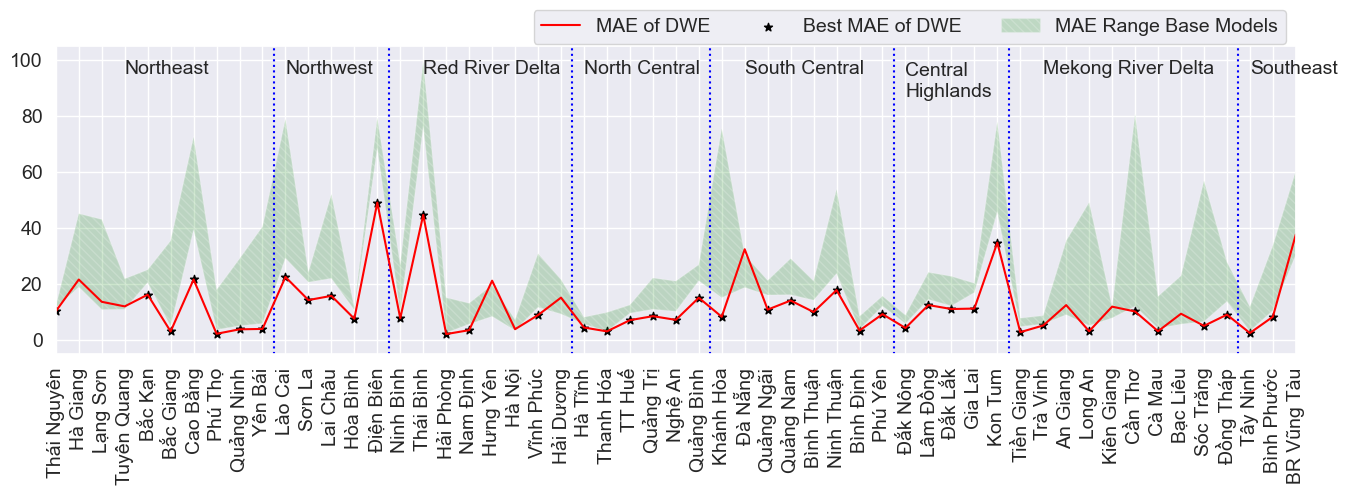

In [484]:
# Vẽ MCE, DWE, Base Model theo MAE
ax  = vietnam_sort.loc[:,['DWE_MAE']].plot(figsize=(16, 4), c='red',legend=False)
# plt.scatter(x= vietnam_sort['province'], y =vietnam_sort['smallest']+2,  marker='*',c='red')
plt.scatter(x= vietnam_sort['province'], y =vietnam_sort['smallest_vs_base'],  marker='*',c='black')
plt.fill_between(x='province',y1='min',y2='max', label='MAE Range Base Models', facecolor='green', hatch='\\\\\\\\', alpha=0.2, interpolate=True, data=vietnam_sort)
ax.vlines([9.5, 14.5, 22.5, 28.5,36.5,41.5,51.5], -5, 105, color ="blue", linestyles ='dotted') 
plt.legend([ 'MAE of DWE','Best MAE of DWE','MAE Range Base Models'],loc='best', bbox_to_anchor=(1, 1.15), shadow=False,ncol=5,fontsize=14)
plt.text(3,95,'Northeast', fontsize =14)
plt.text(10,95,'Northwest', fontsize =14)
plt.text(16,95,'Red River Delta', fontsize =14)
plt.text(23,95,'North Central', fontsize =14)
plt.text(30,95,'South Central', fontsize =14)
plt.text(37,87,'Central'+ '\n' +'Highlands', fontsize =14)
plt.text(43,95,'Mekong River Delta', fontsize =14)
plt.text(52,95,'Southeast', fontsize =14)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.margins(0,0)
plt.show()


# Vẽ DWE, MCE, base models theo RMSE 

In [459]:
data = best_base_models.groupby('City')['RMSE_1-month'].agg(['min', 'max','mean'])
data.reset_index(inplace=True)

# Sort để cho chart đi từ cao đến thấp, từ trái qua phải
# data_sorted = data.sort_values(by='mean', ascending=False)
data_sorted = data.reset_index(drop=True)

simple_ensemble_copy = simple_ensemble.rename(columns = {'RMSE_1-month':'MCE_RMSE','MAE_1-month':'MCE_MAE'})
simple_ensemble_copy.head()

merge_dwe_with_range_single = data_sorted.merge(dwe,on ='City')
merge_dwe_with_range_single = merge_dwe_with_range_single.merge(simple_ensemble_copy,on ='City')
merge_dwe_with_range_single.rename(columns = {'RMSE_1-month':'DWE_RMSE','MAE_1-month':'DWE_MAE'}, inplace = True)
# merge_dwe_with_range_single.drop(columns=['Alg_name'], inplace=True)
merge_dwe_with_range_single.head()

City        min        max       mean   DWE_RMSE    DWE_MAE  \
0     An Giang   9.187015  35.600526  17.148608  14.186441  12.614244   
1  BR Vũng Tàu  30.577739  60.532284  45.422554  38.856552  37.823752   
2   Bình Phước  10.689800  33.878340  17.164552  10.997809   8.445490   
3   Bình Thuận  14.379248  21.266869  16.638407  16.474459  10.145264   
4    Bình Định   3.932358   8.634129   5.231370   5.582184   3.531021   

  Alg_name   MCE_RMSE    MCE_MAE  
0      DWE  13.980455  12.234686  
1      DWE  43.899254  42.858768  
2      DWE  10.632935   8.170849  
3      DWE  16.624161  10.385778  
4      DWE   4.944682   3.298095

In [460]:
merge_dwe_with_range_single.loc[(merge_dwe_with_range_single['DWE_RMSE'] < merge_dwe_with_range_single['min']) , 'smallest'] = merge_dwe_with_range_single['DWE_RMSE']
# ax  = merge_dwe_with_range_single.plot.line( y='DWE_1_MAE', c='red',figsize=(12, 4))
# ax = merge_dwe_with_range_single.loc[:,['MCE_RMSE','DWE_RMSE']].plot(figsize=(12, 4))
# plt.scatter(x= merge_dwe_with_range_single['City'], y =merge_dwe_with_range_single['smallest'],  marker='*',c='black')
# # merge_dwe_with_range_single.plot.scatter( x='City', y='smallest', c='red')
# plt.fill_between(x='City',y1='min',y2='max', facecolor='green', hatch='\\\\\\\\', alpha=0.2, interpolate=True, data=merge_dwe_with_range_single),
# plt.xticks(rotation=90)
# plt.show()

In [461]:
def rename_error_province_index(df):
    df['province'] = df['province'].replace(['Bà Rịa - Vũng Tàu', 'Bình Ðịnh','Hoà Bình','Khánh Hoà','Lâm Ðồng','Nam Ðịnh','Thừa Thiên Huế','Thanh Hoá','Ðiện Biên','Ðà Nẵng','Ðắk Lắk','Ðắk Nông','Ðồng Tháp'], 
                                            ['BR Vũng Tàu', 'Bình Định','Hòa Bình','Khánh Hòa','Lâm Đồng','Nam Định','TT Huế','Thanh Hóa','Điện Biên','Đà Nẵng','Đắk Lắk','Đắk Nông','Đồng Tháp'])
    
    return df
#Đọc phân nhóm tỉnh theo 5 khu vực
city_by_group= pd.read_excel('H:\\Store\\Research\\UIT\\PhD Research\\Dev Environment\\Tropical Diseases\\running\\data\\data_gov_statistics\\province_region.xlsx')
city_by_group = rename_error_province_index(df = city_by_group)
city_by_group.set_index('province',inplace=True)
# không có thành phố 'Bình Dương', 'Bắc Ninh', 'Bến Tre', 'Hà Nam', 'Hậu Giang','TP Hồ Chí Minh', 'Vĩnh Long', 'Đồng Nai'
sub_region_list = city_by_group['subregion'].unique()

# Alternatively, add subregion column to full dataset
def label_subregion(row):
    return city_by_group.loc[row['province'],'subregion']

def label_region(row):
    return city_by_group.loc[row['province'],'region']

merge_dwe_with_range_single.rename(columns = {'City':'province'}, inplace = True)
vietnam = merge_dwe_with_range_single.copy()

vietnam["subregion"] = vietnam.apply(label_subregion, axis = 1)
vietnam["region"] = vietnam.apply(label_region, axis = 1)

cat_sub_region_order = CategoricalDtype(
    [ 'Northeast', 'Northwest', 'Red River Delta','North Central Coast','South Central Coast', 'Central Highlands', 'Mekong River Delta','Southeast'], 
    ordered=True
)
vietnam['subregion'] = vietnam['subregion'].astype(cat_sub_region_order)
vietnam_sort = vietnam.sort_values('subregion').copy().reset_index(drop=True)
vietnam_sort.head()

province        min        max       mean   DWE_RMSE    DWE_MAE  \
0  Thái Nguyên  11.719281  12.257110  11.947988  11.946372  10.424885   
1     Hà Giang  19.043249  45.295769  30.754074  27.569082  21.751055   
2     Lạng Sơn  11.022939  43.222711  20.182432  17.168503  13.794636   
3  Tuyên Quang  11.115799  22.017025  17.251266  14.987638  12.158707   
4      Bắc Kạn  20.675316  25.230585  22.971207  19.941923  16.338526   

  Alg_name   MCE_RMSE    MCE_MAE   smallest  subregion region  
0      DWE  11.800845  10.324387        NaN  Northeast  North  
1      DWE  27.543148  21.738243        NaN  Northeast  North  
2      DWE  17.118279  13.899857        NaN  Northeast  North  
3      DWE  14.464171  11.479042        NaN  Northeast  North  
4      DWE  19.934361  16.427084  19.941923  Northeast  North

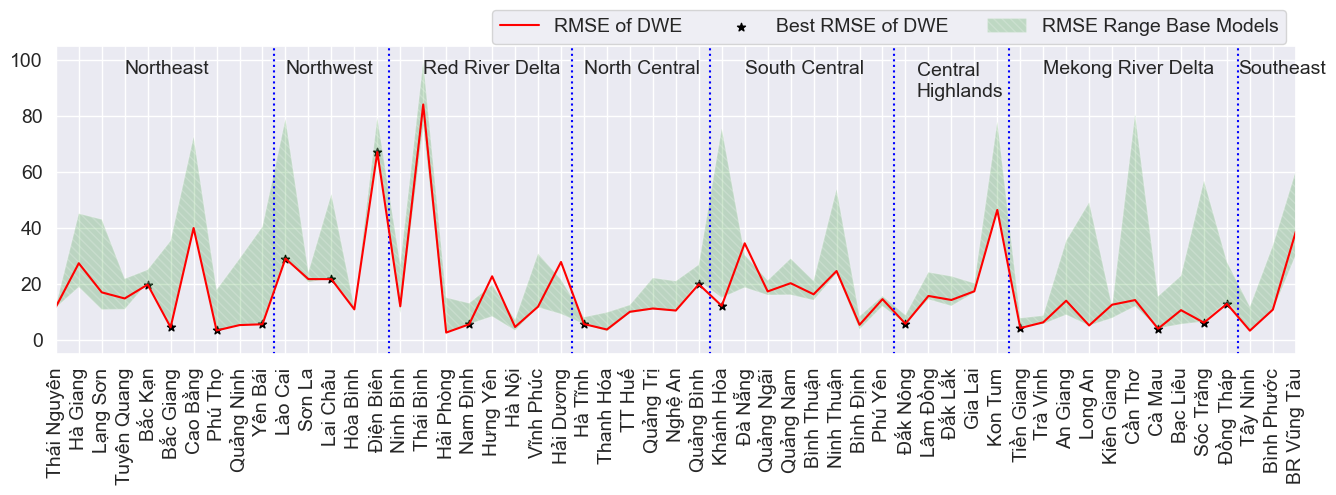

In [475]:
# Vẽ MCE, DWE, Base Model theo RMSE
ax  = vietnam_sort.loc[:,['DWE_RMSE']].plot(figsize=(16, 4),c='red')
plt.scatter(x= vietnam_sort['province'], y =vietnam_sort['smallest'],  marker='*',c='black')
plt.fill_between(x='province',y1='min',y2='max', facecolor='green', hatch='\\\\\\\\', alpha=0.2, interpolate=True, data=vietnam_sort)
plt.legend([ 'RMSE of DWE','Best RMSE of DWE','RMSE Range Base Models'],loc='best', bbox_to_anchor=(1, 1.15), shadow=False,ncol=5,fontsize=14)
ax.vlines([9.5, 14.5, 22.5, 28.5,36.5,41.5,51.5], -5, 105, color ="blue", linestyles ='dotted') 
plt.text(3,95,'Northeast', fontsize=14)
plt.text(10,95,'Northwest',fontsize=14)
plt.text(16,95,'Red River Delta',fontsize=14)
plt.text(23,95,'North Central',fontsize=14)
plt.text(30,95,'South Central',fontsize=14)
plt.text(37.5,87,'Central'+ '\n' +'Highlands',fontsize=14)
plt.text(43,95,'Mekong River Delta',fontsize=14)
plt.text(51.5,95,'Southeast',fontsize=14)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.margins(0,0)
plt.show()

# So sánh DWE với Best Based Model, group theo vùng. Vẽ range, group và best of DWE

In [ ]:
def rename_error_province_index(df):
    df['province'] = df['province'].replace(['Bà Rịa - Vũng Tàu', 'Bình Ðịnh','Hoà Bình','Khánh Hoà','Lâm Ðồng','Nam Ðịnh','Thừa Thiên Huế','Thanh Hoá','Ðiện Biên','Ðà Nẵng','Ðắk Lắk','Ðắk Nông','Ðồng Tháp'], 
                                            ['BR Vũng Tàu', 'Bình Định','Hòa Bình','Khánh Hòa','Lâm Đồng','Nam Định','TT Huế','Thanh Hóa','Điện Biên','Đà Nẵng','Đắk Lắk','Đắk Nông','Đồng Tháp'])
    
    return df
#Đọc phân nhóm tỉnh theo 5 khu vực
city_by_group= pd.read_excel('H:\\Store\\Research\\UIT\\PhD Research\\Dev Environment\\Tropical Diseases\\running\\data\\data_gov_statistics\\province_region.xlsx')
city_by_group = rename_error_province_index(df = city_by_group)
city_by_group.set_index('province',inplace=True)
# không có thành phố 'Bình Dương', 'Bắc Ninh', 'Bến Tre', 'Hà Nam', 'Hậu Giang','TP Hồ Chí Minh', 'Vĩnh Long', 'Đồng Nai'
sub_region_list = city_by_group['subregion'].unique()

# Alternatively, add subregion column to full dataset
def label_subregion(row):
    return city_by_group.loc[row['province'],'subregion']

def label_region(row):
    return city_by_group.loc[row['province'],'region']

merge_dwe_with_range_single.rename(columns = {'City':'province'}, inplace = True)
vietnam = merge_dwe_with_range_single.copy()

vietnam["subregion"] = vietnam.apply(label_subregion, axis = 1)
vietnam["region"] = vietnam.apply(label_region, axis = 1)

cat_sub_region_order = CategoricalDtype(
    [ 'Northeast', 'Northwest', 'Red River Delta','North Central Coast','South Central Coast', 'Central Highlands', 'Mekong River Delta','Southeast'], 
    ordered=True
)
vietnam['subregion'] = vietnam['subregion'].astype(cat_sub_region_order)
vietnam_sort = vietnam.sort_values('subregion').copy().reset_index(drop=True)
vietnam_sort.head()

province        min        max       mean   DWE_RMSE    DWE_MAE  \
0  Thái Nguyên  11.719281  12.257110  11.947988  11.946372  10.424885   
1     Hà Giang  19.043249  45.295769  30.754074  27.569082  21.751055   
2     Lạng Sơn  11.022939  43.222711  20.182432  17.168503  13.794636   
3  Tuyên Quang  11.115799  22.017025  17.251266  14.987638  12.158707   
4      Bắc Kạn  20.675316  25.230585  22.971207  19.941923  16.338526   

  Alg_name   MCE_RMSE    MCE_MAE   smallest  subregion region  
0      DWE  11.800845  10.324387        NaN  Northeast  North  
1      DWE  27.543148  21.738243        NaN  Northeast  North  
2      DWE  17.118279  13.899857        NaN  Northeast  North  
3      DWE  14.464171  11.479042        NaN  Northeast  North  
4      DWE  19.934361  16.427084  19.941923  Northeast  North

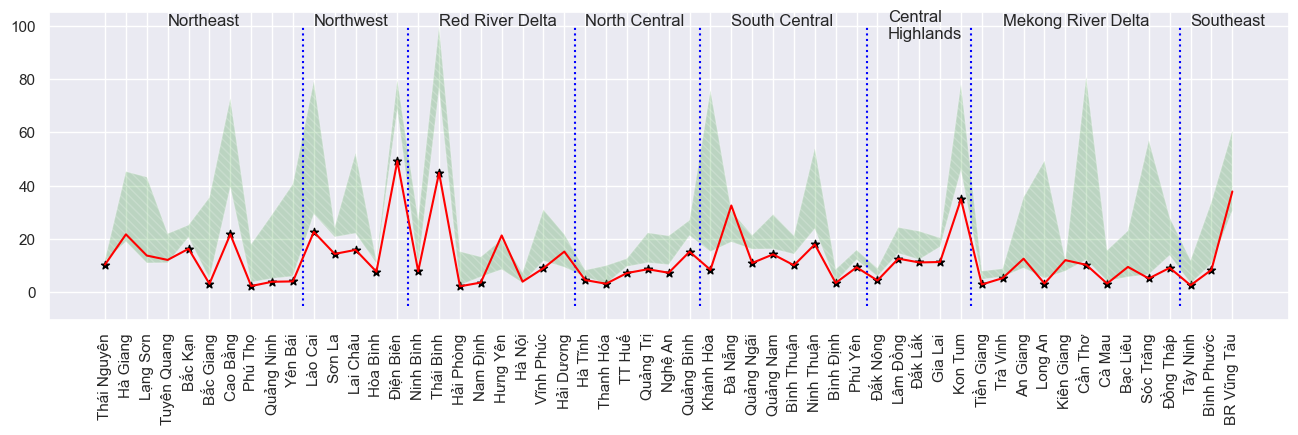

In [ ]:
vietnam_sort.loc[(vietnam_sort['DWE_MAE'] < vietnam_sort['min']), 'smallest'] = vietnam_sort['DWE_MAE']
ax  = vietnam_sort.plot.line( y='DWE_MAE', c='red',figsize=(16, 4),legend=False)
plt.scatter(x= vietnam_sort['province'], y =vietnam_sort['smallest'],  marker='*',c='black')
plt.fill_between(x='province',y1='min',y2='max', facecolor='green', hatch='\\\\\\\\', alpha=0.2, interpolate=True, data=vietnam_sort)
ax.vlines([9.5, 14.5, 22.5, 28.5,36.5,41.5,51.5], -5, 100, color ="blue", linestyles ='dotted') 
plt.text(3,100,'Northeast')
plt.text(10,100,'Northwest')
plt.text(16,100,'Red River Delta')
plt.text(23,100,'North Central')
plt.text(30,100,'South Central')
plt.text(37.5,95,'Central'+ '\n' +'Highlands')
plt.text(43,100,'Mekong River Delta')
plt.text(52,100,'Southeast')
plt.xticks(rotation=90)
plt.show()

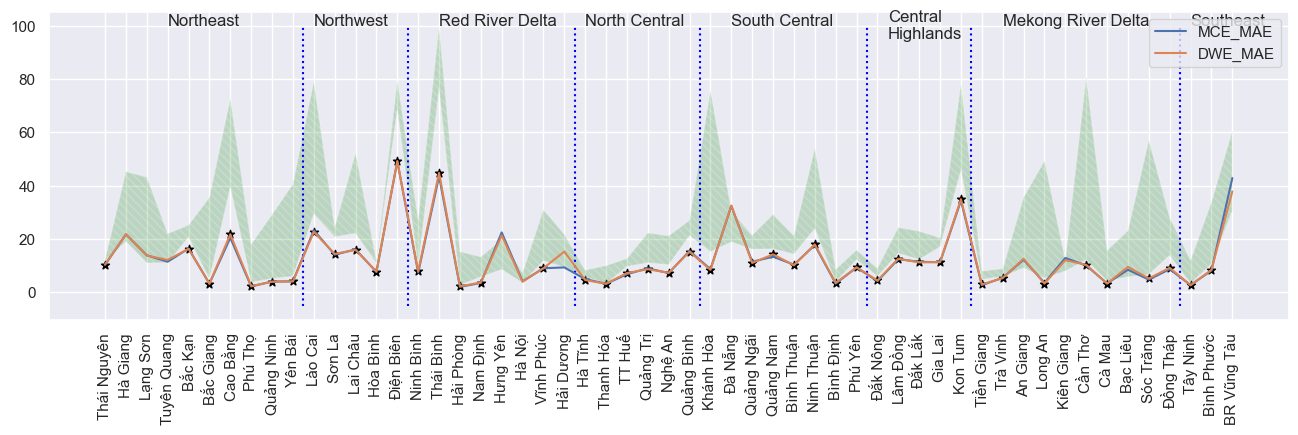

In [ ]:
vietnam_sort.loc[(vietnam_sort['DWE_MAE'] < vietnam_sort['min'])& (vietnam_sort['DWE_MAE'] <vietnam_sort['MCE_MAE']), 'smallest'] = vietnam_sort['DWE_MAE']

ax  = vietnam_sort.loc[:,['MCE_MAE','DWE_MAE']].plot.line(figsize=(16, 4)) 
plt.scatter(x= vietnam_sort['province'], y =vietnam_sort['smallest'],  marker='*',c='black')
plt.fill_between(x='province',y1='min',y2='max', facecolor='green', hatch='\\\\\\\\', alpha=0.2, interpolate=True, data=vietnam_sort)
ax.vlines([9.5, 14.5, 22.5, 28.5,36.5,41.5,51.5], -5, 100, color ="blue", linestyles ='dotted') 
plt.text(3,100,'Northeast')
plt.text(10,100,'Northwest')
plt.text(16,100,'Red River Delta')
plt.text(23,100,'North Central')
plt.text(30,100,'South Central')
plt.text(37.5,95,'Central'+ '\n' +'Highlands')
plt.text(43,100,'Mekong River Delta')
plt.text(52,100,'Southeast')
plt.xticks(rotation=90)
plt.show()

# Bảng xếp hạng DWE vs Deep learning theo MAE

In [385]:
dwe = pd.read_excel(result_path+'DWE_SVM.xlsx').drop(columns='Unnamed: 0')
dwe.rename(columns = {'Model Name':'Alg_name'}, inplace = True)
deep_and_dwe = pd.concat([
    # result_sarima,    
    result_cnn,
    result_lstm,
    result_tf,
    result_lstm_att,
    dwe
])
# best_base_models
rename_alg_name(deep_and_dwe)

pivot_deep_and_dwe = deep_and_dwe.pivot(index='City', columns='Alg_name', values='MAE_1-month').reset_index(drop=True)
ranked_pivot_deep_and_dwe = pivot_deep_and_dwe.rank(axis=1)
ranked_pivot_deep_and_dwe.mean(axis=0)


df_dwe = ranked_pivot_deep_and_dwe['DWE'].value_counts()
df_lstm_attention = ranked_pivot_deep_and_dwe['LSTM ATT'].value_counts()
df_lstm = ranked_pivot_deep_and_dwe['LSTM'].value_counts()
df_cnn = ranked_pivot_deep_and_dwe['CNN'].value_counts()
df_tf = ranked_pivot_deep_and_dwe['TF'].value_counts()
# df_sarima = ranked_deep_and_simple['SARIMA'].value_counts()

arr_rank = []
for i in range(1,6):   
    try:
        a = df_lstm[i]
    except KeyError:
        a = 0    
    try:
        b = df_lstm_attention[i]
    except KeyError:
        b = 0
    try:
        c = df_cnn[i]
    except KeyError:
        c = 0
    try:
        d = df_tf[i]
    except KeyError:
        d = 0
    try:
        e = df_dwe[i]
    except KeyError:
        e = 0    
    arr_rank.append([a,b,c,d,e])
df_rank_table = pd.DataFrame(data=arr_rank, columns=['LSTM','ATT','CNN', 'TF','DWE'])
df_rank_table

LSTM  ATT  CNN  TF  DWE
0    13   14    9   3   16
1    10   17   10   0   18
2    21    7   15   5    7
3     6   15   20   4   10
4     5    2    1  43    4

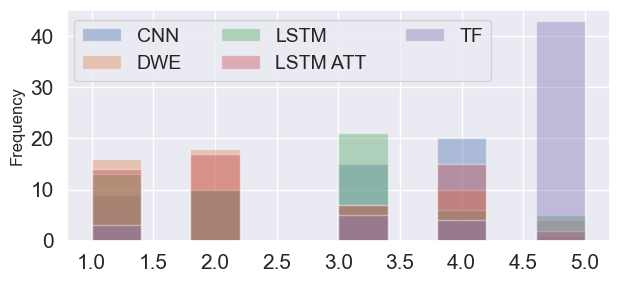

In [407]:
ax = ranked_pivot_deep_and_dwe.plot.hist(bins=10, alpha=0.4,)
plt.legend(loc='best', bbox_to_anchor=(0.8, 1), shadow=False,ncol=3, fontsize=14)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.show()

In [ ]:
ranked_pivot_deep_and_dwe.mean(axis=0)

Alg_name
CNN         2.890909
DWE         2.418182
LSTM        2.636364
LSTM ATT    2.527273
TF          4.527273
dtype: float64

In [ ]:
ranked_pivot_deep_and_dwe.median(axis=0)

Alg_name
CNN         3.0
DWE         2.0
LSTM        3.0
LSTM ATT    2.0
TF          5.0
dtype: float64

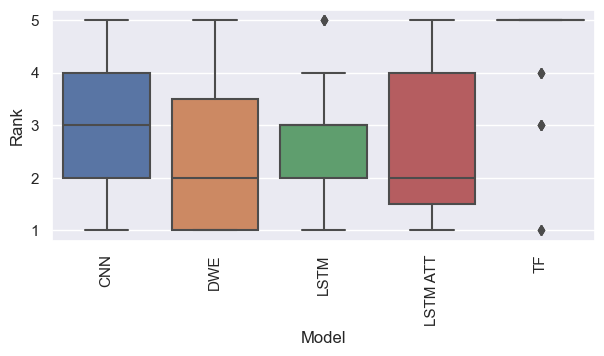

In [ ]:
melted_best_base_models_mae = pd.melt(ranked_pivot_deep_and_dwe)
ax = sns.boxplot(x='Alg_name', y='value', data=melted_best_base_models_mae)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel('Model')
plt.ylabel('Rank')
plt.show()

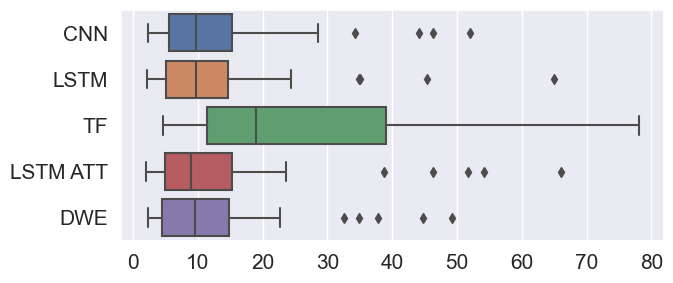

In [390]:
g = sns.boxplot(data=deep_and_dwe, x="MAE_1-month", y="Alg_name",)
plt.ylabel('')
plt.xlabel('')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show() # Plot MAE DWE

In [ ]:
data_single = deep_and_dwe.groupby('Alg_name')['MAE_1-month'].agg(['mean'])
data_single

mean
Alg_name           
CNN       12.573898
DWE       12.348394
LSTM      12.460072
LSTM ATT  13.161273
TF        26.467210

In [ ]:
data_single = deep_and_dwe.groupby('Alg_name')['RMSE_1-month'].agg(['mean'])
data_single

mean
Alg_name           
CNN       17.269185
DWE       16.907008
LSTM      17.027811
LSTM ATT  17.513797
TF        31.221760

# Bảng xếp hạng DWE vs Deep learning theo RMSE

In [ ]:
dwe = pd.read_excel(result_path+'DWE_SVM.xlsx').drop(columns='Unnamed: 0')
dwe.rename(columns = {'Model Name':'Alg_name'}, inplace = True)
deep_and_dwe = pd.concat([
    # result_sarima,    
    result_cnn,
    result_lstm,
    result_tf,
    result_lstm_att,
    dwe
])
# best_base_models
rename_alg_name(deep_and_dwe)

pivot_deep_and_dwe = deep_and_dwe.pivot(index='City', columns='Alg_name', values='RMSE_1-month').reset_index(drop=True)
ranked_pivot_deep_and_dwe = pivot_deep_and_dwe.rank(axis=1)
ranked_pivot_deep_and_dwe.mean(axis=0)


df_dwe = ranked_pivot_deep_and_dwe['DWE'].value_counts()
df_lstm_attention = ranked_pivot_deep_and_dwe['LSTM ATT'].value_counts()
df_lstm = ranked_pivot_deep_and_dwe['LSTM'].value_counts()
df_cnn = ranked_pivot_deep_and_dwe['CNN'].value_counts()
df_tf = ranked_pivot_deep_and_dwe['TF'].value_counts()
# df_sarima = ranked_deep_and_simple['SARIMA'].value_counts()

arr_rank = []
for i in range(1,6):   
    try:
        a = df_lstm[i]
    except KeyError:
        a = 0    
    try:
        b = df_lstm_attention[i]
    except KeyError:
        b = 0
    try:
        c = df_cnn[i]
    except KeyError:
        c = 0
    try:
        d = df_tf[i]
    except KeyError:
        d = 0
    try:
        e = df_dwe[i]
    except KeyError:
        e = 0    
    arr_rank.append([a,b,c,d,e])
df_rank_table = pd.DataFrame(data=arr_rank, columns=['LSTM','ATT','CNN', 'TF','DWE'])
df_rank_table

LSTM  ATT  CNN  TF  DWE
0    12   15   10   2   16
1     9   18   11   1   16
2    19    8   14   2   12
3    10   12   18   8    7
4     5    2    2  42    4

In [ ]:
ranked_pivot_deep_and_dwe.mean(axis=0)

Alg_name
CNN         2.836364
DWE         2.400000
LSTM        2.763636
LSTM ATT    2.418182
TF          4.581818
dtype: float64

In [ ]:
ranked_pivot_deep_and_dwe.median(axis=0)

Alg_name
CNN         3.0
DWE         2.0
LSTM        3.0
LSTM ATT    2.0
TF          5.0
dtype: float64

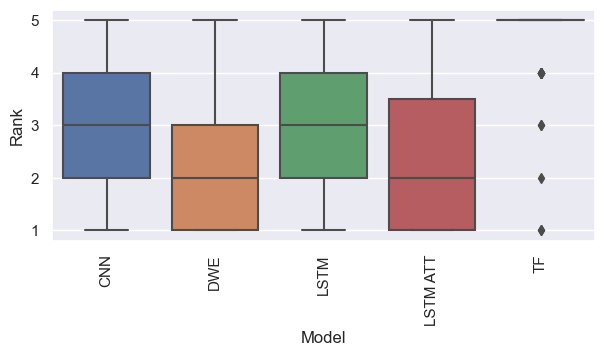

In [ ]:
melted_best_base_models_rmse = pd.melt(ranked_pivot_deep_and_dwe)
ax = sns.boxplot(x='Alg_name', y='value', data=melted_best_base_models_rmse)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel('Model')
plt.ylabel('Rank')
plt.show()

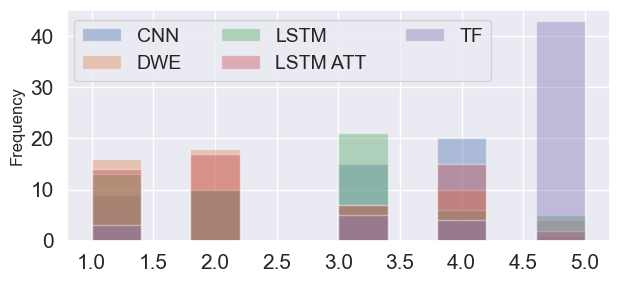

In [406]:
ax = ranked_pivot_deep_and_dwe.plot.hist(bins=10, alpha=0.4,)
plt.legend(loc='best', bbox_to_anchor=(0.8, 1), shadow=False,ncol=3, fontsize=14)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.show()

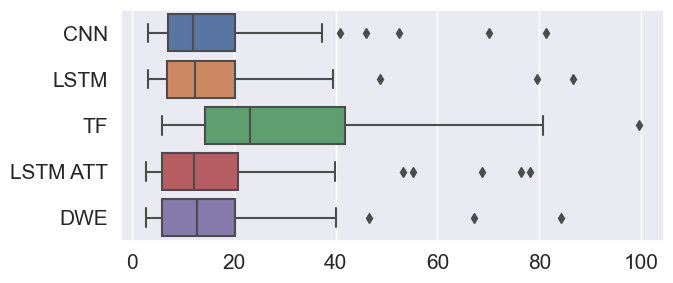

In [391]:
g = sns.boxplot(data=deep_and_dwe, x="RMSE_1-month", y="Alg_name",)
plt.ylabel('')
plt.xlabel('')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show() #Plot RMSE DWE

# Vẽ Range của 44/5 combination 1997-2018. vs DWE MCE

In [ ]:
# Lấy top N MCE của 1997 -2015
prj_path = 'H:\\Store\\Research\\UIT\\PhD Research\\Dev Environment\\Tropical Diseases\\running\\'
path_simple_result_2015 =      prj_path+ 'results\\ensemble\\result\\simple_combination_4_model_2015_mae\\all_combinations_metrics_1.xlsx'

df_result_simple_2015 = pd.read_excel(path_simple_result_2015)

df_result_simple_2015 = df_result_simple_2015.loc[:,["City","Meta_Model_Name","Based_Models",'MAE_1-month','RMSE_1-month']]
df_result_simple_2015['Model Name'] = df_result_simple_2015['Meta_Model_Name']+'*'+ df_result_simple_2015['Based_Models']
# df_result_simple_2015 = df_result_simple_2015.loc[:,["City","RMSE_1-month","Model Name"]]
df_result_simple_2015 = df_result_simple_2015.loc[:,["City","MAE_1-month",'RMSE_1-month',"Model Name"]]
df_result_simple_2015 = df_result_simple_2015.sort_values(by = ['MAE_1-month'], ascending=True).groupby(['City','Model Name']).head(1)

# Get n_top theo MAE cố định cho tất cả thành phố
def get_n_top_in(df_combination ='', n_best =3):
    model_group_mean = df_combination.groupby(['Model Name'],as_index = False).mean()
    return model_group_mean.sort_values(by='MAE_1-month',ascending=True).head(n_best).reset_index(drop=True)
top_n_of_simple_2015 = get_n_top_in (df_combination= df_result_simple_2015, n_best =5 )
top_n_of_simple_2015

Model Name  MAE_1-month  RMSE_1-month
0            CNN*lstm_att_pred-lstm_pred-Observed    11.328251     15.574516
1                  CNN*lstm_pred-tf_pred-Observed    11.400709     15.948655
2  LSTM*cnn_pred-lstm_att_pred-lstm_pred-Observed    11.584173     16.097987
3           LSTM*lstm_att_pred-lstm_pred-Observed    11.759275     15.995275
4    CNN*lstm_att_pred-lstm_pred-tf_pred-Observed    11.762028     16.035659

In [ ]:
# Lấy kết quả MCE của 44 combination 1997 -2018
prj_path_result_simple_ensemple_2018 = 'H:\\Store\\Research\\UIT\\PhD Research\\Dev Environment\\Tropical Diseases\\running\\eval_result\\MLJ 2023\\44 combination 1997 2018 MAE\\'

df_simple_ensemble_2018 = pd.read_excel(prj_path_result_simple_ensemple_2018+'all_combinations_metrics_1.xlsx')
df_simple_ensemble_2018 = df_simple_ensemble_2018.loc[:,["City","Meta_Model_Name","Based_Models",'RMSE_1-month','MAE_1-month']]
# Không sort và lấy best result trong mỗi city. vì filter dùng df_result_simple_2015
df_simple_ensemble_2018['Model Name'] = df_simple_ensemble_2018['Meta_Model_Name']+'*'+ df_simple_ensemble_2018['Based_Models']
df_simple_ensemble_2018.head()

City Meta_Model_Name                     Based_Models  RMSE_1-month  \
0  Cần Thơ             CNN  cnn_pred-lstm_att_pred-Observed     17.125778   
1  Cần Thơ            LSTM  cnn_pred-lstm_att_pred-Observed     15.432916   
2  Cần Thơ        LSTM_ATT  cnn_pred-lstm_att_pred-Observed     14.554643   
3  Cần Thơ              TF  cnn_pred-lstm_att_pred-Observed     83.617940   
4  Gia Lai             CNN  cnn_pred-lstm_att_pred-Observed     17.722701   

   MAE_1-month                                Model Name  
0    14.025827       CNN*cnn_pred-lstm_att_pred-Observed  
1    12.163916      LSTM*cnn_pred-lstm_att_pred-Observed  
2    12.450776  LSTM_ATT*cnn_pred-lstm_att_pred-Observed  
3    81.014907        TF*cnn_pred-lstm_att_pred-Observed  
4    11.566020       CNN*cnn_pred-lstm_att_pred-Observed

In [ ]:
# Lấy top N giải thuật đã chọn lựa 1997-2018
convert_simple_2015_to_2018 = df_simple_ensemble_2018.merge(top_n_of_simple_2015[['Model Name']], on=['Model Name'])
convert_simple_2015_to_2018

City Meta_Model_Name                              Based_Models  \
0      Cần Thơ             CNN          lstm_att_pred-lstm_pred-Observed   
1      Gia Lai             CNN          lstm_att_pred-lstm_pred-Observed   
2     Hà Giang             CNN          lstm_att_pred-lstm_pred-Observed   
3       Hà Nội             CNN          lstm_att_pred-lstm_pred-Observed   
4      Hà Tĩnh             CNN          lstm_att_pred-lstm_pred-Observed   
..         ...             ...                                       ...   
270   Bạc Liêu             CNN  lstm_att_pred-lstm_pred-tf_pred-Observed   
271    Bắc Kạn             CNN  lstm_att_pred-lstm_pred-tf_pred-Observed   
272  Bắc Giang             CNN  lstm_att_pred-lstm_pred-tf_pred-Observed   
273   Cao Bằng             CNN  lstm_att_pred-lstm_pred-tf_pred-Observed   
274     Cà Mau             CNN  lstm_att_pred-lstm_pred-tf_pred-Observed   

     RMSE_1-month  MAE_1-month                                    Model Name  
0       18.935744    12.305959          CNN*lstm_att_pred-lstm_pred-Observed  
1       18.539846    12.175095          CNN*lstm_att_pred-lstm_pred-Observed  
2       28.990559    23.956364          CNN*lstm_att_pred-lstm_pred-Observed  
3        7.803750     6.498362          CNN*lstm_att_pred-lstm_pred-Observed  
4        6.579801     5.488677          CNN*lstm_att_pred-lstm_pred-Observed  
..            ...          ...                                           ...  
270     12.520175    11.019181  CNN*lstm_att_pred-lstm_pred-tf_pred-Observed  
271     21.408719    17.828718  CNN*lstm_att_pred-lstm_pred-tf_pred-Observed  
272      4.684959     3.386054  CNN*lstm_att_pred-lstm_pred-tf_pred-Observed  
273     39.135665    20.853972  CNN*lstm_att_pred-lstm_pred-tf_pred-Observed  
274      4.740917     3.650547  CNN*lstm_att_pred-lstm_pred-tf_pred-Observed  

[275 rows x 6 columns]

In [ ]:
range_mce_2018 = df_simple_ensemble_2018.groupby('City')['MAE_1-month'].agg(['min', 'max','mean'])
range_mce_2018.reset_index(inplace=True)
# range_mce_2018_sorted = range_mce_2018.sort_values(by='City', ascending=False)

range_top_N_mce = convert_simple_2015_to_2018.groupby('City')['MAE_1-month'].agg(['min', 'max','mean'])
range_top_N_mce.reset_index(inplace=True)
# range_top_N_mce_sorted = range_top_N_mce.sort_values(by='City', ascending=False)

In [ ]:
def rename_error_province_index(df):
    df['province'] = df['province'].replace(['Bà Rịa - Vũng Tàu', 'Bình Ðịnh','Hoà Bình','Khánh Hoà','Lâm Ðồng','Nam Ðịnh','Thừa Thiên Huế','Thanh Hoá','Ðiện Biên','Ðà Nẵng','Ðắk Lắk','Ðắk Nông','Ðồng Tháp'], 
                                            ['BR Vũng Tàu', 'Bình Định','Hòa Bình','Khánh Hòa','Lâm Đồng','Nam Định','TT Huế','Thanh Hóa','Điện Biên','Đà Nẵng','Đắk Lắk','Đắk Nông','Đồng Tháp'])
    
    return df
#Đọc phân nhóm tỉnh theo 5 khu vực
city_by_group= pd.read_excel('H:\\Store\\Research\\UIT\\PhD Research\\Dev Environment\\Tropical Diseases\\running\\data\\data_gov_statistics\\province_region.xlsx')
city_by_group = rename_error_province_index(df = city_by_group)
city_by_group.set_index('province',inplace=True)
# không có thành phố 'Bình Dương', 'Bắc Ninh', 'Bến Tre', 'Hà Nam', 'Hậu Giang','TP Hồ Chí Minh', 'Vĩnh Long', 'Đồng Nai'
sub_region_list = city_by_group['subregion'].unique()

# Alternatively, add subregion column to full dataset
def label_subregion(row):
    return city_by_group.loc[row['province'],'subregion']

def label_region(row):
    return city_by_group.loc[row['province'],'region']
cat_sub_region_order = CategoricalDtype(
    [ 'Northeast', 'Northwest', 'Red River Delta','North Central Coast','South Central Coast', 'Central Highlands', 'Mekong River Delta','Southeast'], 
    ordered=True
)

In [ ]:
range_top_N_mce.rename(columns = {'City':'province'}, inplace = True)
range_top_N_mce["subregion"] = range_top_N_mce.apply(label_subregion, axis = 1)
range_top_N_mce["region"] = range_top_N_mce.apply(label_region, axis = 1)

range_top_N_mce['subregion'] = range_top_N_mce['subregion'].astype(cat_sub_region_order)
range_top_N_mce_final = range_top_N_mce.sort_values('subregion').copy().reset_index(drop=True)
range_top_N_mce_final.tail()

province        min        max       mean           subregion region
50    Sóc Trăng   4.330178   7.271550   5.801641  Mekong River Delta  South
51    Đồng Tháp   9.715655  11.599840  10.924221  Mekong River Delta  South
52     Tây Ninh   2.572953   3.412513   2.907021           Southeast  South
53   Bình Phước   7.939613   9.656345   8.771281           Southeast  South
54  BR Vũng Tàu  27.859456  62.168348  42.858768           Southeast  South

In [ ]:
range_mce_2018.rename(columns = {'City':'province'}, inplace = True)
range_mce_2018["subregion"] = range_mce_2018.apply(label_subregion, axis = 1)
range_mce_2018["region"] = range_mce_2018.apply(label_region, axis = 1)

range_mce_2018['subregion'] = range_mce_2018['subregion'].astype(cat_sub_region_order)
range_mce_2018_final = range_mce_2018.sort_values('subregion').copy().reset_index(drop=True)
range_mce_2018_final.tail()

province        min        max       mean           subregion region
50    Sóc Trăng   3.997598  79.836337  21.614397  Mekong River Delta  South
51    Đồng Tháp   8.886192  52.550005  19.601677  Mekong River Delta  South
52     Tây Ninh   2.424654  22.661319   7.107945           Southeast  South
53   Bình Phước   6.216665  42.602104  15.514548           Southeast  South
54  BR Vũng Tàu  20.031213  66.846806  49.186872           Southeast  South

In [ ]:
dwe = pd.read_excel(result_path+'DWE_SVM.xlsx').drop(columns='Unnamed: 0')
dwe.rename(columns = {'City':'province'}, inplace = True)
dwe.head()

province  RMSE_1-month  MAE_1-month Model Name
0     An Giang     14.186441    12.614244        DWE
1  BR Vũng Tàu     38.856552    37.823752        DWE
2   Bình Phước     10.997809     8.445490        DWE
3   Bình Thuận     16.474459    10.145264        DWE
4    Bình Định      5.582184     3.531021        DWE

In [ ]:
merge_dwe_with_top_N_mce = range_top_N_mce_final.merge(dwe,on ='province')
merge_dwe_with_top_N_mce.rename(columns = {'RMSE_1-month':'DWE_RMSE','MAE_1-month':'DWE_MAE'}, inplace = True)
merge_dwe_with_top_N_mce.drop(columns=['Model Name'], inplace=True)
merge_dwe_with_top_N_mce.head()
dwe_topN = merge_dwe_with_top_N_mce.copy()
dwe_topN.rename(columns = {'min':'min_topN'}, inplace = True)
dwe_topN_44 = range_mce_2018_final.merge(dwe_topN,on ='province')
dwe_topN_44.rename(columns = {'min':'min_44'}, inplace = True)
dwe_topN_44.loc[(dwe_topN_44['DWE_MAE'] < dwe_topN_44['min_44']) & (dwe_topN_44['DWE_MAE'] <dwe_topN_44['min_topN']) , 'smallest'] = dwe_topN_44['DWE_MAE']
dwe_topN_44.loc[(dwe_topN_44['DWE_MAE'] < dwe_topN_44['min_topN']) , 'smallest_2'] = dwe_topN_44['DWE_MAE']

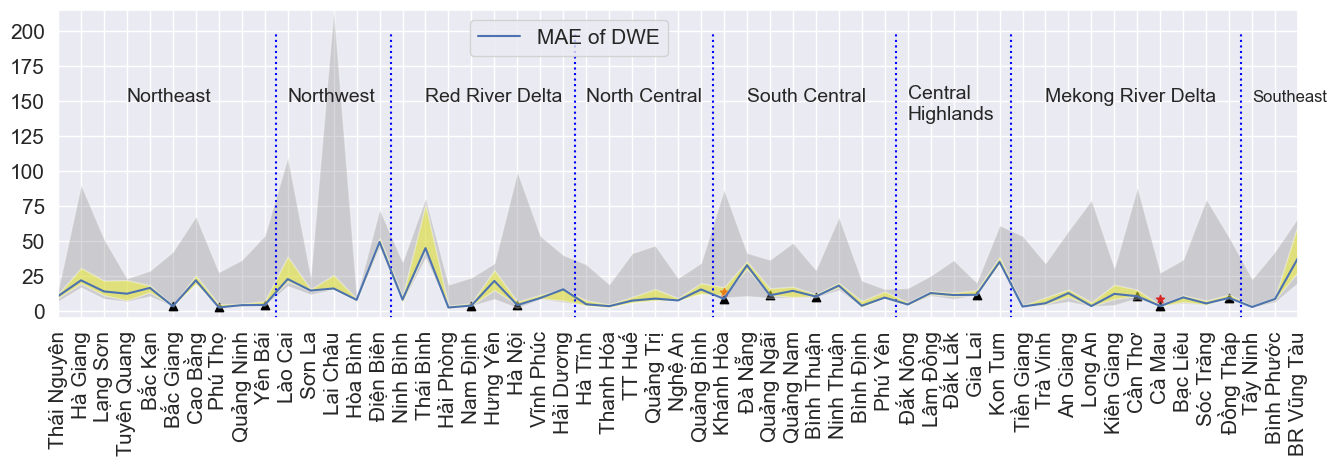

In [424]:
# fig, ax = plt.subplots(figsize=(16, 4))
test = merge_dwe_with_top_N_mce.merge(vietnam_sort.loc[:,['province','MCE_MAE']], on='province')
ax = test.loc[:,['DWE_MAE']].plot(figsize=(16, 4))
# ax.set_facecolor("white")
plt.legend(['MAE of DWE'],loc='best', bbox_to_anchor=(0.5, 1), shadow=False,ncol=5, fontsize =15)
plt.scatter(x= dwe_topN_44['province'], y =dwe_topN_44['smallest']+5,  marker='*',c='red')
plt.scatter(x= dwe_topN_44['province'], y =dwe_topN_44['smallest_2'],  marker='^',c='black')
plt.fill_between(x='province',y1='min',y2='max', facecolor='gray', alpha=0.3, interpolate=True, data=range_mce_2018_final)
plt.fill_between(x='province',y1='min',y2='max', facecolor='yellow', alpha=0.4, interpolate=True, data=range_top_N_mce_final)
ax.vlines([9.5, 14.5, 22.5, 28.5,36.5,41.5,51.5], -5, 200, color ="blue", linestyles ='dotted') 
plt.text(3,150,'Northeast',fontsize=14)
plt.text(10,150,'Northwest',fontsize=14)
plt.text(16,150,'Red River Delta',fontsize=14)
plt.text(23,150,'North Central',fontsize=14)
plt.text(30,150,'South Central',fontsize=14)
plt.text(37,137,'Central'+ '\n' +'Highlands',fontsize=14)
plt.text(43,150,'Mekong River Delta',fontsize=14)
plt.text(52,150,'Southeast',fontsize=12)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig(prj_path + '\\Figures\\mae_searching_space_DWE.png', dpi=600)
plt.margins(0,0)
plt.show()

# Vẽ range của 44/5/7 combination trên 1 tỉnh

In [488]:
com_path_climate_weighted_result_linearSVR = 'H:\\Store\\Research\\UIT\\PhD Research\\Dev Environment\\Tropical Diseases\\running\\'+ 'results\\ensemble\\'+ 'result\\weighted_combination\\predicted_result\\linearSVR\\'
dict_DWE_all = {}
df_DWE_all = pd.DataFrame()
for city in cities:
    weighted_final_result = pd.read_excel(com_path_climate_weighted_result_linearSVR+city+'_weighted_predict_4_com.xlsx')
    weighted_final_result.drop(columns='Unnamed: 0', inplace=True)
    weighted_final_result['MCE'] = weighted_final_result.iloc[:,0:5].mean(axis=1)
    weighted_final_result['min'] = weighted_final_result.iloc[:,0:5].min(axis=1)
    weighted_final_result['max'] = weighted_final_result.iloc[:,0:5].max(axis=1) 
    weighted_final_result.rename(columns = {'Weighted_Predict':'DWE','MAE_Weighted_Predict':'MAE_DWE','RMSE_Weighted_Predict':'RMSE_DWE'}, inplace = True)
    df_DWE_all = pd.concat([df_DWE_all,weighted_final_result])
    dict_DWE_all[city] = weighted_final_result
    

In [489]:
# Lấy preidiction của 55 tỉnh trên 44 giải thuật
################################################ 

# Lấy kết quả MCE của 44 combination 1997 -2018
prj_path_result_simple_ensemple_2018 = 'H:\\Store\\Research\\UIT\\PhD Research\\Dev Environment\\Tropical Diseases\\running\\eval_result\\MLJ 2023\\44 combination 1997 2018 MAE\\'

df_simple_ensemble_2018 = pd.read_excel(prj_path_result_simple_ensemple_2018+'all_combinations_1.xlsx')
df_simple_ensemble_2018 = df_simple_ensemble_2018.loc[:,["City","Meta_Model_Name","Based_Models",'1-month','RMSE_1-month','MAE_1-month']]
# Không sort và lấy best result trong mỗi city. vì filter dùng df_result_simple_2015
df_simple_ensemble_2018['Model Name'] = df_simple_ensemble_2018['Meta_Model_Name']+'*'+ df_simple_ensemble_2018['Based_Models']


In [503]:
combs_features = [('cnn_pred', 'lstm_att_pred'),
 ('cnn_pred', 'lstm_pred'),
 ('cnn_pred', 'tf_pred'),
 ('lstm_att_pred', 'lstm_pred'),
 ('lstm_att_pred', 'tf_pred'),
 ('lstm_pred', 'tf_pred'),
 ('cnn_pred', 'lstm_att_pred', 'lstm_pred'),
 ('cnn_pred', 'lstm_att_pred', 'tf_pred'),
 ('cnn_pred', 'lstm_pred', 'tf_pred'),
 ('lstm_att_pred', 'lstm_pred', 'tf_pred'),
 ('cnn_pred', 'lstm_att_pred', 'lstm_pred', 'tf_pred')]

In [504]:
combs_features

[('cnn_pred', 'lstm_att_pred'),
 ('cnn_pred', 'lstm_pred'),
 ('cnn_pred', 'tf_pred'),
 ('lstm_att_pred', 'lstm_pred'),
 ('lstm_att_pred', 'tf_pred'),
 ('lstm_pred', 'tf_pred'),
 ('cnn_pred', 'lstm_att_pred', 'lstm_pred'),
 ('cnn_pred', 'lstm_att_pred', 'tf_pred'),
 ('cnn_pred', 'lstm_pred', 'tf_pred'),
 ('lstm_att_pred', 'lstm_pred', 'tf_pred'),
 ('cnn_pred', 'lstm_att_pred', 'lstm_pred', 'tf_pred')]

In [505]:
# Danh sách các based Model và các Combination có thể của nó
# list_based_model = ['cnn_pred','lstm_att_pred','lstm_pred','tf_pred']

# combs_features = list(combinations(list_based_model[0:], 2)) + list(combinations(list_based_model[0:], 3)) + list(combinations(list_based_model[0:], 4))

# # list_based_model = ['cnn_pred','lstm_att_pred','lstm_pred','tf_pred']

# # combs_features = list(combinations(list_based_model[0:], 3)) 
combs_features = [('cnn_pred', 'lstm_att_pred'),
 ('cnn_pred', 'lstm_pred'),
 ('cnn_pred', 'tf_pred'),
 ('lstm_att_pred', 'lstm_pred'),
 ('lstm_att_pred', 'tf_pred'),
 ('lstm_pred', 'tf_pred'),
 ('cnn_pred', 'lstm_att_pred', 'lstm_pred'),
 ('cnn_pred', 'lstm_att_pred', 'tf_pred'),
 ('cnn_pred', 'lstm_pred', 'tf_pred'),
 ('lstm_att_pred', 'lstm_pred', 'tf_pred'),
 ('cnn_pred', 'lstm_att_pred', 'lstm_pred', 'tf_pred')]

selected_combs = []
for item in combs_features:
    con = '-'.join(item)
    selected_combs.append('CNN*'+con +'-Observed' )
    selected_combs.append('LSTM*'+con +'-Observed' )
    selected_combs.append('LSTM_ATT*'+con +'-Observed' )
    # selected_combs.append('TF*'+con +'-Observed' ) # bỏ đi cho đẹp, vì TF toàn số bự
    
def get_dict_simple_comb_all_cities(df_all=''):
    dict_simple_comb_all_cities = {}    
    for city in cities:    
        df_predicted_simple = pd.DataFrame()
        for item in selected_combs:
            simple_combination_city = pd.DataFrame()
            algo_strings = item.split('*')
            simple_combination_city = df_all.loc[(df_all['City'] == city) & (df_all['Meta_Model_Name'] == algo_strings[0]) & (df_all['Based_Models'] == algo_strings[1])]
            simple_combination_city = simple_combination_city.reset_index(drop=True) 
            #df_predicted_simple chứa dự báo của từng giải thuật combination 
            df_predicted_simple[item] = simple_combination_city['1-month']
            # df_predicted_simple[item+'_rmse'] = simple_combination_city['RMSE_1-month']        
        
        df_predicted_simple['mean_44'] = df_predicted_simple.iloc[:,0:44].mean(axis=1)
        df_predicted_simple['min_44'] = df_predicted_simple.iloc[:,0:44].min(axis=1)
        df_predicted_simple['max_44'] = df_predicted_simple.iloc[:,0:44].max(axis=1) +30 # Thay thế cho TF ngoại lệ
        dict_simple_comb_all_cities[city] = df_predicted_simple       

    return dict_simple_comb_all_cities

dict_simple_comb_all_cities = get_dict_simple_comb_all_cities(df_simple_ensemble_2018)

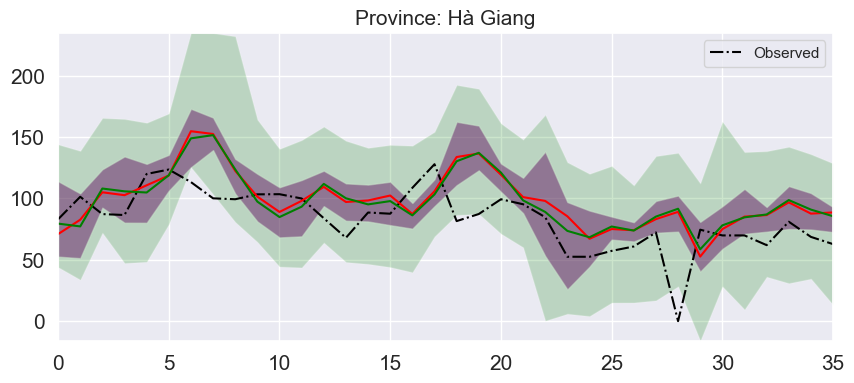

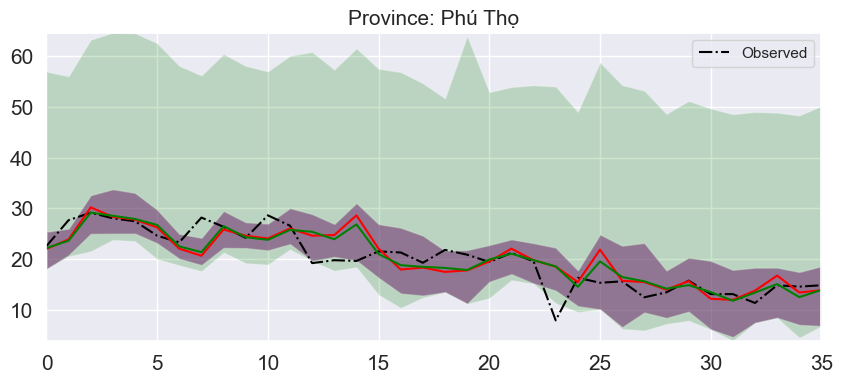

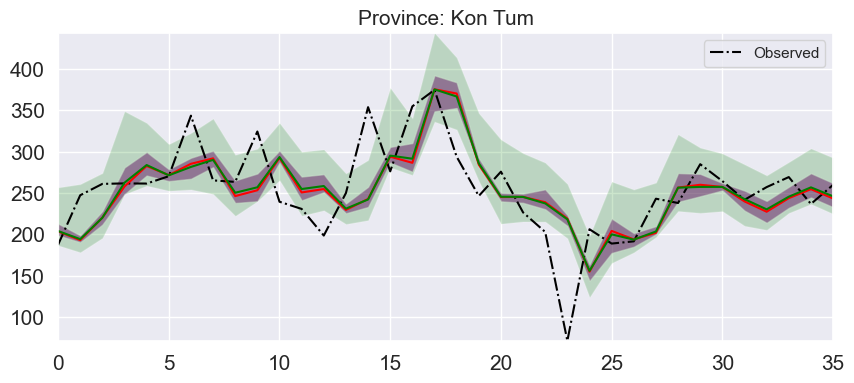

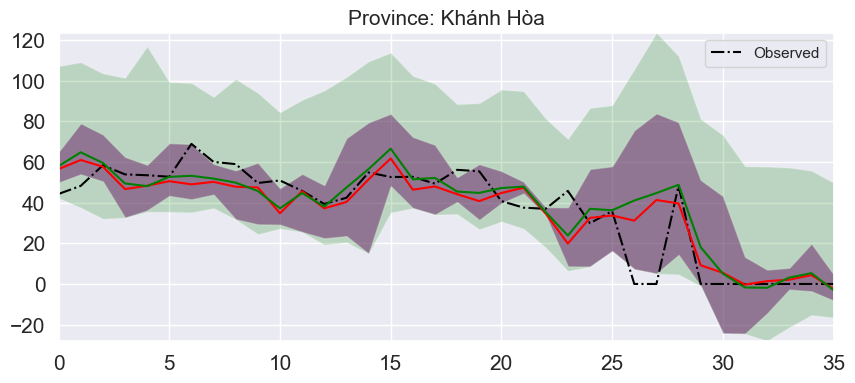

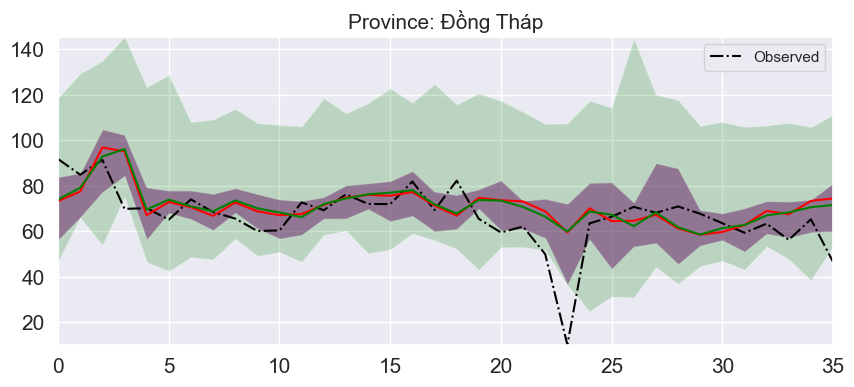

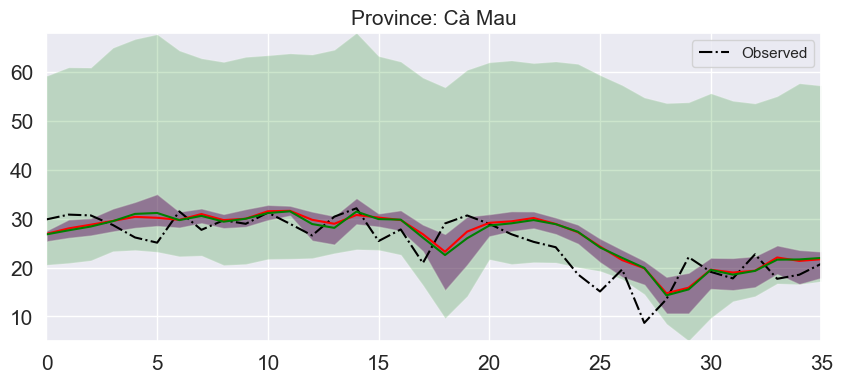

In [529]:
# cities = ['An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
#         'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
#         'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh', 'Hòa Bình',
#         'Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
#         'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
#         'Lạng Sơn', 'Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
#         'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
#         'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
#         'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
#         'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
#          'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp']

list_city = ['Hà Giang','Phú Thọ','Kon Tum','Khánh Hòa','Đồng Tháp','Cà Mau']
for city in list_city:
    one_city_44 = dict_simple_comb_all_cities[city].reset_index(drop=True)
    one_province = dict_DWE_all[city]
    ax = one_province.loc[:,['Observed']].plot(figsize=(10, 4), color ="black",linestyle='dashdot')
    ax.plot(one_province.loc[:,['DWE']], label='DWE', color='red')
    ax.plot(one_province.loc[:,['MCE']], label='MCE', color='green')    
    plt.fill_between(x=one_province.index,y1='min',y2='max', label='Range Top 5', facecolor='purple', alpha=0.5, interpolate=True, data=one_province)
    plt.fill_between(x=one_province.index,y1='min_44',y2='max_44', label='Range 44 Combinations',facecolor='green', alpha=0.2, interpolate=True, data=one_city_44)
    # plt.legend(['Observed','DWE','MCE','Range Top 5','Range 44 Combinations'],loc='best', bbox_to_anchor=(1, 2), shadow=False,ncol=5, fontsize =14)
    # plt.legend("")
    plt.title('Province: '+city, fontsize=17)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.margins(0,0)
    plt.show()

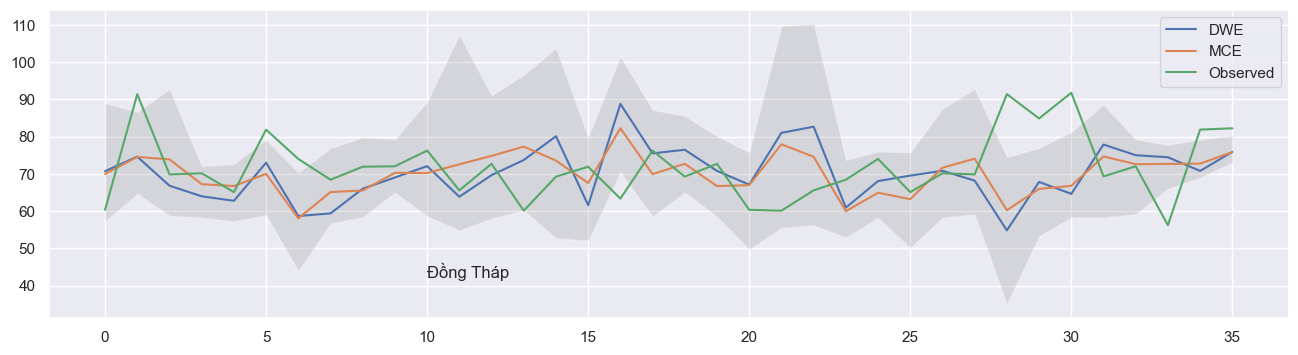

In [ ]:
one_province = dict_DWE_all['Đồng Tháp']
ax = one_province.loc[:,['DWE','MCE','Observed']].plot(figsize=(16, 4))
plt.fill_between(x=one_province.index,y1='min',y2='max', facecolor='gray', alpha=0.2, interpolate=True, data=one_province)
plt.text(10,42,'Đồng Tháp')
plt.show()

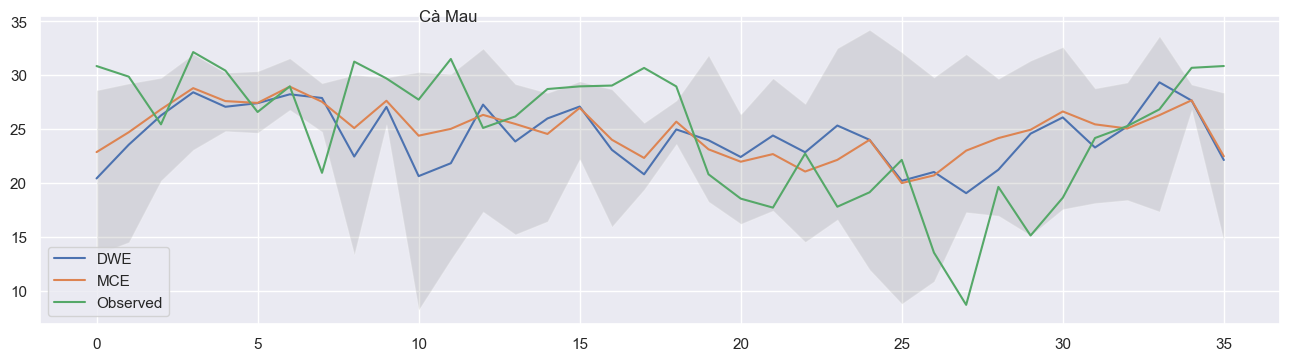

In [ ]:
one_province = dict_DWE_all['Cà Mau']
ax = one_province.loc[:,['DWE','MCE','Observed']].plot(figsize=(16, 4))
plt.fill_between(x=one_province.index,y1='min',y2='max', facecolor='gray', alpha=0.2, interpolate=True, data=one_province)
plt.text(10,35,'Cà Mau')
plt.show()

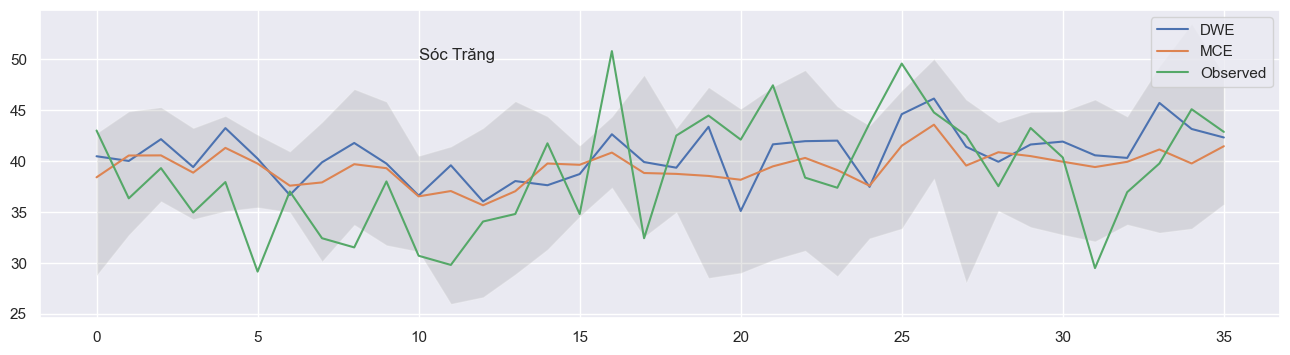

In [ ]:
one_province = dict_DWE_all['Sóc Trăng']
ax = one_province.loc[:,['DWE','MCE','Observed']].plot(figsize=(16, 4))
plt.fill_between(x=one_province.index,y1='min',y2='max', facecolor='gray', alpha=0.2, interpolate=True, data=one_province)
plt.text(10,50,'Sóc Trăng')
plt.show()

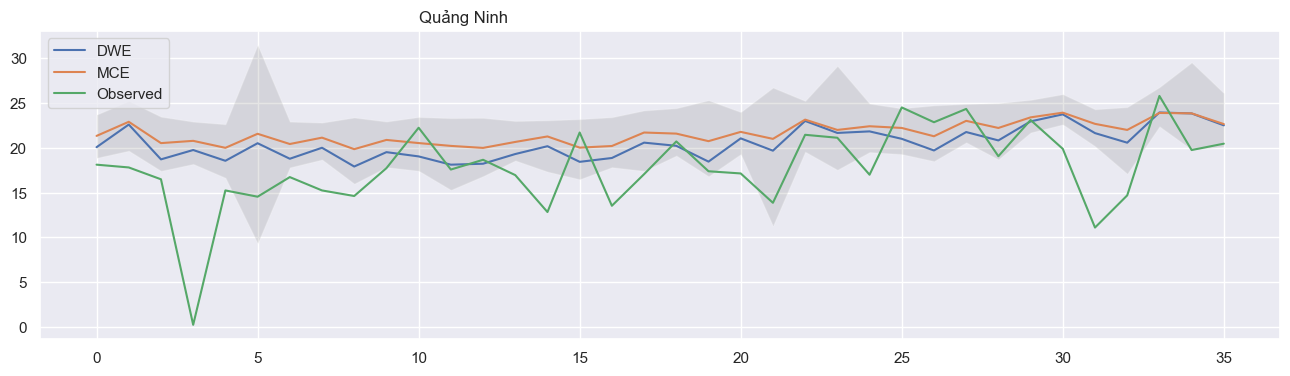

In [ ]:
one_province = dict_DWE_all['Quảng Ninh']
ax = one_province.loc[:,['DWE','MCE','Observed']].plot(figsize=(16, 4))
plt.fill_between(x=one_province.index,y1='min',y2='max', facecolor='gray', alpha=0.2, interpolate=True, data=one_province)
plt.text(10,34,'Quảng Ninh')
plt.show()

# DWE outbreak

In [426]:
# Lấy kết quả dự báo của DWE
com_path_climate_weighted_result_linearSVR = 'H:\\Store\\Research\\UIT\\PhD Research\\Dev Environment\\Tropical Diseases\\running\\'+ 'results\\ensemble\\'+ 'result\\weighted_combination\\predicted_result\\linearSVR\\'
dict_DWE_all = {}
df_DWE_all = pd.DataFrame()
for city in cities:
    weighted_final_result = pd.read_excel(com_path_climate_weighted_result_linearSVR+city+'_weighted_predict_4_com.xlsx')
    weighted_final_result.drop(columns='Unnamed: 0', inplace=True)    
    weighted_final_result.rename(columns = {'Weighted_Predict':'DWE','MAE_Weighted_Predict':'MAE_DWE','RMSE_Weighted_Predict':'RMSE_DWE'}, inplace = True)
    weighted_final_result = weighted_final_result.loc[:,['DWE','Observed','RMSE_DWE','MAE_DWE','City']]
    df_DWE_all = pd.concat([df_DWE_all,weighted_final_result])
    dict_DWE_all[city] = weighted_final_result

In [427]:
# Lấy dữ liệu gốc của tất cả thành phố.
# Để lấy climate data sau này.
cities = ['An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh', 'Hòa Bình',
        'Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn', 'Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
         'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp']

# cities = ['An Giang']
def impute_missing_value(city_data):
    """
    Cơ bản dữ liệu bị thiếu sót rất nhiều: Như Điện Biên 1997 -2003 là thiếu dữ liệu về bệnh
    Hàm này sẽ tự sinh ra dữ liệu bị thiếu. Nếu tháng nào không có số liệu thì tính như sau:
    12 tháng đầu không có số liệu thì gán = 0
    tháng 13-24 không có số liệu, sẽ lấy giá trị của tháng cùng kỳ năm trước
    tháng từ 24 trở đi sẽ lấy giá trị nhỏ nhất của 2 tháng cùng kỳ trong 2 năm gần nhất.
    Do Điện Biên bằng 0 nên sau khi xử lý từ 1997 -2003 là đều = 0.  
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

def mean_std_observation_by_month(g):
    mean_observation = g['Observed'].mean() 
    std_observation = g['Observed'].std()           
    return pd.Series(dict(mean = mean_observation,std= std_observation))

def get_mean_std(range_len = 5, tail_data_city ='', full_one_city =''):
    df_mean_std = pd.DataFrame()
    for month_rows in range(36):
        current_row = tail_data_city.iloc[month_rows]
        current_year_month = current_row['year_month']
        from_time = current_year_month - relativedelta(months= range_len * 12) # 5 năm
        data_range = full_one_city.loc[(full_one_city['year_month'] >= from_time) & (full_one_city['year_month'] < current_year_month)]
        data_range = data_range.groupby(data_range['year_month'].dt.month).apply(mean_std_observation_by_month).reset_index()
        one_row_mean_std = data_range.loc[data_range['year_month']==current_row['month']]
        df_mean_std = pd.concat([df_mean_std,one_row_mean_std ])
    df_mean_std.drop(columns='year_month', inplace=True)
    df_mean_std.reset_index(drop=True, inplace=True)    
    return df_mean_std

def get_dict_all_city_data():
    dict_all_cities_by_frame ={}
    dict_all_cities_1 = {}
    dict_all_cities_2 = {}
    n_time_1 = 3
    n_time_2 = 5
    df_all_cities_by_frame = pd.DataFrame()
    # Tính theo range = 10
    for city in cities:
        
        df_last_36 = pd.DataFrame()
        city_result = pd.read_excel(prj_path+'\\data\\new_data\\DH\\squeezed\\squeezed_'+city+'.xlsx') 
        city_result = city_result.loc[city_result['year_month'] < '2018-1-1'] 
        backup_year_month = pd.DataFrame(city_result['year_month'])
        backup_year_month['year_month'] = city_result['year_month'].copy()
        backup_year_month['year'] = city_result['year'].copy()
        backup_year_month['month'] = city_result['month'].copy()
        
        city_result.drop(columns=['Diarrhoea_cases', 'province', 'year_month',
                                    'Influenza_rates','Dengue_fever_rates',
                                    'Influenza_cases','Dengue_fever_cases', 'year', 'month',
                                    'population_male','population_female','population_urban',
                                    'population_countryside','area','population_density',
                                    'population_average','birth_rate','urban_water_usage_rate',
                                    'clean_water_rate_all','poverty_rate','toilet_rate'
                                                        ], inplace=True) 
        city_result = impute_missing_value(city_result)
        
        city_result.rename(columns = {'Diarrhoea_rates':'Observed'}, inplace = True)
        city_result['year_month'] = backup_year_month['year_month']
        city_result['year'] = backup_year_month['year']
        city_result['month'] = backup_year_month['month']
        city_result = city_result.loc[:,['Observed','year_month','year','month']]
        
        # Tính mean và std 
        # Lấy data theo từng tháng
        df_last_36 = city_result.iloc[-36:].reset_index(drop=True)
        # Tính mean và std theo khung 10 năm
        
        city_mean_std = get_mean_std(range_len = n_time_1, tail_data_city =city_result.tail(36), full_one_city =city_result)
        df_last_36 = pd.concat([df_last_36,city_mean_std], axis= 1)        
        
        df_last_36['DWE'] = dict_DWE_all[city]['DWE'].copy() 

        # Tính true outbreak theo mean và std 5/10 tháng cùng kỳ
        df_last_36.loc[(df_last_36['Observed'] > df_last_36['mean'] + df_last_36['std']) , 'true_ob_plot'] = df_last_36['Observed']
        df_last_36['true_ob'] = (df_last_36['Observed'] > df_last_36['mean'] + df_last_36['std'])  

        # Tính predicted outbreak
        # nếu có oubbrek thì xuất chấm đỏ tại chỗ observer
        df_last_36.loc[(df_last_36['DWE'] > df_last_36['mean'] + df_last_36['std']) , 'pred_ob_plot'] = df_last_36['Observed']
        df_last_36['pred_ob'] = (df_last_36['DWE'] > df_last_36['mean'] + df_last_36['std'])
        
        # Tính 4 bộ chỉ số      
        df_last_36['Correct_Pred_Ob'] = len(df_last_36[(df_last_36["true_ob"]== df_last_36["pred_ob"]) & (df_last_36["true_ob"] ==True )])

        df_last_36['Correct_Norm'] = len(df_last_36[
                                (df_last_36["true_ob"]== df_last_36["pred_ob"]) & (df_last_36["true_ob"] == False) ])
        
        df_last_36['Count_ob'] = len(df_last_36[df_last_36["true_ob"]== True])
        df_last_36['Count_pred_ob'] = len(df_last_36[df_last_36["pred_ob"]== True])
        df_last_36['Count_Norm'] = len(df_last_36[df_last_36["true_ob"]== False])
 
        df_last_36['Accuracy'] = (df_last_36['Correct_Pred_Ob']+ df_last_36['Correct_Norm'])/36
        df_last_36['Precision'] = df_last_36['Correct_Pred_Ob']/df_last_36['Count_pred_ob']
        df_last_36['Sensitivity'] = df_last_36['Correct_Pred_Ob']/df_last_36['Count_ob']
        df_last_36['Specificity'] = df_last_36['Correct_Norm']/df_last_36['Count_Norm']
        df_last_36['City'] = city
        df_last_36['timeframe'] = n_time_1

        df_all_cities_by_frame = pd.concat([df_all_cities_by_frame, df_last_36.head(1)])
        dict_all_cities_1[city] = df_last_36
    
    # Tính theo range = 5
    for city in cities:
        
        df_last_36 = pd.DataFrame()
        city_result = pd.read_excel(prj_path+'\\data\\new_data\\DH\\squeezed\\squeezed_'+city+'.xlsx') 
        city_result = city_result.loc[city_result['year_month'] < '2018-1-1'] 
        backup_year_month = pd.DataFrame(city_result['year_month'])
        backup_year_month['year_month'] = city_result['year_month'].copy()
        backup_year_month['year'] = city_result['year'].copy()
        backup_year_month['month'] = city_result['month'].copy()
        
        city_result.drop(columns=['Diarrhoea_cases', 'province', 'year_month',
                                    'Influenza_rates','Dengue_fever_rates',
                                    'Influenza_cases','Dengue_fever_cases', 'year', 'month',
                                    'population_male','population_female','population_urban',
                                    'population_countryside','area','population_density',
                                    'population_average','birth_rate','urban_water_usage_rate',
                                    'clean_water_rate_all','poverty_rate','toilet_rate'
                                                        ], inplace=True) 
        city_result = impute_missing_value(city_result)
        
        city_result.rename(columns = {'Diarrhoea_rates':'Observed'}, inplace = True)
        city_result['year_month'] = backup_year_month['year_month']
        city_result['year'] = backup_year_month['year']
        city_result['month'] = backup_year_month['month']
        city_result = city_result.loc[:,['Observed','year_month','year','month']]
        
        # Tính mean và std 
        # Lấy data theo từng tháng
        df_last_36 = city_result.iloc[-36:].reset_index(drop=True)
        # Tính mean và std theo khung 5 năm
        city_mean_std = get_mean_std(range_len = n_time_2, tail_data_city =city_result.tail(36), full_one_city =city_result)
        df_last_36 = pd.concat([df_last_36,city_mean_std], axis= 1)        
        df_last_36['DWE'] = dict_DWE_all[city]['DWE'].copy() 

        # Tính true outbreak theo mean và std 5/10 tháng cùng kỳ
        df_last_36.loc[(df_last_36['Observed'] > df_last_36['mean'] + df_last_36['std']) , 'true_ob_plot'] = df_last_36['Observed']
        df_last_36['true_ob'] = (df_last_36['Observed'] > df_last_36['mean'] + df_last_36['std'])  

        # Tính predicted outbreak
        # nếu có oubbrek thì xuất chấm đỏ tại chỗ observer
        df_last_36.loc[(df_last_36['DWE'] > df_last_36['mean'] + df_last_36['std']) , 'pred_ob_plot'] = df_last_36['Observed']
        df_last_36['pred_ob'] = (df_last_36['DWE'] > df_last_36['mean'] + df_last_36['std'])
        
        # Tính 4 bộ chỉ số      
        df_last_36['Correct_Pred_Ob'] = len(df_last_36[(df_last_36["true_ob"]== df_last_36["pred_ob"]) & (df_last_36["true_ob"] ==True )])

        df_last_36['Correct_Norm'] = len(df_last_36[
                                (df_last_36["true_ob"]== df_last_36["pred_ob"]) & (df_last_36["true_ob"] == False) ])
        
        df_last_36['Count_ob'] = len(df_last_36[df_last_36["true_ob"]== True])
        df_last_36['Count_pred_ob'] = len(df_last_36[df_last_36["pred_ob"]== True])
        df_last_36['Count_Norm'] = len(df_last_36[df_last_36["true_ob"]== False])
 
        df_last_36['Accuracy'] = (df_last_36['Correct_Pred_Ob']+ df_last_36['Correct_Norm'])/36
        df_last_36['Precision'] = df_last_36['Correct_Pred_Ob']/df_last_36['Count_pred_ob']
        df_last_36['Sensitivity'] = df_last_36['Correct_Pred_Ob']/df_last_36['Count_ob']
        df_last_36['Specificity'] = df_last_36['Correct_Norm']/df_last_36['Count_Norm']
        df_last_36['City'] = city
        df_last_36['timeframe'] = n_time_2
    
        df_all_cities_by_frame = pd.concat([df_all_cities_by_frame, df_last_36.head(1)])
        dict_all_cities_2[city] = df_last_36
    dict_all_cities_by_frame[n_time_1] = dict_all_cities_1
    dict_all_cities_by_frame[n_time_2] = dict_all_cities_2
    return dict_all_cities_by_frame, df_all_cities_by_frame

dict_ob_full_cities_by_frame_dwe, df_ob_all_cities_by_frame_dwe  = get_dict_all_city_data()

C:\Users\Thanh Do\AppData\Local\Temp\ipykernel_12920\4217289454.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
C:\Users\Thanh Do\AppData\Local\Temp\ipykernel_12920\4217289454.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
C:\Users\Thanh Do\AppData\Local\Temp\ipykernel_12920\4217289454.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

# Outbreak metrics của DWE từng tỉnh

<AxesSubplot:xlabel='City'>

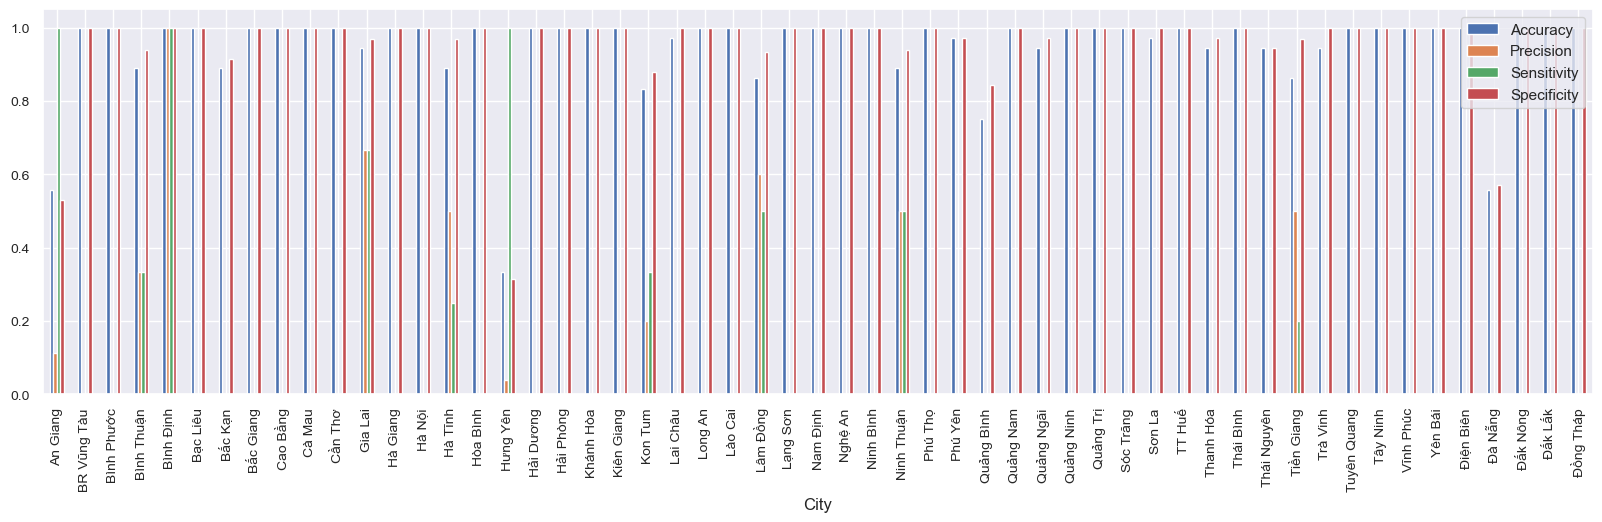

In [433]:
df_ob_one_time_windows = df_ob_all_cities_by_frame_dwe.loc[df_ob_all_cities_by_frame_dwe['timeframe']==5]
df_ob_one_time_windows.set_index('City', inplace=True)
df_ob_one_time_windows.loc[:,['Accuracy','Precision','Sensitivity','Specificity']].plot( kind="bar", figsize=(20, 5), grid= True, fontsize=10)

In [429]:
dwe_ob_fix_NAN = df_ob_all_cities_by_frame_dwe[['City','timeframe','Accuracy','Precision','Sensitivity','Specificity']].copy()
dwe_ob_fix_NAN = dwe_ob_fix_NAN.replace(np.nan, -0.555555)
dwe_ob_fix_NAN.to_excel('ob.xlsx')

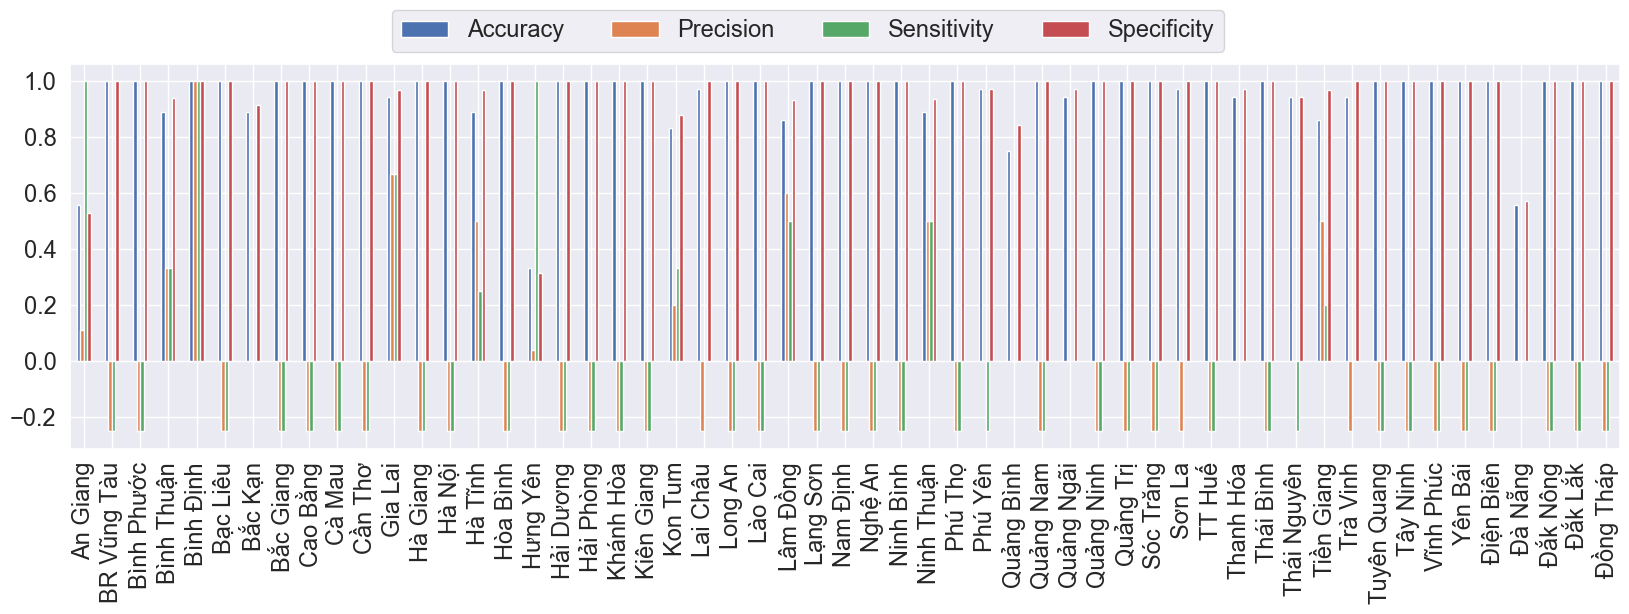

In [527]:
dwe_ob_fix_NAN = df_ob_all_cities_by_frame_dwe[['City','timeframe','Accuracy','Precision','Sensitivity','Specificity']].copy()
dwe_ob_fix_NAN = dwe_ob_fix_NAN.replace(np.nan, -0.25)

df_ob_one_time_windows = dwe_ob_fix_NAN.loc[df_ob_all_cities_by_frame_dwe['timeframe']==5]
df_ob_one_time_windows.set_index('City', inplace=True)
df_ob_one_time_windows.loc[:,['Accuracy','Precision','Sensitivity','Specificity']].plot( kind="bar", figsize=(20, 5), grid= True, fontsize=10)
plt.legend(['Accuracy','Precision','Sensitivity','Specificity'],loc='best', bbox_to_anchor=(0.2, 1), shadow=False,ncol=4, fontsize = 17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.xlabel("")
plt.show()

In [431]:
dwe_ob_fix_NAN

City  timeframe  Accuracy  Precision  Sensitivity  Specificity
0      An Giang          3  0.416667   0.310345     0.900000     0.230769
0   BR Vũng Tàu          3  1.000000  -0.250000    -0.250000     1.000000
0    Bình Phước          3  1.000000  -0.250000    -0.250000     1.000000
0    Bình Thuận          3  0.805556   0.166667     0.333333     0.848485
0     Bình Định          3  0.805556   0.333333     0.400000     0.870968
..          ...        ...       ...        ...          ...          ...
0     Điện Biên          5  1.000000  -0.250000    -0.250000     1.000000
0       Đà Nẵng          5  0.555556   0.000000     0.000000     0.571429
0      Đắk Nông          5  1.000000  -0.250000    -0.250000     1.000000
0       Đắk Lắk          5  1.000000  -0.250000    -0.250000     1.000000
0     Đồng Tháp          5  1.000000  -0.250000    -0.250000     1.000000

[110 rows x 6 columns]

In [438]:
dwe_ob_fix_NAN.loc[(dwe_ob_fix_NAN.loc['Sensitivity'] == -0.25) or (dwe_ob_fix_NAN.loc['Precision'] == -0.25)]

KeyError: 'Sensitivity'

# Vẽ outbreak chi tiết từng tỉnh DWE

In [ ]:
# Vẽ outbreak chi tiết từng tỉnh DWE
dict_original_full_cities = dict_original_full_cities_by_frame[10]
for city in cities:
    city_test = dict_original_full_cities[city].iloc[-36:]
    ax = city_test.loc[:,['Observed']].plot(color ="black",figsize=(10, 4))
    ax.plot(city_test.loc[:,['mean']], label='mean', color='green',linestyle='dashdot')
    ax.plot(city_test.loc[:,['std']], label='std', color='blue',linestyle='dashdot')
    ax.plot(city_test.loc[:,['DWE']], label='DWE', color='red')

    plt.scatter(x= city_test.index, y =city_test['true_ob_plot'],  label= 'True Outbreak', marker='*',c='red')
    plt.scatter(x= city_test.index, y =city_test['pred_ob_plot']-1,  label= 'Predicted Outbreak', marker='^',c='green')
    plt.legend(['Observed','mean','std','DWE','True Outbreak','Predicted Outbreak'], loc='best', shadow=False,ncol=2)
    plt.title('Province: '+city)
    plt.show()

# LSTM, TF, CNN, ATT, Outbreak

In [439]:
def get_df_best_predicted_results_by(eval_metrix='MAE_1-month', result_algo_path='', file_head='', file_tail='_0'):
    # Lọc ra theo min RMSE - của cả 3 giải thuật
    l_all_algo_cities = pd.DataFrame()
    for city in cities:
        city_result = pd.read_excel(
            result_algo_path + file_head + city + file_tail + '.xlsx')
        city_result = city_result[['City', 'Alg_name', '1-month','RMSE_1-month','MAE_1-month']]
        # group by Alg_name, sort RMSE_1-month, select first row for each group
        selected_result = city_result.sort_values(
            by=[eval_metrix], ascending=True).groupby('Alg_name').head(36)
        selected_result.reset_index(drop=True, inplace=True)
        selected_result = selected_result.sort_index(axis=0, ascending=True)

        # lấy kết quả theo giải thuật
        if len(l_all_algo_cities) == 0:
            l_all_algo_cities = selected_result
        else: 
            l_all_algo_cities = pd.concat([l_all_algo_cities, selected_result])
    return l_all_algo_cities

pred_result_3algo = get_df_best_predicted_results_by(eval_metrix = 'MAE_1-month', result_algo_path=result_path_3algo, file_head='diarrhoea_')
pred_result_cnn= extract_by_algo(algo='cnn', city_data =pred_result_3algo)
pred_result_lstm = extract_by_algo(algo='lstm', city_data =pred_result_3algo)
pred_result_lstm_att = extract_by_algo(algo='lstm_attention', city_data =pred_result_3algo)
pred_result_tf = get_df_best_predicted_results_by(eval_metrix = 'MAE_1-month', result_algo_path=result_path_tf, file_head="diarrhoea_transformer_")

In [440]:
# Lấy dữ liệu gốc của tất cả thành phố.
# Để lấy climate data sau này.
cities = ['An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh', 'Hòa Bình',
        'Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn', 'Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
         'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp']

# cities = ['An Giang']
def impute_missing_value(city_data):
    """
    Cơ bản dữ liệu bị thiếu sót rất nhiều: Như Điện Biên 1997 -2003 là thiếu dữ liệu về bệnh
    Hàm này sẽ tự sinh ra dữ liệu bị thiếu. Nếu tháng nào không có số liệu thì tính như sau:
    12 tháng đầu không có số liệu thì gán = 0
    tháng 13-24 không có số liệu, sẽ lấy giá trị của tháng cùng kỳ năm trước
    tháng từ 24 trở đi sẽ lấy giá trị nhỏ nhất của 2 tháng cùng kỳ trong 2 năm gần nhất.
    Do Điện Biên bằng 0 nên sau khi xử lý từ 1997 -2003 là đều = 0.  
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

def mean_std_observation_by_month(g):
    mean_observation = g['Observed'].mean() 
    std_observation = g['Observed'].std()           
    return pd.Series(dict(mean = mean_observation,std= std_observation))

def get_mean_std(range_len = 5, tail_data_city ='', full_one_city =''):
    df_mean_std = pd.DataFrame()
    for month_rows in range(36):
        current_row = tail_data_city.iloc[month_rows]
        current_year_month = current_row['year_month']
        from_time = current_year_month - relativedelta(months= range_len * 12) # 5 năm
        data_range = full_one_city.loc[(full_one_city['year_month'] >= from_time) & (full_one_city['year_month'] < current_year_month)]
        data_range = data_range.groupby(data_range['year_month'].dt.month).apply(mean_std_observation_by_month).reset_index()
        one_row_mean_std = data_range.loc[data_range['year_month']==current_row['month']]
        df_mean_std = pd.concat([df_mean_std,one_row_mean_std ])
    df_mean_std.drop(columns='year_month', inplace=True)
    df_mean_std.reset_index(drop=True, inplace=True)    
    return df_mean_std

def get_dict_ob_all_city_data(df_pred_algo ='', algo_name = ''):
    dict_all_cities_by_frame ={}
    dict_all_cities_1 = {}
    dict_all_cities_2 = {}
    n_time_1 = 3
    n_time_2 = 5
    df_all_cities_by_frame = pd.DataFrame()

    dict_last_36_frame_1 ={}
    dict_last_36_frame_2 ={}

    # Tính mean và std frame 1
    for city in cities:
        df_last_36 = pd.DataFrame()
        city_result = pd.read_excel(prj_path+'\\data\\new_data\\DH\\squeezed\\squeezed_'+city+'.xlsx') 
        # city_result = city_result.loc[city_result['year_month'] < '2018-1-1'] 
        city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
        backup_year_month = pd.DataFrame(city_result['year_month'])
        backup_year_month['year_month'] = city_result['year_month'].copy()
        backup_year_month['year'] = city_result['year'].copy()
        backup_year_month['month'] = city_result['month'].copy()
        
        city_result.drop(columns=['Diarrhoea_cases', 'province', 'year_month',
                                    'Influenza_rates','Dengue_fever_rates',
                                    'Influenza_cases','Dengue_fever_cases', 'year', 'month',
                                    'population_male','population_female','population_urban',
                                    'population_countryside','area','population_density',
                                    'population_average','birth_rate','urban_water_usage_rate',
                                    'clean_water_rate_all','poverty_rate','toilet_rate'
                                                        ], inplace=True) 
        city_result = impute_missing_value(city_result)
        
        city_result.rename(columns = {'Diarrhoea_rates':'Observed'}, inplace = True)
        city_result['year_month'] = backup_year_month['year_month']
        city_result['year'] = backup_year_month['year']
        city_result['month'] = backup_year_month['month']
        city_result = city_result.loc[:,['Observed','year_month','year','month']]
        
        # Tính mean và std 
        # Lấy data theo từng tháng
        df_last_36_mean_std = city_result.iloc[-36:].reset_index(drop=True)
        # Tính mean và std theo khung 10 năm
        
        city_mean_std = get_mean_std(range_len = n_time_1, tail_data_city =city_result.tail(36), full_one_city =city_result)
        df_last_36_mean_std = pd.concat([df_last_36_mean_std,city_mean_std], axis= 1)       
        dict_last_36_frame_1[city] = df_last_36_mean_std
        
    # Tính mean và std frame 2
    for city in cities:
        df_last_36 = pd.DataFrame()
        city_result = pd.read_excel(prj_path+'\\data\\new_data\\DH\\squeezed\\squeezed_'+city+'.xlsx') 
        # city_result = city_result.loc[city_result['year_month'] < '2018-1-1'] 
        city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
        backup_year_month = pd.DataFrame(city_result['year_month'])
        backup_year_month['year_month'] = city_result['year_month'].copy()
        backup_year_month['year'] = city_result['year'].copy()
        backup_year_month['month'] = city_result['month'].copy()
        
        city_result.drop(columns=['Diarrhoea_cases', 'province', 'year_month',
                                    'Influenza_rates','Dengue_fever_rates',
                                    'Influenza_cases','Dengue_fever_cases', 'year', 'month',
                                    'population_male','population_female','population_urban',
                                    'population_countryside','area','population_density',
                                    'population_average','birth_rate','urban_water_usage_rate',
                                    'clean_water_rate_all','poverty_rate','toilet_rate'
                                                        ], inplace=True) 
        city_result = impute_missing_value(city_result)
        
        city_result.rename(columns = {'Diarrhoea_rates':'Observed'}, inplace = True)
        city_result['year_month'] = backup_year_month['year_month']
        city_result['year'] = backup_year_month['year']
        city_result['month'] = backup_year_month['month']
        city_result = city_result.loc[:,['Observed','year_month','year','month']]
        
        # Tính mean và std 
        # Lấy data theo từng tháng
        df_last_36_mean_std = city_result.iloc[-36:].reset_index(drop=True)
        # Tính mean và std theo khung 10 năm
        
        city_mean_std = get_mean_std(range_len = n_time_2, tail_data_city =city_result.tail(36), full_one_city =city_result)
        df_last_36_mean_std = pd.concat([df_last_36_mean_std,city_mean_std], axis= 1)       
        dict_last_36_frame_2[city] = df_last_36_mean_std

    # frame 1
    for city in cities: 
        df_last_36 = pd.DataFrame()       
        df_last_36 = dict_last_36_frame_1[city]
        
        pred_city = pd.DataFrame()
        pred_city= df_pred_algo.loc[df_pred_algo['City']==city].copy()
        pred_city.reset_index(drop=True, inplace= True)
        
        df_last_36[algo_name] = pred_city['1-month'].copy() 

        # Tính true outbreak theo mean và std 5/10 tháng cùng kỳ
        df_last_36.loc[(df_last_36['Observed'] > df_last_36['mean'] + df_last_36['std']) , 'true_ob_plot'] = df_last_36['Observed']
        df_last_36['true_ob'] = (df_last_36['Observed'] > df_last_36['mean'] + df_last_36['std'])  

        # Tính predicted outbreak
        # nếu có oubbrek thì xuất chấm đỏ tại chỗ observer
        df_last_36.loc[(df_last_36[algo_name] > df_last_36['mean'] + df_last_36['std']) , 'pred_ob_plot'] = df_last_36['Observed']
        df_last_36['pred_ob'] = (df_last_36[algo_name] > df_last_36['mean'] + df_last_36['std'])
        
        # Tính 4 bộ chỉ số      
        df_last_36['Correct_Pred_Ob'] = len(df_last_36[(df_last_36["true_ob"]== df_last_36["pred_ob"]) & (df_last_36["true_ob"] ==True )])

        df_last_36['Correct_Norm'] = len(df_last_36[
                                (df_last_36["true_ob"]== df_last_36["pred_ob"]) & (df_last_36["true_ob"] == False) ])
        
        df_last_36['Count_ob'] = len(df_last_36[df_last_36["true_ob"]== True])
        df_last_36['Count_pred_ob'] = len(df_last_36[df_last_36["pred_ob"]== True])
        df_last_36['Count_Norm'] = len(df_last_36[df_last_36["true_ob"]== False])
 
        df_last_36['Accuracy'] = (df_last_36['Correct_Pred_Ob']+ df_last_36['Correct_Norm'])/36
        df_last_36['Precision'] = df_last_36['Correct_Pred_Ob']/df_last_36['Count_pred_ob']
        df_last_36['Sensitivity'] = df_last_36['Correct_Pred_Ob']/df_last_36['Count_ob']
        df_last_36['Specificity'] = df_last_36['Correct_Norm']/df_last_36['Count_Norm']
        df_last_36['City'] = city
        df_last_36['timeframe'] = n_time_1

        df_all_cities_by_frame = pd.concat([df_all_cities_by_frame, df_last_36.head(1)])
        dict_all_cities_1[city] = df_last_36
    
     # frame 2
    for city in cities: 
        df_last_36 = pd.DataFrame()     
        df_last_36 = dict_last_36_frame_2[city]
        pred_city = pd.DataFrame()
        pred_city= df_pred_algo.loc[df_pred_algo['City']==city].copy()
        pred_city.reset_index(drop=True, inplace= True)

        df_last_36[algo_name] = pred_city['1-month'].copy() 

        # Tính true outbreak theo mean và std 5/10 tháng cùng kỳ
        df_last_36.loc[(df_last_36['Observed'] > df_last_36['mean'] + df_last_36['std']) , 'true_ob_plot'] = df_last_36['Observed']
        df_last_36['true_ob'] = (df_last_36['Observed'] > df_last_36['mean'] + df_last_36['std'])  

        # Tính predicted outbreak
        # nếu có oubbrek thì xuất chấm đỏ tại chỗ observer
        df_last_36.loc[(df_last_36[algo_name] > df_last_36['mean'] + df_last_36['std']) , 'pred_ob_plot'] = df_last_36['Observed']
        df_last_36['pred_ob'] = (df_last_36[algo_name] > df_last_36['mean'] + df_last_36['std'])
        
        # Tính 4 bộ chỉ số      
        df_last_36['Correct_Pred_Ob'] = len(df_last_36[(df_last_36["true_ob"]== df_last_36["pred_ob"]) & (df_last_36["true_ob"] ==True )])

        df_last_36['Correct_Norm'] = len(df_last_36[
                                (df_last_36["true_ob"]== df_last_36["pred_ob"]) & (df_last_36["true_ob"] == False) ])
        
        df_last_36['Count_ob'] = len(df_last_36[df_last_36["true_ob"]== True])
        df_last_36['Count_pred_ob'] = len(df_last_36[df_last_36["pred_ob"]== True])
        df_last_36['Count_Norm'] = len(df_last_36[df_last_36["true_ob"]== False])
 
        df_last_36['Accuracy'] = (df_last_36['Correct_Pred_Ob']+ df_last_36['Correct_Norm'])/36
        df_last_36['Precision'] = df_last_36['Correct_Pred_Ob']/df_last_36['Count_pred_ob']
        df_last_36['Sensitivity'] = df_last_36['Correct_Pred_Ob']/df_last_36['Count_ob']
        df_last_36['Specificity'] = df_last_36['Correct_Norm']/df_last_36['Count_Norm']
        df_last_36['City'] = city
        df_last_36['timeframe'] = n_time_2
    
        df_all_cities_by_frame = pd.concat([df_all_cities_by_frame, df_last_36.head(1)])
        dict_all_cities_2[city] = df_last_36
    
    
    dict_all_cities_by_frame[n_time_1] = dict_all_cities_1
    dict_all_cities_by_frame[n_time_2] = dict_all_cities_2
    return dict_all_cities_by_frame, df_all_cities_by_frame

dict_all_ob_cities_by_frame_cnn, df_all_ob_cities_by_frame_cnn  = get_dict_ob_all_city_data(df_pred_algo =pred_result_cnn, algo_name = 'CNN')
# dict_all_ob_cities_by_frame_att, df_all_ob_cities_by_frame_att  = get_dict_ob_all_city_data(df_pred_algo =pred_result_lstm_att, algo_name = 'LSTM-ATT')
# dict_all_ob_cities_by_frame_lstm, df_all_ob_cities_by_frame_lstm  = get_dict_ob_all_city_data(df_pred_algo =pred_result_lstm, algo_name = 'LSTM')
# dict_all_ob_cities_by_frame_tf, df_all_ob_cities_by_frame_tf  = get_dict_ob_all_city_data(df_pred_algo =pred_result_tf, algo_name = 'TF')

C:\Users\Thanh Do\AppData\Local\Temp\ipykernel_12920\931968392.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
C:\Users\Thanh Do\AppData\Local\Temp\ipykernel_12920\931968392.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
C:\Users\Thanh Do\AppData\Local\Temp\ipykernel_12920\931968392.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

In [444]:
dict_all_ob_cities_by_frame_att, df_all_ob_cities_by_frame_att  = get_dict_ob_all_city_data(df_pred_algo =pred_result_lstm_att, algo_name = 'LSTM-ATT')
dict_all_ob_cities_by_frame_lstm, df_all_ob_cities_by_frame_lstm  = get_dict_ob_all_city_data(df_pred_algo =pred_result_lstm, algo_name = 'LSTM')
dict_all_ob_cities_by_frame_tf, df_all_ob_cities_by_frame_tf  = get_dict_ob_all_city_data(df_pred_algo =pred_result_tf, algo_name = 'TF')

C:\Users\Thanh Do\AppData\Local\Temp\ipykernel_12920\931968392.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
C:\Users\Thanh Do\AppData\Local\Temp\ipykernel_12920\931968392.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
C:\Users\Thanh Do\AppData\Local\Temp\ipykernel_12920\931968392.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

In [ ]:
dict_all_ob_cities_by_frame_cnn[5]

# Plot outbreak by cities

In [ ]:
dict_original_full_cities = dict_all_ob_cities_by_frame_cnn[3]
selected_cities = [ 'Kon Tum', 'Lào Cai', 'Thái Bình','Điện Biên','Đắk Lắk', 'Cao Bằng']
for city in selected_cities:
    city_test = dict_original_full_cities[city].iloc[-36:]
    ax = city_test.loc[:,['Observed']].plot(color ="black",figsize=(10, 4))
    ax.plot(city_test.loc[:,['mean']], label='mean', color='green',linestyle='dashdot')
    ax.plot(city_test.loc[:,['std']], label='std', color='blue',linestyle='dashdot')
    # ax.plot(city_test.loc[:,['CNN']], label='CNN', color='red')

    plt.scatter(x= city_test.index, y =city_test['true_ob_plot'],  label= 'True Outbreak', marker='*',c='red')
    # plt.scatter(x= city_test.index, y =city_test['pred_ob_plot']-1,  label= 'Predicted Outbreak', marker='^',c='green')
    plt.legend(['Observed','mean','std','True Outbreak'], loc='best', shadow=False,ncol=2)
    plt.title('Province: '+city)
    plt.show()

In [ ]:
dict_original_full_cities = dict_all_ob_cities_by_frame_cnn[3]
for city in cities:
    city_test = dict_original_full_cities[city].iloc[-36:]
    ax = city_test.loc[:,['Observed']].plot(color ="black",figsize=(10, 4))
    ax.plot(city_test.loc[:,['mean']], label='mean', color='green',linestyle='dashdot')
    ax.plot(city_test.loc[:,['std']], label='std', color='blue',linestyle='dashdot')
    ax.plot(city_test.loc[:,['CNN']], label='CNN', color='red')

    plt.scatter(x= city_test.index, y =city_test['true_ob_plot'],  label= 'True Outbreak', marker='*',c='red')
    plt.scatter(x= city_test.index, y =city_test['pred_ob_plot']-1,  label= 'Predicted Outbreak', marker='^',c='green')
    plt.legend(['Observed','mean','std','CNN','True Outbreak','Predicted Outbreak'], loc='best', shadow=False,ncol=2)
    plt.title('Province: '+city)
    plt.show()

In [446]:
dwe_ob = df_ob_all_cities_by_frame_dwe[['City','timeframe','Accuracy','Precision','Sensitivity','Specificity']].copy()
dwe_ob['Algo'] ='DWE'

att_ob = df_all_ob_cities_by_frame_att[['City','timeframe','Accuracy','Precision','Sensitivity','Specificity']].copy()
att_ob['Algo'] ='LSTM-ATT'

cnn_ob = df_all_ob_cities_by_frame_cnn[['City','timeframe','Accuracy','Precision','Sensitivity','Specificity']].copy()
cnn_ob['Algo'] ='CNN'

lstm_ob = df_all_ob_cities_by_frame_lstm[['City','timeframe','Accuracy','Precision','Sensitivity','Specificity']].copy()
lstm_ob['Algo'] ='LSTM'

tf_ob = df_all_ob_cities_by_frame_tf[['City','timeframe','Accuracy','Precision','Sensitivity','Specificity']].copy()
tf_ob['Algo'] ='TF'

df_ob_mix_all_algo_3 = pd.concat([dwe_ob,att_ob,cnn_ob,lstm_ob,tf_ob])

In [447]:
df_ob_mix_all_algo_3

City  timeframe  Accuracy  Precision  Sensitivity  Specificity Algo
0      An Giang          3  0.416667   0.310345     0.900000     0.230769  DWE
0   BR Vũng Tàu          3  1.000000        NaN          NaN     1.000000  DWE
0    Bình Phước          3  1.000000        NaN          NaN     1.000000  DWE
0    Bình Thuận          3  0.805556   0.166667     0.333333     0.848485  DWE
0     Bình Định          3  0.805556   0.333333     0.400000     0.870968  DWE
..          ...        ...       ...        ...          ...          ...  ...
0     Điện Biên          5  1.000000        NaN          NaN     1.000000   TF
0       Đà Nẵng          5  1.000000        NaN          NaN     1.000000   TF
0      Đắk Nông          5  1.000000        NaN          NaN     1.000000   TF
0       Đắk Lắk          5  0.833333   0.000000          NaN     0.833333   TF
0     Đồng Tháp          5  0.944444   0.000000          NaN     0.944444   TF

[550 rows x 7 columns]

In [448]:
df_ob_mix_all_algo_3.to_excel('Outbreak_all_algo_mix.xlsx')

In [ ]:
# So sánh time frame 3-5
# ax = sns.boxplot(x='timeframe', y='Accuracy', data=df_ob_mix_all_algo_3)
# plt.setp(ax.get_xticklabels(), rotation=90)
# plt.xlabel('timeframe')
# plt.ylabel('Accuracy')
# plt.title('Accuracy')
# plt.show()

# ax = sns.boxplot(x='timeframe', y='Precision', data=df_ob_mix_all_algo_3)
# plt.setp(ax.get_xticklabels(), rotation=90)
# plt.xlabel('timeframe')
# plt.ylabel('Precision')
# plt.title('Precision')
# plt.show()

# ax = sns.boxplot(x='timeframe', y='Sensitivity', data=df_ob_mix_all_algo_3)
# plt.setp(ax.get_xticklabels(), rotation=90)
# plt.xlabel('timeframe')
# plt.ylabel('Sensitivity')
# plt.title('Sensitivity')
# plt.show()

# ax = sns.boxplot(x='timeframe', y='Specificity', data=df_ob_mix_all_algo_3)
# plt.setp(ax.get_xticklabels(), rotation=90)
# plt.xlabel('timeframe')
# plt.ylabel('Specificity')
# plt.title('Specificity')
# plt.show()

In [ ]:
groupby('City')['MAE_1-month'].agg(['min', 'max','mean'])

In [ ]:
df_ob_one_time_windows

In [445]:
df_ob_mix_all_algo_3

NameError: name 'df_ob_mix_all_algo_3' is not defined

In [ ]:
df_ob_one_time_windows = df_ob_mix_all_algo_3.loc[df_ob_mix_all_algo_3['timeframe']==5]
df_ob_one_time_windows.groupby('Algo')['Accuracy'].mean()

Algo
CNN         0.922727
DWE         0.944444
LSTM        0.942929
LSTM-ATT    0.951515
TF          0.753030
Name: Accuracy, dtype: float64

In [ ]:
precision = df_ob_one_time_windows[['Precision','Algo']]
precision = precision.dropna(axis=0)


Precision Algo
0    0.111111  DWE
0         NaN  DWE
0         NaN  DWE
0    0.333333  DWE
0    1.000000  DWE
..        ...  ...
0         NaN   TF
0         NaN   TF
0         NaN   TF
0    0.000000   TF
0    0.000000   TF

[275 rows x 2 columns]

In [ ]:
precision = df_ob_one_time_windows[['Precision','Algo']]
precision = precision.dropna(axis=0)
precision

Precision Algo
0    0.111111  DWE
0    0.333333  DWE
0    1.000000  DWE
0    0.000000  DWE
0    0.666667  DWE
..        ...  ...
0    0.200000   TF
0    0.000000   TF
0    0.000000   TF
0    0.000000   TF
0    0.000000   TF

[131 rows x 2 columns]

In [ ]:
precision.groupby('Algo')['Precision'].mean()

Algo
CNN         0.040518
DWE         0.261830
LSTM        0.088768
LSTM-ATT    0.105263
TF          0.042048
Name: Precision, dtype: float64

In [ ]:
df_ob_one_time_windows.groupby('Algo')['Precision'].mean()

Algo
CNN         0.040518
DWE         0.261830
LSTM        0.088768
LSTM-ATT    0.105263
TF          0.042048
Name: Precision, dtype: float64

In [ ]:
df_ob_one_time_windows.groupby('Algo')['Sensitivity'].mean()

Algo
CNN         0.195370
DWE         0.321296
LSTM        0.144444
LSTM-ATT    0.157407
TF          0.335185
Name: Sensitivity, dtype: float64

In [ ]:
df_ob_one_time_windows.groupby('Algo')['Specificity'].mean()

Algo
CNN         0.937068
DWE         0.956871
LSTM        0.958364
LSTM-ATT    0.968772
TF          0.761820
Name: Specificity, dtype: float64

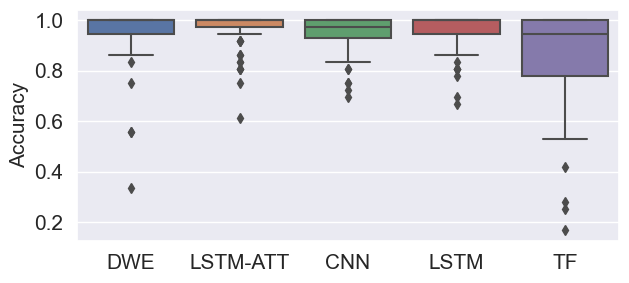

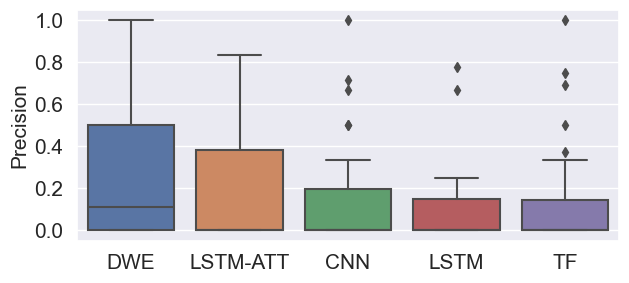

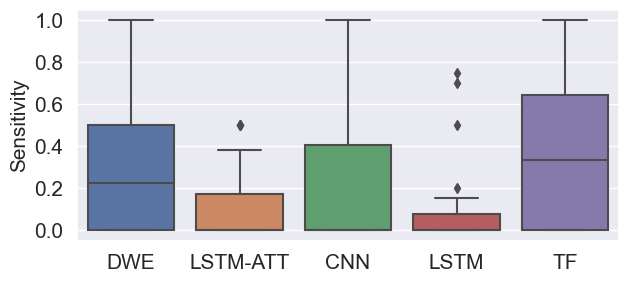

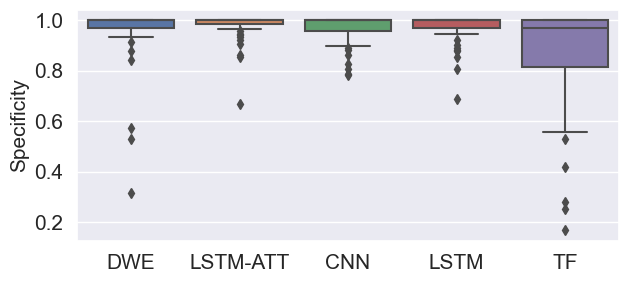

In [451]:
# So sánh time frame 3-5
df_ob_one_time_windows = df_ob_mix_all_algo_3.loc[df_ob_mix_all_algo_3['timeframe']==5]
ax = sns.boxplot(x='Algo', y='Accuracy', data=df_ob_one_time_windows)

plt.xlabel('')
plt.xticks(fontsize=15)
plt.yticks(fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
# plt.title('Accuracy')
plt.show()

ax = sns.boxplot(x='Algo', y='Precision', data=df_ob_one_time_windows)

plt.xlabel('')
plt.xticks(fontsize=15)
plt.yticks(fontsize = 15)
plt.ylabel('Precision',fontsize = 15)
# plt.title('Precision')
plt.show()

ax = sns.boxplot(x='Algo', y='Sensitivity', data=df_ob_one_time_windows)

plt.xlabel('')
plt.xticks(fontsize=15)
plt.yticks(fontsize = 15)
plt.ylabel('Sensitivity',fontsize = 15)
# plt.title('Sensitivity')
plt.show()

ax = sns.boxplot(x='Algo', y='Specificity', data=df_ob_one_time_windows)

plt.xlabel('')
plt.xticks(fontsize=15)
plt.yticks(fontsize = 15)
plt.ylabel('Specificity',fontsize = 15)
# plt.title('Specificity')
plt.show()

# Xét mức ảnh hưởng của climate vào kết quả

In [ ]:
def rename_error_province_index(df):
    df['province'] = df['province'].replace(['Bà Rịa - Vũng Tàu', 'Bình Ðịnh','Hoà Bình','Khánh Hoà','Lâm Ðồng','Nam Ðịnh','Thừa Thiên Huế','Thanh Hoá','Ðiện Biên','Ðà Nẵng','Ðắk Lắk','Ðắk Nông','Ðồng Tháp'], 
                                            ['BR Vũng Tàu', 'Bình Định','Hòa Bình','Khánh Hòa','Lâm Đồng','Nam Định','TT Huế','Thanh Hóa','Điện Biên','Đà Nẵng','Đắk Lắk','Đắk Nông','Đồng Tháp'])
    return df

#Đọc phân nhóm tỉnh theo 5 khu vực
city_by_group= pd.read_excel('H:\\Store\\Research\\UIT\\PhD Research\\Dev Environment\\Tropical Diseases\\running\\data\\data_gov_statistics\\province_region.xlsx')

city_by_group = rename_error_province_index(df = city_by_group)
city_by_group.set_index('province',inplace=True)
# không có thành phố 'Bình Dương', 'Bắc Ninh', 'Bến Tre', 'Hà Nam', 'Hậu Giang','TP Hồ Chí Minh', 'Vĩnh Long', 'Đồng Nai'
list_missing_cities = ['Bình Dương', 'Bắc Ninh', 'Bến Tre', 'Hà Nam', 
                       'Hậu Giang','TP Hồ Chí Minh', 'Vĩnh Long', 'Đồng Nai']
city_by_group = city_by_group.drop(list_missing_cities)

sub_region_list = city_by_group['subregion'].unique()
region_list = city_by_group['region'].unique()

# Alternatively, add subregion column to full dataset
def label_subregion(row):
    return city_by_group.loc[row['province'],'subregion']

# Alternatively, add region column to full dataset
def label_region(row):
    return city_by_group.loc[row['province'],'region']

dict_subregion = {}
for sub_region in sub_region_list:
    data = city_by_group[city_by_group["subregion"] == sub_region]
    dict_subregion[sub_region] = data

# Get list feature
cities = dict_subregion[sub_region].index.to_list()
list_features = []


com_path_climate_weighted_data = 'H:\\Store\\Research\\UIT\\PhD Research\\Dev Environment\\Tropical Diseases\\running\\results\\ensemble\\result\\weighted_combination\\climate_weighted_data\\'
for city in cities:
    city_data = pd.read_excel(com_path_climate_weighted_data+'climate_info\\'+city+'_climate_only.xlsx')
    city_data = city_data.drop(columns=['Unnamed: 0'])
    list_features.extend(city_data.columns.to_list())
list_features = list(dict.fromkeys(list_features))
list_features.sort()


df_final_statistic = pd.DataFrame(0, index=sub_region_list, columns=list_features)

for sub_region in sub_region_list:
    df_features_by_region = pd.DataFrame()
    for city in dict_subregion[sub_region].index.to_list():
        city_data = pd.read_excel(com_path_climate_weighted_data+'climate_info\\'+city+'_climate_only.xlsx')
        city_data = city_data.drop(columns=['Unnamed: 0'])
        rs = pd.DataFrame({"Feature" : city_data.columns.to_list()})
        df_features_by_region = pd.concat([df_features_by_region, rs])

    # Sau khi có được danh sách các features theo region
    # thực hiện thêm vào bảng
    count_num_features = df_features_by_region['Feature'].value_counts()
    for feature in list_features:
        if feature in count_num_features.index.tolist():
            df_final_statistic.loc[sub_region, feature] = count_num_features[feature]

df_final_statistic


Average_temperature  Max_Absolute_Temperature  \
Red River Delta                        1                         1   
Northeast                              0                         2   
Northwest                              0                         2   
North Central Coast                    1                         0   
South Central Coast                    1                         3   
Central Highlands                      0                         2   
Southeast                              0                         1   
Mekong River Delta                     1                         1   

                     Max_Average_Temperature  Max_Daily_Rainfall  \
Red River Delta                            3                   0   
Northeast                                  5                   0   
Northwest                                  0                   1   
North Central Coast                        2                   1   
South Central Coast                        2                   2   
Central Highlands                          0                   0   
Southeast                                  0                   0   
Mekong River Delta                         3                   4   

                     Min_Absolute_Temperature  Min_Humidity  \
Red River Delta                             1             1   
Northeast                                   0             1   
Northwest                                   0             0   
North Central Coast                         2             2   
South Central Coast                         0             0   
Central Highlands                           3             0   
Southeast                                   1             1   
Mekong River Delta                          1             1   

                     Total_Evaporation  Total_Rainfall  n_hours_sunshine  \
Red River Delta                      2               1                 4   
Northeast                            1               1                 3   
Northwest                            2               0                 2   
North Central Coast                  0               0                 2   
South Central Coast                  1               4                 0   
Central Highlands                    3               1                 0   
Southeast                            1               1                 0   
Mekong River Delta                   2               2                 4   

                     n_raining_days  
Red River Delta                   1  
Northeast                         1  
Northwest                         1  
North Central Coast               1  
South Central Coast               1  
Central Highlands                 0  
Southeast                         0  
Mekong River Delta                1

In [ ]:
cat_sub_region_order = CategoricalDtype(
    [ 'Northeast', 'Northwest', 'Red River Delta','North Central Coast','South Central Coast', 'Central Highlands', 'Mekong River Delta','Southeast'], 
    ordered=True
)
df_final_statistic['subregion'] = df_final_statistic.index
df_final_statistic['subregion'] = df_final_statistic['subregion'].astype(cat_sub_region_order)
df_final_statistic = df_final_statistic.sort_values('subregion').copy().reset_index(drop=True)
df_final_statistic.set_index('subregion', inplace=True)
df_final_statistic

Average_temperature  Max_Absolute_Temperature  \
subregion                                                            
Northeast                              0                         2   
Northwest                              0                         2   
Red River Delta                        1                         1   
North Central Coast                    1                         0   
South Central Coast                    1                         3   
Central Highlands                      0                         2   
Mekong River Delta                     1                         1   
Southeast                              0                         1   

                     Max_Average_Temperature  Max_Daily_Rainfall  \
subregion                                                          
Northeast                                  5                   0   
Northwest                                  0                   1   
Red River Delta                            3                   0   
North Central Coast                        2                   1   
South Central Coast                        2                   2   
Central Highlands                          0                   0   
Mekong River Delta                         3                   4   
Southeast                                  0                   0   

                     Min_Absolute_Temperature  Min_Humidity  \
subregion                                                     
Northeast                                   0             1   
Northwest                                   0             0   
Red River Delta                             1             1   
North Central Coast                         2             2   
South Central Coast                         0             0   
Central Highlands                           3             0   
Mekong River Delta                          1             1   
Southeast                                   1             1   

                     Total_Evaporation  Total_Rainfall  n_hours_sunshine  \
subregion                                                                  
Northeast                            1               1                 3   
Northwest                            2               0                 2   
Red River Delta                      2               1                 4   
North Central Coast                  0               0                 2   
South Central Coast                  1               4                 0   
Central Highlands                    3               1                 0   
Mekong River Delta                   2               2                 4   
Southeast                            1               1                 0   

                     n_raining_days  
subregion                            
Northeast                         1  
Northwest                         1  
Red River Delta                   1  
North Central Coast               1  
South Central Coast               1  
Central Highlands                 0  
Mekong River Delta                1  
Southeast                         0

In [ ]:
df_final_statistic['n_provinces'] = 0
df_final_statistic.loc['Northeast'].n_provinces = 10
df_final_statistic.loc['Northwest'].n_provinces = 5
df_final_statistic.loc['Red River Delta'].n_provinces = 8
df_final_statistic.loc['North Central Coast'].n_provinces = 6
df_final_statistic.loc['South Central Coast'].n_provinces = 8
df_final_statistic.loc['Central Highlands'].n_provinces = 5
df_final_statistic.loc['Mekong River Delta'].n_provinces = 10
df_final_statistic.loc['Southeast'].n_provinces = 3

In [ ]:
df_final_statistic

Average_temperature  Max_Absolute_Temperature  \
subregion                                                            
Northeast                              0                         2   
Northwest                              0                         2   
Red River Delta                        1                         1   
North Central Coast                    1                         0   
South Central Coast                    1                         3   
Central Highlands                      0                         2   
Mekong River Delta                     1                         1   
Southeast                              0                         1   

                     Max_Average_Temperature  Max_Daily_Rainfall  \
subregion                                                          
Northeast                                  5                   0   
Northwest                                  0                   1   
Red River Delta                            3                   0   
North Central Coast                        2                   1   
South Central Coast                        2                   2   
Central Highlands                          0                   0   
Mekong River Delta                         3                   4   
Southeast                                  0                   0   

                     Min_Absolute_Temperature  Min_Humidity  \
subregion                                                     
Northeast                                   0             1   
Northwest                                   0             0   
Red River Delta                             1             1   
North Central Coast                         2             2   
South Central Coast                         0             0   
Central Highlands                           3             0   
Mekong River Delta                          1             1   
Southeast                                   1             1   

                     Total_Evaporation  Total_Rainfall  n_hours_sunshine  \
subregion                                                                  
Northeast                            1               1                 3   
Northwest                            2               0                 2   
Red River Delta                      2               1                 4   
North Central Coast                  0               0                 2   
South Central Coast                  1               4                 0   
Central Highlands                    3               1                 0   
Mekong River Delta                   2               2                 4   
Southeast                            1               1                 0   

                     n_raining_days  n_provinces  
subregion                                         
Northeast                         1           10  
Northwest                         1            5  
Red River Delta                   1            8  
North Central Coast               1            6  
South Central Coast               1            8  
Central Highlands                 0            5  
Mekong River Delta                1           10  
Southeast                         0            3

In [ ]:
df_final_statistic_per = df_final_statistic.copy()
for col in list_features:
    df_final_statistic_per[col] = df_final_statistic_per[col]/df_final_statistic_per['n_provinces']
df_final_statistic_per.drop(columns='n_provinces', inplace=True)

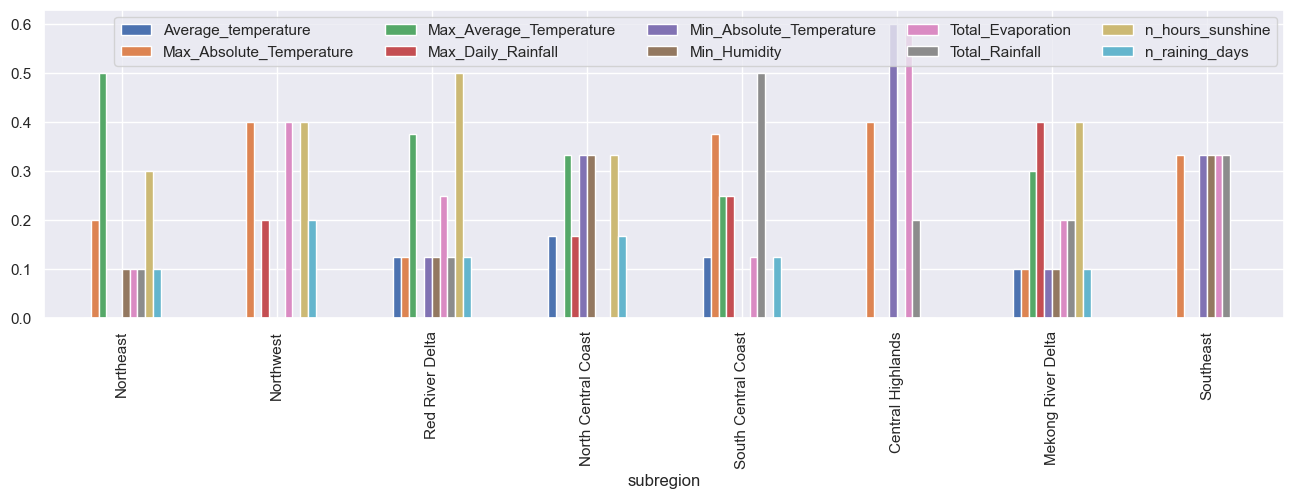

In [ ]:
df_final_statistic_per.plot(kind="bar", figsize=(16, 4))
plt.legend(loc='best', ncol =5)

In [ ]:
cities = ['An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh', 'Hòa Bình',
        'Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn', 'Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
         'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp']

# cities = ['Điện Biên', 'Thái Bình', 'Lào Cai', 'Kon Tum', 'Cao Bằng','Lâm Đồng']
z=55

In [ ]:
pd_city_and_climate_all = pd.DataFrame()
for city in cities:
    pd_city_and_climate = pd.DataFrame()
    city_data = pd.read_excel(com_path_climate_weighted_data+'climate_info\\'+city+'_climate_only.xlsx')
    city_data = city_data.drop(columns=['Unnamed: 0'])
    rs = city_data.columns.to_list()
    str = city + ': ' +rs[0] +' & ' +rs[1] 
    pd_city_and_climate = pd.DataFrame({
                                    'province': city,
                                    'province_climate': [str]})
    

    pd_city_and_climate_all = pd.concat([pd_city_and_climate_all,pd_city_and_climate])

pd_city_and_climate_all.reset_index(drop=True, inplace=True)
pd_city_and_climate_all

In [ ]:
vietnam_by_city_climate_name = vietnam_sort.merge(pd_city_and_climate_all,on='province')
vietnam_by_city_climate_name

# Vẽ theo tên TP và Climate

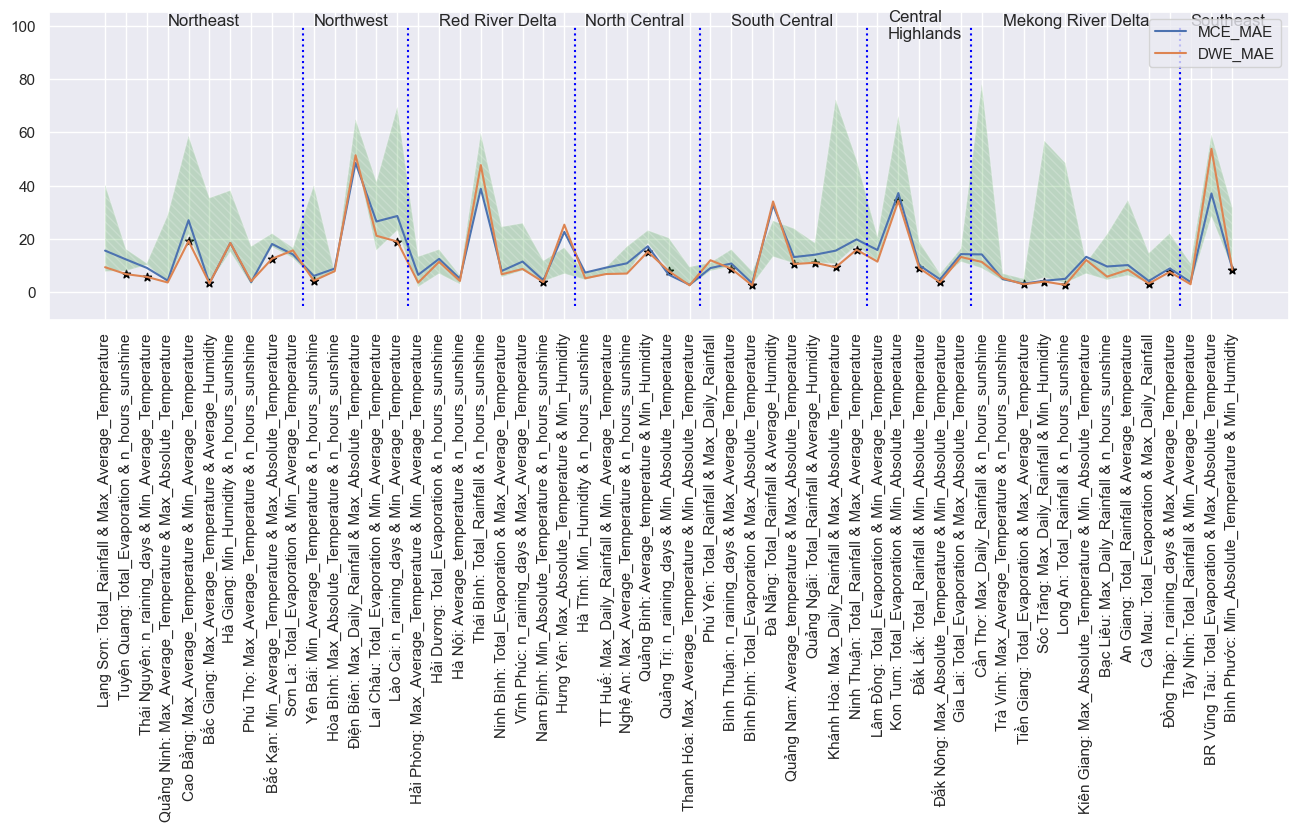

In [ ]:
vietnam_by_city_climate_name.loc[(vietnam_by_city_climate_name['DWE_MAE'] < vietnam_by_city_climate_name['min'])& (vietnam_by_city_climate_name['DWE_MAE'] <vietnam_by_city_climate_name['MCE_MAE']), 'smallest'] = vietnam_by_city_climate_name['DWE_MAE']

ax  = vietnam_by_city_climate_name.loc[:,['MCE_MAE','DWE_MAE']].plot.line(figsize=(16, 4)) 
plt.scatter(x= vietnam_by_city_climate_name['province_climate'], y =vietnam_by_city_climate_name['smallest'],  marker='*',c='black')
plt.fill_between(x='province_climate',y1='min',y2='max', facecolor='green', hatch='\\\\\\\\', alpha=0.2, interpolate=True, data=vietnam_by_city_climate_name)
ax.vlines([9.5, 14.5, 22.5, 28.5,36.5,41.5,51.5], -5, 100, color ="blue", linestyles ='dotted') 
plt.text(3,100,'Northeast')
plt.text(10,100,'Northwest')
plt.text(16,100,'Red River Delta')
plt.text(23,100,'North Central')
plt.text(30,100,'South Central')
plt.text(37.5,95,'Central'+ '\n' +'Highlands')
plt.text(43,100,'Mekong River Delta')
plt.text(52,100,'Southeast')
plt.xticks(rotation=90)
plt.show()

# Phần dưới bỏ qua

# Xếp hạng các Deep Learning

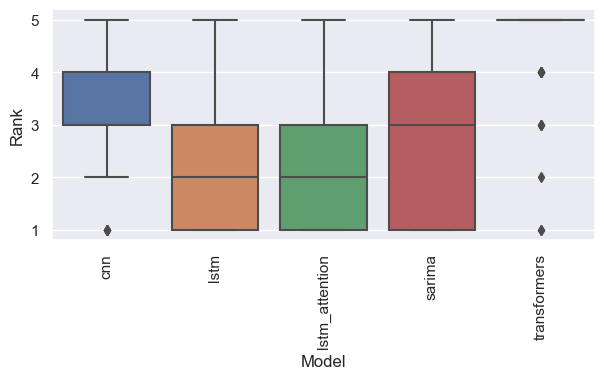

In [ ]:
melted_ranked_best_base_models_rmse = pd.melt(ranked_best_base_models_rmse)
melted_ranked_best_base_models_rmse
ax = sns.boxplot(x='Alg_name', y='value', data=melted_ranked_best_base_models_rmse)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel('Model')
plt.ylabel('Rank')
plt.show()

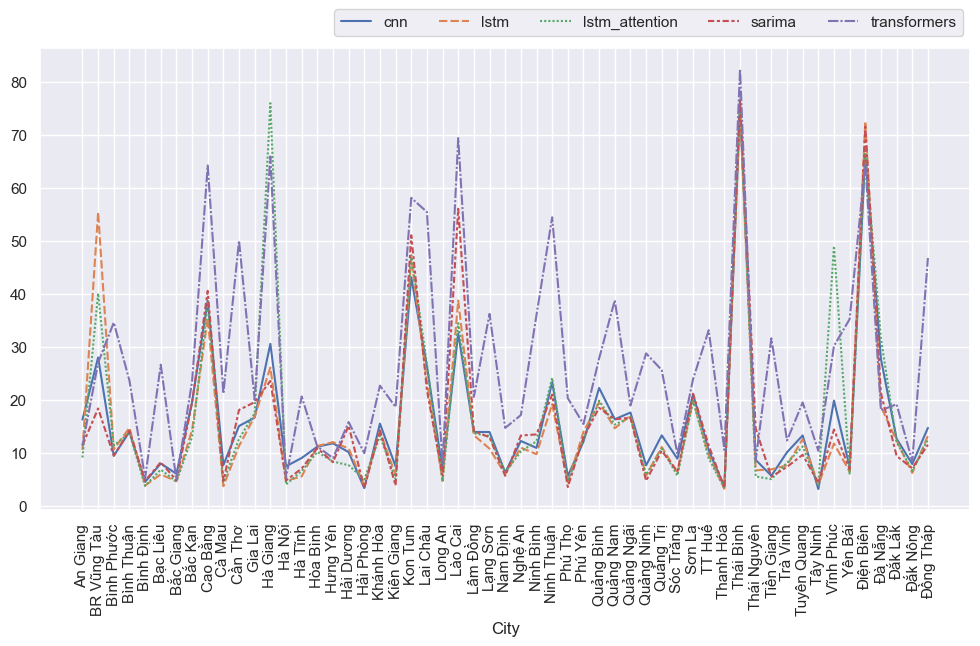

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=best_base_models_rmse.iloc[:,:6], dashes=True,)
plt.legend(loc='best', bbox_to_anchor=(1, 1.1), shadow=False,ncol=5)
plt.xticks(rotation= 90)
plt.savefig(prj_path + '\\Figures\\top_based_model_rmse.png', dpi=600)
plt.show()

In [ ]:
best_base_models_mae = best_base_models.pivot(index='City', columns='Alg_name', values='MAE_1-month')
# best_base_models_rmse= best_base_models_rmse.reset_index()
best_base_models_mae.head()

Alg_name           cnn       lstm  lstm_attention     sarima  transformers
City                                                                      
An Giang     14.938396   6.458507        6.421944   8.893658      9.709719
BR Vũng Tàu  25.915673  53.913967       38.427753  14.174166     23.233706
Bình Phước    7.173310   8.500210        8.458566   7.743684     32.382329
Bình Thuận    9.324313   9.428980        9.462876   9.366914     18.738385
Bình Định     3.665778   2.722772        2.746797   3.366756      3.962706

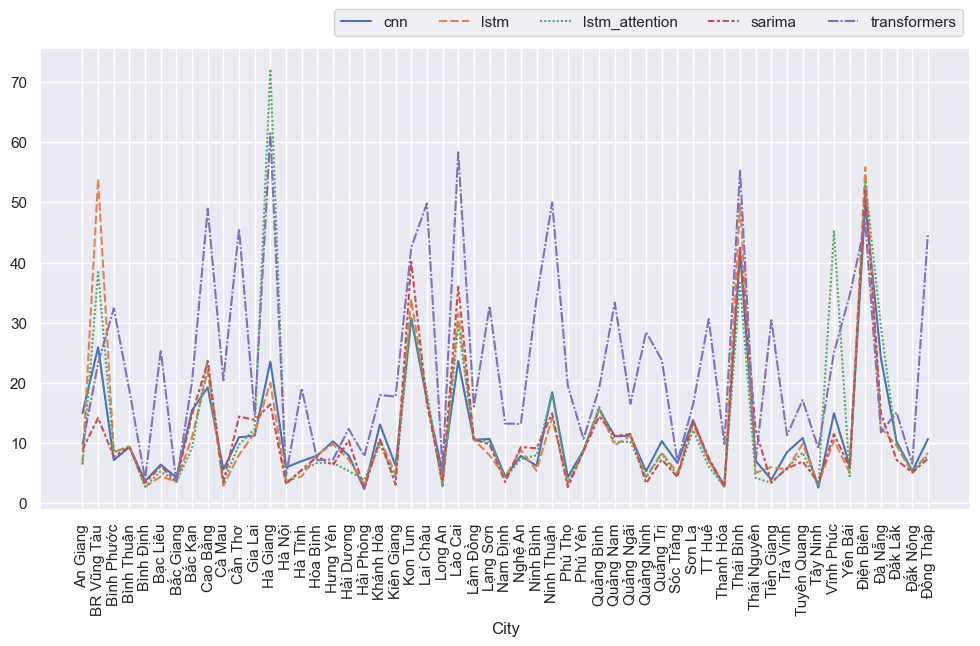

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=best_base_models_mae.iloc[:,:6], dashes=True,)
plt.legend(loc='best', bbox_to_anchor=(1, 1.1), shadow=False,ncol=5)
plt.xticks(rotation= 90)
plt.savefig(prj_path + '\\Figures\\top_based_model_mae.png', dpi=600)
plt.show()

# Đọc kết quả Simple Ensemble và xử lý experiment

In [ ]:
simple_ensemble = pd.read_excel(result_path+'simple_ensemble_all_mae.xlsx').drop(columns='Unnamed: 0')
simple_ensemble.rename(columns = {'RMSE_Simple_Avg':'RMSE_1-month','MAE_Simple_Avg':'MAE_1-month'}, inplace = True)

In [ ]:
best_base_models

City        Alg_name  RMSE_1-month  MAE_1-month
0      An Giang          sarima     11.430204     8.893658
0   BR Vũng Tàu          sarima     18.370324    14.174166
0    Bình Phước          sarima      9.435179     7.743684
0    Bình Thuận          sarima     14.197521     9.366914
0     Bình Định          sarima      4.692607     3.366756
..          ...             ...           ...          ...
50    Điện Biên  lstm_attention     68.645033    54.124853
51      Đà Nẵng  lstm_attention     19.162011    13.336673
52     Đắk Nông  lstm_attention      9.043391     6.934960
53      Đắk Lắk  lstm_attention     21.364264    17.580318
54    Đồng Tháp  lstm_attention     13.899795     9.526524

[275 rows x 4 columns]

In [ ]:
simple_ensemble.rename(columns = {'RMSE_Simple_Avg':'RMSE_1-month','MAE_Simple_Avg':'MAE_1-month'}, inplace = True)

City  RMSE_Simple_Avg  MAE_Simple_Avg         Alg_name
0     An Giang        13.903011       12.675671  Simple Ensemble
1  BR Vũng Tàu        50.277243       49.217620  Simple Ensemble
2   Bình Phước         9.985995        7.847360  Simple Ensemble
3   Bình Thuận        15.390006        9.119061  Simple Ensemble
4    Bình Định         3.761588        2.559269  Simple Ensemble

In [ ]:
best_deep_learning_base_models = pd.concat([    
    result_cnn,
    result_lstm,
    result_tf,
    result_lstm_att
])
best_deep_learning_base_models

City        Alg_name  RMSE_1-month  MAE_1-month
0      An Giang             cnn     16.283563    14.938396
1   BR Vũng Tàu             cnn     28.016330    25.915673
2    Bình Phước             cnn      9.444873     7.173310
3    Bình Thuận             cnn     13.973051     9.324313
4     Bình Định             cnn      4.504450     3.665778
..          ...             ...           ...          ...
50    Điện Biên  lstm_attention     67.134221    53.391625
51      Đà Nẵng  lstm_attention     31.650788    29.378000
52     Đắk Nông  lstm_attention      6.615078     5.434980
53      Đắk Lắk  lstm_attention     12.013769     9.826961
54    Đồng Tháp  lstm_attention     12.505814     7.905311

[220 rows x 4 columns]

In [ ]:
mix_best_simple_ens_base_model = pd.concat([best_deep_learning_base_models,simple_ensemble], axis= 0) 
mix_best_simple_ens_base_model

City         Alg_name  RMSE_1-month  MAE_1-month  RMSE_Simple_Avg  \
0      An Giang              cnn     16.283563    14.938396              NaN   
1   BR Vũng Tàu              cnn     28.016330    25.915673              NaN   
2    Bình Phước              cnn      9.444873     7.173310              NaN   
3    Bình Thuận              cnn     13.973051     9.324313              NaN   
4     Bình Định              cnn      4.504450     3.665778              NaN   
..          ...              ...           ...          ...              ...   
50    Điện Biên  Simple Ensemble           NaN          NaN        73.025279   
51      Đà Nẵng  Simple Ensemble           NaN          NaN        35.690214   
52     Đắk Nông  Simple Ensemble           NaN          NaN         5.112331   
53      Đắk Lắk  Simple Ensemble           NaN          NaN        12.302147   
54    Đồng Tháp  Simple Ensemble           NaN          NaN        12.027563   

    MAE_Simple_Avg  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
..             ...  
50       52.917151  
51       33.582255  
52        3.650646  
53        9.136741  
54        7.748276  

[275 rows x 6 columns]

In [ ]:
mix_best_simple_ens_base_model

City              Alg_name  RMSE_1-month  MAE_1-month
0      An Giang                   cnn     16.283563    14.938396
1   BR Vũng Tàu                   cnn     28.016330    25.915673
2    Bình Phước                   cnn      9.444873     7.173310
3    Bình Thuận                   cnn     13.973051     9.324313
4     Bình Định                   cnn      4.504450     3.665778
..          ...                   ...           ...          ...
50      Lào Cai  Best Simple Ensemble     24.810351    18.400682
51     Cao Bằng  Best Simple Ensemble     37.769258    22.193891
52      Kon Tum  Best Simple Ensemble     44.449599    31.588460
53    Điện Biên  Best Simple Ensemble     62.910442    49.109021
54    Thái Bình  Best Simple Ensemble     64.818605    45.757745

[275 rows x 4 columns]

# Vẽ best Simple Ensemble và based Models

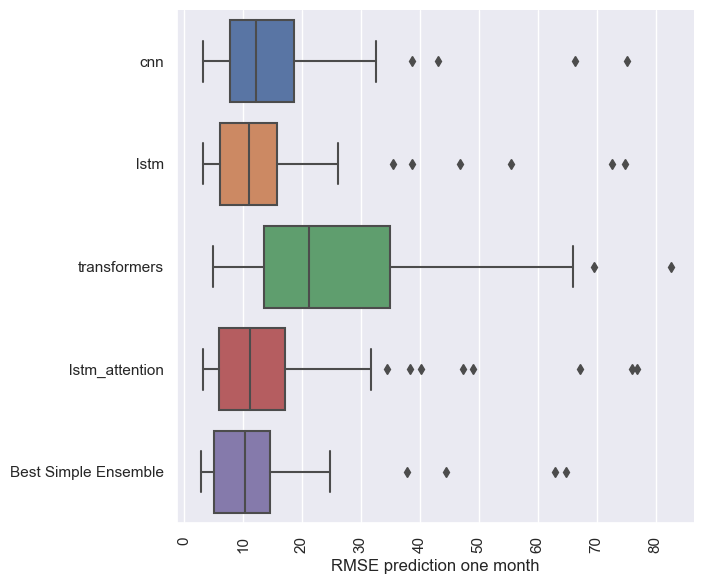

In [ ]:
g = sns.catplot(data=mix_best_simple_ens_base_model, x="RMSE_1-month",
                y="Alg_name", kind='box', height=6, aspect=1.2)
g.set(ylabel=None, xlabel="RMSE prediction one month")
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig(prj_path + '\\Figures\\avg_rmse_all_single_algo.png', dpi=600)
plt.show()


In [ ]:
compare_simple_base = mix_best_simple_ens_base_model.pivot(index='City', columns='Alg_name', values='RMSE_1-month')
# best_base_models_rmse= best_base_models_rmse.reset_index()
compare_simple_base.head()

Alg_name     Best Simple Ensemble        cnn       lstm  lstm_attention  \
City                                                                      
An Giang                 8.657966  16.283563  10.535906        9.105917   
BR Vũng Tàu             14.209093  28.016330  55.483408       40.123716   
Bình Phước               8.834086   9.444873  10.647856       11.371995   
Bình Thuận              14.132412  13.973051  14.720136       13.757477   
Bình Định                3.401306   4.504450   3.823462        3.731630   

Alg_name     transformers  
City                       
An Giang        11.354527  
BR Vũng Tàu     27.013197  
Bình Phước      34.616388  
Bình Thuận      23.641644  
Bình Định        5.214504

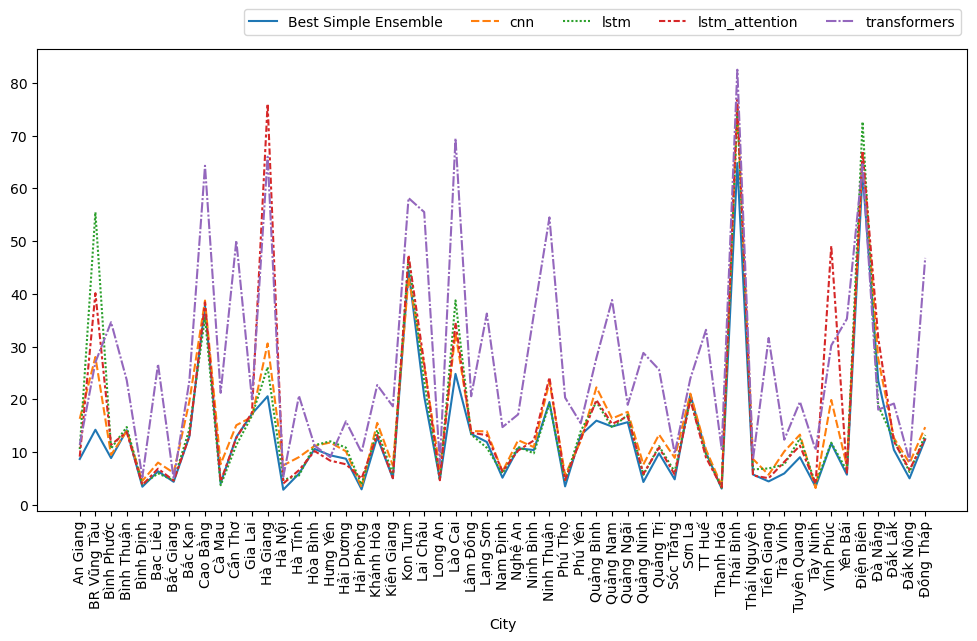

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=compare_simple_base, dashes=True,)
plt.legend(loc='best', bbox_to_anchor=(1, 1.1), shadow=False,ncol=6)
plt.xticks(rotation= 90)
plt.savefig(prj_path + '\\Figures\\best_simple_ens_vs_base_model.png', dpi=600)
plt.show()

# Xếp hạng theo rank cho simple ensemble with single model

In [ ]:
pivot_simple = mix_best_simple_ens_base_model.pivot(index='City', columns='Alg_name', values='RMSE_1-month')
ranked_pivot_simple = pivot_simple.rank(axis=1)
ranked_pivot_simple.head()

Alg_name     Best Simple Ensemble  cnn  lstm  lstm_attention  transformers
City                                                                      
An Giang                      1.0  5.0   3.0             2.0           4.0
BR Vũng Tàu                   1.0  3.0   5.0             4.0           2.0
Bình Phước                    1.0  2.0   3.0             4.0           5.0
Bình Thuận                    3.0  2.0   4.0             1.0           5.0
Bình Định                     1.0  4.0   3.0             2.0           5.0

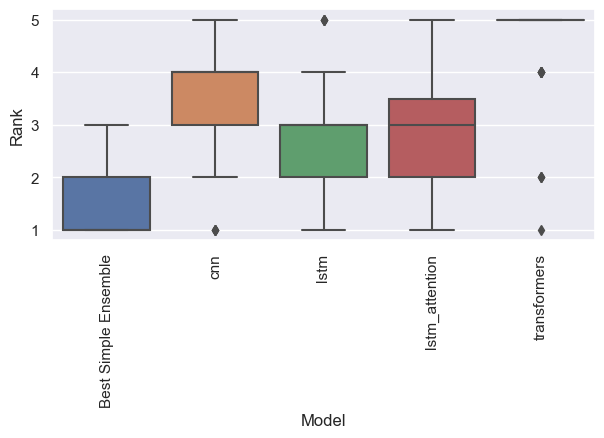

In [ ]:
pivot_simple = mix_best_simple_ens_base_model.pivot(index='City', columns='Alg_name', values='RMSE_1-month')
ranked_pivot_simple = pivot_simple.rank(axis=1)
melted_ranked_pivot_simple = pd.melt(ranked_pivot_simple)
ax = sns.boxplot(x='Alg_name', y='value', data=melted_ranked_pivot_simple)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel('Model')
plt.ylabel('Rank')
plt.show()

# Đọc kết quả Enhanced Weighted Ensemble

In [ ]:
com_path_climate_weighted_result_linearSVR = result_path_weighted_ensemble +'\\predicted_result\\linearSVR\\'

dict_final_SVR_weighted_predict = {}
for city in cities: 
    dict_final_SVR_weighted_predict[city] = pd.read_excel(com_path_climate_weighted_result_linearSVR+city+'_weighted_predict.xlsx')

In [ ]:
dict_final_SVR_weighted_predict['Long An'].head()

Unnamed: 0  CNN*lstm_att_pred-tf_pred-Observed  \
0           0                             5.42881   
1           1                             5.42881   
2           2                             5.42881   
3           3                             5.42881   
4           4                             5.42881   

   CNN*cnn_pred-lstm_pred-Observed  CNN*lstm_pred-tf_pred-Observed  \
0                          5.10263                        5.621295   
1                          5.10263                        5.621295   
2                          5.10263                        5.621295   
3                          5.10263                        5.621295   
4                          5.10263                        5.621295   

   CNN*cnn_pred-lstm_att_pred-lstm_pred-Observed  \
0                                       5.121449   
1                                       5.121449   
2                                       5.121449   
3                                       5.121449   
4                                       5.121449   

   LSTM*lstm_att_pred-lstm_pred-tf_pred-Observed  Weighted_Predict   Observed  \
0                                       5.421818         29.417913  32.749326   
1                                       5.421818         31.903422  31.536388   
2                                       5.421818         31.485669  37.601078   
3                                       5.421818         35.023550  34.568733   
4                                       5.421818         32.959294  33.355795   

   RMSE_Weighted_Predict     City  
0               4.959301  Long An  
1               4.959301  Long An  
2               4.959301  Long An  
3               4.959301  Long An  
4               4.959301  Long An

# Đọc Simple combination và mix với Enhance Weighted Ensemble

In [ ]:
prj_path_result_simple_ensemble = 'H:\\Store\\Research\\UIT\\PhD Research\\Dev Environment\\Tropical Diseases\\running\\eval_result\\\simple_combination_14_12\\'

df_simple_ensemble_metrics = pd.DataFrame()
df_simple_ensemble_metrics = pd.read_excel(prj_path_result_simple_ensemble+'all_combinations_metrics_1.xlsx')
df_simple_ensemble_metrics = df_simple_ensemble_metrics.loc[:,["City","Meta_Model_Name","Based_Models",'RMSE_1-month']]
df_simple_ensemble_metrics['Model Name'] = df_simple_ensemble_metrics['Meta_Model_Name']+'*'+ df_simple_ensemble_metrics['Based_Models']
df_simple_ensemble_metrics = df_simple_ensemble_metrics.loc[:,["City","RMSE_1-month","Model Name"]]
df_simple_ensemble_metrics

# Lấy DF metrix của linearSVR ensemble trên 55 tỉnh
df_linearSVR_weighted_metrix_all_cities = pd.DataFrame()
for city in cities:  
    one_row = dict_final_SVR_weighted_predict[city].head(1) 
    df_linearSVR_weighted_metrix_all_cities = df_linearSVR_weighted_metrix_all_cities.append(one_row[['City', 'RMSE_Weighted_Predict']])

df_linearSVR_weighted_metrix_all_cities.rename(columns = {'RMSE_Weighted_Predict':'RMSE_1-month'}, inplace = True)
df_linearSVR_weighted_metrix_all_cities['Model Name'] = 'Enhanced_Weighted_Ensemble'
df_linearSVR_weighted_metrix_all_cities= df_linearSVR_weighted_metrix_all_cities.reset_index(drop=True)
df_linearSVR_weighted_metrix_all_cities.head()

In [ ]:
mix_linearSVR_and_simple = pd.concat([df_simple_ensemble_metrics,df_linearSVR_weighted_metrix_all_cities], axis= 0)
model_group_mean = mix_linearSVR_and_simple.groupby(['Model Name']).mean()
model_group_mean.sort_values(by='RMSE_1-month',ascending=True)

RMSE_1-month
Model Name                                                      
Enhanced_Weighted_Ensemble                             15.983014
CNN*lstm_att_pred-tf_pred-Observed                     17.119182
CNN*cnn_pred-lstm_pred-Observed                        17.127835
CNN*lstm_pred-tf_pred-Observed                         17.334055
CNN*cnn_pred-lstm_att_pred-lstm_pred-Observed          17.345211
LSTM*lstm_att_pred-lstm_pred-tf_pred-Observed          17.348962
LSTM*cnn_pred-lstm_att_pred-lstm_pred-Observed         17.440244
LSTM*lstm_att_pred-lstm_pred-Observed                  17.478631
CNN*lstm_att_pred-lstm_pred-Observed                   17.514878
LSTM*cnn_pred-lstm_att_pred-tf_pred-Observed           17.712436
LSTM*lstm_att_pred-tf_pred-Observed                    17.812413
CNN*lstm_att_pred-lstm_pred-tf_pred-Observed           17.814287
LSTM*cnn_pred-lstm_att_pred-Observed                   17.816356
LSTM*cnn_pred-lstm_att_pred-lstm_pred-tf_pred-O...     17.940776
LSTM*cnn_pred-lstm_pred-tf_pred-Observed               18.053945
LSTM_ATT*cnn_pred-lstm_att_pred-tf_pred-Observed       18.094802
LSTM*cnn_pred-lstm_pred-Observed                       18.115372
CNN*cnn_pred-lstm_att_pred-lstm_pred-tf_pred-Ob...     18.197185
CNN*cnn_pred-tf_pred-Observed                          18.235545
LSTM_ATT*lstm_att_pred-lstm_pred-Observed              18.242335
CNN*cnn_pred-lstm_att_pred-tf_pred-Observed            18.289794
LSTM_ATT*cnn_pred-lstm_att_pred-lstm_pred-Observed     18.335225
LSTM*cnn_pred-tf_pred-Observed                         18.361433
LSTM*lstm_pred-tf_pred-Observed                        18.559113
CNN*cnn_pred-lstm_att_pred-Observed                    18.580400
CNN*cnn_pred-lstm_pred-tf_pred-Observed                18.808486
LSTM_ATT*cnn_pred-lstm_pred-tf_pred-Observed           18.957902
LSTM_ATT*cnn_pred-lstm_att_pred-Observed               19.248877
LSTM_ATT*cnn_pred-lstm_att_pred-lstm_pred-tf_pr...     19.326855
LSTM_ATT*cnn_pred-lstm_pred-Observed                   19.439957
LSTM_ATT*lstm_att_pred-tf_pred-Observed                19.664437
LSTM_ATT*lstm_att_pred-lstm_pred-tf_pred-Observed      19.671159
LSTM_ATT*lstm_pred-tf_pred-Observed                    20.235821
LSTM_ATT*cnn_pred-tf_pred-Observed                     20.535821
TF*cnn_pred-lstm_att_pred-lstm_pred-tf_pred-Obs...     30.659612
TF*cnn_pred-lstm_pred-tf_pred-Observed                 33.037444
TF*lstm_att_pred-lstm_pred-tf_pred-Observed            33.474017
TF*cnn_pred-lstm_att_pred-tf_pred-Observed             33.729714
TF*cnn_pred-lstm_att_pred-lstm_pred-Observed           33.887078
TF*lstm_att_pred-tf_pred-Observed                      36.329209
TF*cnn_pred-lstm_att_pred-Observed                     36.916820
TF*cnn_pred-tf_pred-Observed                           36.928656
TF*lstm_att_pred-lstm_pred-Observed                    37.680559
TF*lstm_pred-tf_pred-Observed                          38.326243
TF*cnn_pred-lstm_pred-Observed                         43.203731

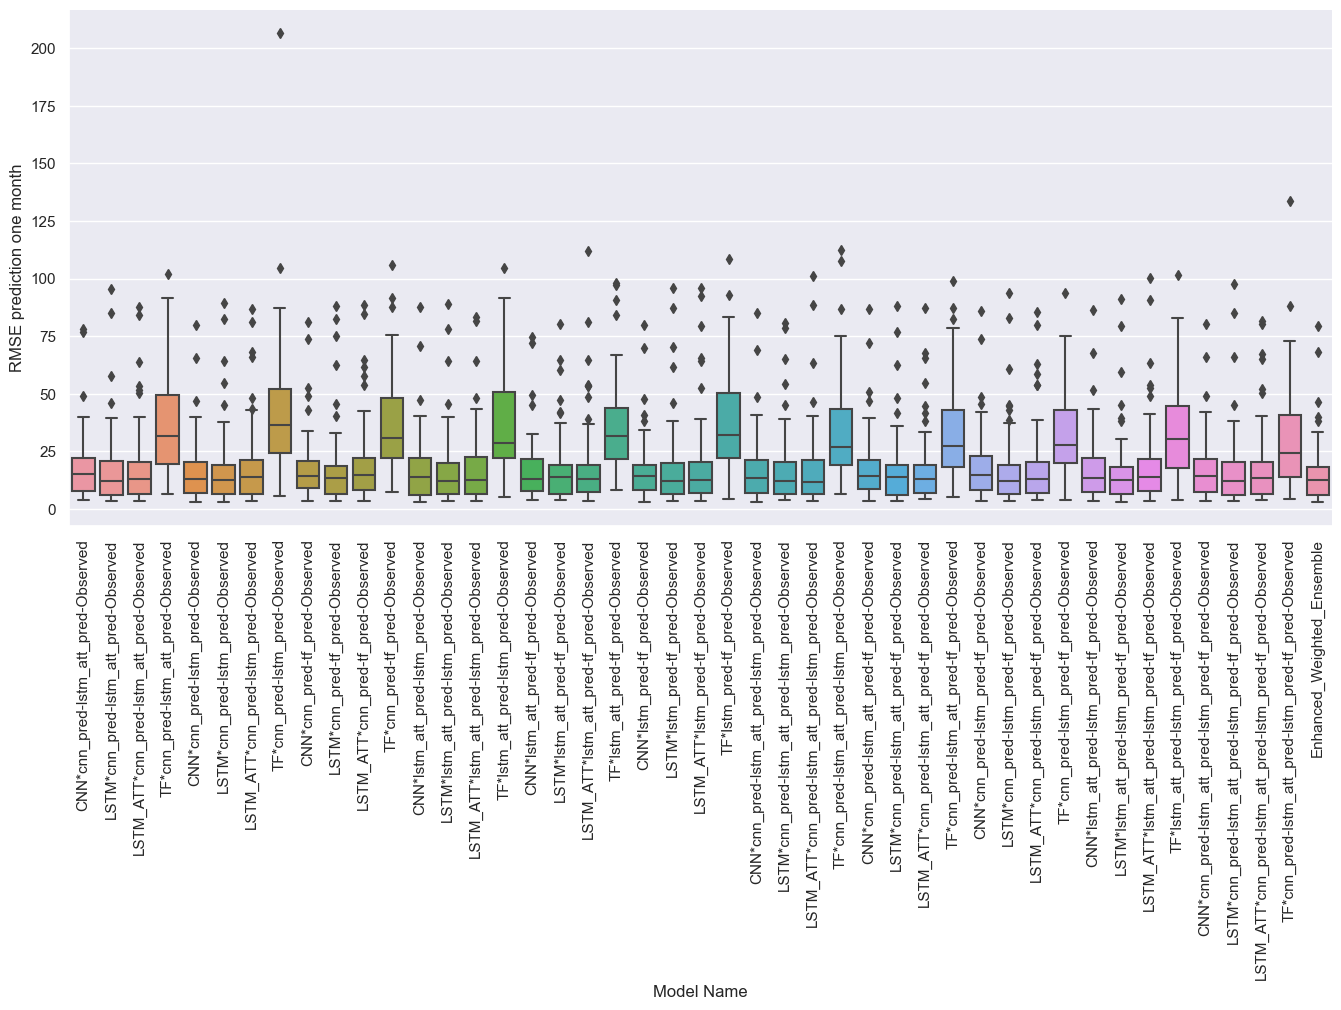

In [ ]:
g= sns.catplot(data = mix_linearSVR_and_simple, x = "Model Name", y = "RMSE_1-month", kind ='box', height=6, aspect=2.6)
g.set(xlabel = "Model Name", ylabel = "RMSE prediction one month")
plt.xticks(rotation=90)
# plt.tight_layout()
plt.show()
plt.savefig(prj_path +'\\Figures\\rank_all_ensemble.png',bbox_inches='tight', dpi =300)

In [ ]:
mix_linearSVR_and_simple = pd.concat([df_simple_ensemble_metrics,df_linearSVR_weighted_metrix_all_cities], axis= 0)
model_group_mean = mix_linearSVR_and_simple.groupby(['Model Name']).mean()
model_group_mean.sort_values(by='RMSE_1-month',ascending=True)

RMSE_1-month
Model Name                                                      
Enhanced_Weighted_Ensemble                             15.983014
CNN*lstm_att_pred-tf_pred-Observed                     17.119182
CNN*cnn_pred-lstm_pred-Observed                        17.127835
CNN*lstm_pred-tf_pred-Observed                         17.334055
CNN*cnn_pred-lstm_att_pred-lstm_pred-Observed          17.345211
LSTM*lstm_att_pred-lstm_pred-tf_pred-Observed          17.348962
LSTM*cnn_pred-lstm_att_pred-lstm_pred-Observed         17.440244
LSTM*lstm_att_pred-lstm_pred-Observed                  17.478631
CNN*lstm_att_pred-lstm_pred-Observed                   17.514878
LSTM*cnn_pred-lstm_att_pred-tf_pred-Observed           17.712436
LSTM*lstm_att_pred-tf_pred-Observed                    17.812413
CNN*lstm_att_pred-lstm_pred-tf_pred-Observed           17.814287
LSTM*cnn_pred-lstm_att_pred-Observed                   17.816356
LSTM*cnn_pred-lstm_att_pred-lstm_pred-tf_pred-O...     17.940776
LSTM*cnn_pred-lstm_pred-tf_pred-Observed               18.053945
LSTM_ATT*cnn_pred-lstm_att_pred-tf_pred-Observed       18.094802
LSTM*cnn_pred-lstm_pred-Observed                       18.115372
CNN*cnn_pred-lstm_att_pred-lstm_pred-tf_pred-Ob...     18.197185
CNN*cnn_pred-tf_pred-Observed                          18.235545
LSTM_ATT*lstm_att_pred-lstm_pred-Observed              18.242335
CNN*cnn_pred-lstm_att_pred-tf_pred-Observed            18.289794
LSTM_ATT*cnn_pred-lstm_att_pred-lstm_pred-Observed     18.335225
LSTM*cnn_pred-tf_pred-Observed                         18.361433
LSTM*lstm_pred-tf_pred-Observed                        18.559113
CNN*cnn_pred-lstm_att_pred-Observed                    18.580400
CNN*cnn_pred-lstm_pred-tf_pred-Observed                18.808486
LSTM_ATT*cnn_pred-lstm_pred-tf_pred-Observed           18.957902
LSTM_ATT*cnn_pred-lstm_att_pred-Observed               19.248877
LSTM_ATT*cnn_pred-lstm_att_pred-lstm_pred-tf_pr...     19.326855
LSTM_ATT*cnn_pred-lstm_pred-Observed                   19.439957
LSTM_ATT*lstm_att_pred-tf_pred-Observed                19.664437
LSTM_ATT*lstm_att_pred-lstm_pred-tf_pred-Observed      19.671159
LSTM_ATT*lstm_pred-tf_pred-Observed                    20.235821
LSTM_ATT*cnn_pred-tf_pred-Observed                     20.535821
TF*cnn_pred-lstm_att_pred-lstm_pred-tf_pred-Obs...     30.659612
TF*cnn_pred-lstm_pred-tf_pred-Observed                 33.037444
TF*lstm_att_pred-lstm_pred-tf_pred-Observed            33.474017
TF*cnn_pred-lstm_att_pred-tf_pred-Observed             33.729714
TF*cnn_pred-lstm_att_pred-lstm_pred-Observed           33.887078
TF*lstm_att_pred-tf_pred-Observed                      36.329209
TF*cnn_pred-lstm_att_pred-Observed                     36.916820
TF*cnn_pred-tf_pred-Observed                           36.928656
TF*lstm_att_pred-lstm_pred-Observed                    37.680559
TF*lstm_pred-tf_pred-Observed                          38.326243
TF*cnn_pred-lstm_pred-Observed                         43.203731

In [ ]:
df_linearSVR_weighted_metrix_all_cities.head()

City  RMSE_1-month                  Model Name
0     An Giang     14.256555  Enhanced_Weighted_Ensemble
1  BR Vũng Tàu     38.089730  Enhanced_Weighted_Ensemble
2   Bình Phước      9.795082  Enhanced_Weighted_Ensemble
3   Bình Thuận     14.537276  Enhanced_Weighted_Ensemble
4    Bình Định      3.888065  Enhanced_Weighted_Ensemble

In [ ]:
mix_best_simple_ens_base_model_short = mix_best_simple_ens_base_model[['City','RMSE_1-month','Alg_name']]
mix_best_simple_ens_base_model_short.head()

City  RMSE_1-month Alg_name
0     An Giang     16.283563      cnn
1  BR Vũng Tàu     28.016330      cnn
2   Bình Phước      9.444873      cnn
3   Bình Thuận     13.973051      cnn
4    Bình Định      4.504450      cnn

In [ ]:
mix_best_simple_ens_base_model_short

City  RMSE_1-month              Alg_name
0      An Giang     16.283563                   cnn
1   BR Vũng Tàu     28.016330                   cnn
2    Bình Phước      9.444873                   cnn
3    Bình Thuận     13.973051                   cnn
4     Bình Định      4.504450                   cnn
..          ...           ...                   ...
50      Lào Cai     24.810351  Best Simple Ensemble
51     Cao Bằng     37.769258  Best Simple Ensemble
52      Kon Tum     44.449599  Best Simple Ensemble
53    Điện Biên     62.910442  Best Simple Ensemble
54    Thái Bình     64.818605  Best Simple Ensemble

[275 rows x 3 columns]

In [ ]:
mix_best_simple_ens_base_model_short['Model Name'] = mix_best_simple_ens_base_model_short['Alg_name']
mix_all = pd.concat([mix_best_simple_ens_base_model_short,df_linearSVR_weighted_metrix_all_cities], axis=0)
mix_all

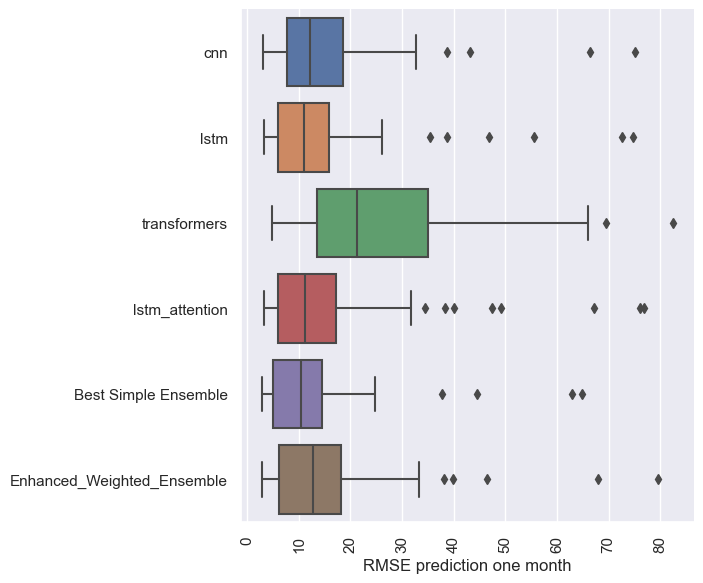

In [ ]:
g = sns.catplot(data=mix_all, x="RMSE_1-month",
                y="Model Name", kind='box', height=6, aspect=1.2)
g.set(ylabel=None, xlabel="RMSE prediction one month")
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig(prj_path + '\\Figures\\avg_rmse_all_single_algo.png', dpi=600)
plt.show()


In [ ]:
model_group_mean = mix_all.groupby(['Model Name']).mean()
model_group_mean.sort_values(by='RMSE_1-month',ascending=True)

RMSE_1-month
Model Name                              
Best Simple Ensemble           13.261319
lstm                           15.345052
Enhanced_Weighted_Ensemble     15.983014
cnn                            16.199412
lstm_attention                 16.791010
transformers                   27.314779

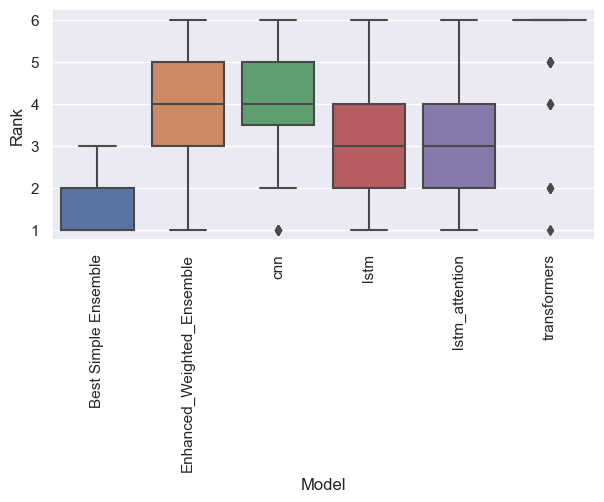

In [ ]:
mix_all_pivot = mix_all.pivot(index='City', columns='Model Name', values='RMSE_1-month')
ranked_mix_all_pivot = mix_all_pivot.rank(axis=1)
ranked_mix_all_pivot
melted_ranked_mix_all_pivot = pd.melt(ranked_mix_all_pivot)
ax = sns.boxplot(x='Model Name', y='value', data=melted_ranked_mix_all_pivot, hue="deck", dodge=False)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel('Model')
plt.ylabel('Rank')
plt.show()

In [ ]:
ranked_mix_all_pivot

Model Name   Best Simple Ensemble  Enhanced_Weighted_Ensemble  cnn  lstm  \
City                                                                       
An Giang                      1.0                         5.0  6.0   3.0   
BR Vũng Tàu                   1.0                         4.0  3.0   6.0   
Bình Phước                    1.0                         3.0  2.0   4.0   
Bình Thuận                    3.0                         4.0  2.0   5.0   
Bình Định                     1.0                         4.0  5.0   3.0   
Bạc Liêu                      2.0                         5.0  4.0   1.0   
Bắc Giang                     1.0                         4.0  6.0   3.0   
Bắc Kạn                       1.0                         4.0  5.0   3.0   
Cao Bằng                      2.0                         5.0  4.0   1.0   
Cà Mau                        2.0                         4.0  5.0   1.0   
Cần Thơ                       3.0                         4.0  5.0   1.0   
Gia Lai                       3.0                         5.0  1.0   2.0   
Hà Giang                      2.0                         1.0  4.0   3.0   
Hà Nội                        1.0                         2.0  6.0   4.0   
Hà Tĩnh                       2.0                         3.0  5.0   1.0   
Hòa Bình                      2.0                         6.0  3.0   5.0   
Hưng Yên                      3.0                         6.0  4.0   5.0   
Hải Dương                     2.0                         5.0  3.0   4.0   
Hải Phòng                     1.0                         2.0  3.0   4.0   
Khánh Hòa                     2.0                         1.0  5.0   4.0   
Kiên Giang                    1.0                         5.0  4.0   3.0   
Kon Tum                       2.0                         3.0  1.0   4.0   
Lai Châu                      1.0                         3.0  4.0   2.0   
Long An                       3.0                         4.0  5.0   2.0   
Lào Cai                       2.0                         1.0  3.0   5.0   
Lâm Đồng                      2.0                         5.0  4.0   1.0   
Lạng Sơn                      2.0                         5.0  4.0   1.0   
Nam Định                      1.0                         3.0  4.0   2.0   
Nghệ An                       2.0                         3.0  5.0   4.0   
Ninh Bình                     2.0                         4.0  3.0   1.0   
Ninh Thuận                    2.0                         3.0  4.0   1.0   
Phú Thọ                       1.0                         4.0  5.0   2.0   
Phú Yên                       3.0                         5.0  1.0   4.0   
Quảng Bình                    1.0                         2.0  5.0   3.0   
Quảng Nam                     2.0                         4.0  5.0   1.0   
Quảng Ngãi                    1.0                         5.0  4.0   3.0   
Quảng Ninh                    1.0                         2.0  5.0   3.0   
Quảng Trị                     1.0                         4.0  5.0   3.0   
Sóc Trăng                     1.0                         3.0  5.0   4.0   
Sơn La                        3.0                         5.0  4.0   1.0   
TT Huế                        3.0                         5.0  4.0   2.0   
Thanh Hóa                     1.0                         2.0  5.0   3.0   
Thái Bình                     1.0                         5.0  3.0   2.0   
Thái Nguyên                   2.0                         6.0  5.0   3.0   
Tiền Giang                    1.0                         3.0  4.0   5.0   
Trà Vinh                      1.0                         2.0  5.0   3.0   
Tuyên Quang                   1.0                         2.0  5.0   4.0   
Tây Ninh                      3.0                         2.0  1.0   5.0   
Vĩnh Phúc                     1.0                         3.0  4.0   2.0   
Yên Bái                       1.0                         2.0  5.0   4.0   
Điện Biên                     1.0               